### 1.1 Problem Statement
Business Problem Overview :
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Understanding & Defining Churn :
There are two main models of payment in the telecom industry - Postpaid (customers pay a monthly/annual bill after using the services) and Prepaid (customers pay/recharge with a certain amount in advance and then use the services).
In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and we directly know that this is an instance of churn.
However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).
Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.This project is based on the Indian and Southeast Asian market.

### Definitions of Churn :
There are various ways to define churn, such as:

1.) Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

2.) Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.
In this project, we will use the usage-based definition to define churn.

### High Value Churn :
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
In this project, we will define high-value customers based on a certain metric and predict churn only on high-value customers.

### 1.2 Business Goal
Understanding the Business Objective & Data :
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

### Understanding Customer Behavior during Churn :
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. 
    
We define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to us for prediction. Thus, after tagging churn as 1/0 based on this phase, we discard all data corresponding to this phase.
In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Suppress Warnings:

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Importing the Python Libraries:

In [2]:
# Data Analysis:
import numpy as np
import pandas as pd
from collections import Counter
from math import sqrt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats libraries:
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Machine Learning Libraries
import statsmodels.api as sm

#Sci-kit learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score,classification_report
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve,plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.ensemble import RandomForestClassifier

In [3]:
# To display all the columns and rows:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Reading & Understanding the data

In [4]:
# Importing the datasets:

Telecom_churn = pd.read_csv("telecom_churn_data.csv")

Telecom_churn.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [5]:
# checking the final 5 rows:
Telecom_churn.tail()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
99994     7001548952        109             0.0             0.0   
99995     7000607688        109             0.0             0.0   
99996     7000087541        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   
99998     7001905007        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
99994             0.0            6/30/2014            7/31/2014   
99995             0.0            6/30/2014            7/31/2014   
99996             0.0            6/30/2014            7/31/2014   
99997             0.0            6/30/2014            7/31/2014   
99998             0.0            6/30/2014            7/31/2014   

      last_date_of_month_8 last_date_of_month_9   arpu_6   arpu_7   arpu_8  \
99994            8/31/2014            9/30/2014   18.471   69.161   57.530   
99995            8/31/2014            9/30/2014  112.201   77.811   79.081   
99996            8/31/2014            9/30/2014  229.187    0.000    0.000   
99997            8/31/2014            9/30/2014  322.991  303.386  606.817   
99998            8/31/2014            9/30/2014  687.065    0.000    0.000   

        arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  \
99994   29.950         5.40         3.36         5.91         0.00   
99995  140.835        29.26        18.13        16.06        49.49   
99996    0.000         1.11          NaN          NaN          NaN   
99997  731.010         0.00         0.00         0.00         0.00   
99998    0.000        84.34          NaN          NaN          NaN   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  \
99994         15.19         54.46         52.79         27.14            0.0   
99995        100.83         69.01         66.39         56.13            0.0   
99996         21.04           NaN           NaN           NaN            0.0   
99997          0.00          0.00          0.00          0.00            0.0   
99998        166.46           NaN           NaN           NaN            0.0   

       roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  \
99994            0.0            0.0           0.00            0.0   
99995            0.0            0.0           0.95            0.0   
99996            NaN            NaN            NaN            0.0   
99997            0.0            0.0           0.00            0.0   
99998            NaN            NaN            NaN            0.0   

       roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  \
99994            0.0            0.0           0.00              5.40   
99995            0.0            0.0           4.23             28.93   
99996            NaN            NaN            NaN              1.11   
99997            0.0            0.0           0.00              0.00   
99998            NaN            NaN            NaN             84.34   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  \
99994              3.36              5.91              0.00             12.78   
99995             18.13             16.06             49.49             91.34   
99996               NaN               NaN               NaN             13.33   
99997              0.00              0.00              0.00              0.00   
99998               NaN               NaN               NaN            166.46   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  \
99994             54.46             49.58             24.78              0.00   
99995             47.53             57.51             46.71              1.71   
99996               NaN               NaN               NaN              0.00   
99997              0.00              0.00              0.00              0.00   
99998               NaN               NaN               NaN              0.00   

       l

In [6]:
# Database dimension:

print("Database dimension     :",Telecom_churn.shape)
print("Database size          :",Telecom_churn.size)
print("Number of Row          :",len(Telecom_churn.index))
print("Number of Columns      :",len(Telecom_churn.columns))

Database dimension     : (99999, 226)
Database size          : 22599774
Number of Row          : 99999
Number of Columns      : 226


In [7]:
# checkin the info. on different columns & it's types:

Telecom_churn.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

#### Insights:
Data types of the different columns are: float, integer and object type. 
We have 179 columns with float values, 35 columns with integer values, 12 columns with Object Values. 
Some of the columns are actually Date, they need to be converted to Date Type format. 
There are some null values in the columns that needs to be handled appropriately.

In [8]:
#checking numerical columns for statistical info:

Telecom_churn.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [9]:
# Check all the column names:

for col in Telecom_churn.columns:
    print(col)

mobile_number
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
arpu_6
arpu_7
arpu_8
arpu_9
onnet_mou_6
onnet_mou_7
onnet_mou_8
onnet_mou_9
offnet_mou_6
offnet_mou_7
offnet_mou_8
offnet_mou_9
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_ic_mou_9
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
roam_og_mou_9
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2t_mou_9
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2m_mou_9
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2f_mou_9
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_t2c_mou_9
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
loc_og_mou_9
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2t_mou_9
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2m_mou_9
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_t2f_mou_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_og_mou_

## Data-cleaning:

In [10]:
### Checking for duplicates:

print("Total number of duplicate values of mobile numbers:", Telecom_churn['mobile_number'].duplicated().sum())

Total number of duplicate values of mobile numbers: 0


#### Insights:
All the Mobile numbers in the data set are unique and there are no duplicate values.

In [11]:
# Creating a copy of original dataframe for duplicate check
Telecom_dup = Telecom_churn

# Checking for duplicates and dropping the entire duplicate row if any

Telecom_dup.drop_duplicates(subset= None, inplace=True)
print ("Original Dataframe: ",Telecom_churn.shape)
print ("Shape of Dataframe after removing duplicates: ", Telecom_dup.shape)

Original Dataframe:  (99999, 226)
Shape of Dataframe after removing duplicates:  (99999, 226)


### Check null values or missing values in %

In [12]:
def null_calc(df):
    #Column wise null values in train data set 
    null_per = pd.DataFrame(round((df.isnull().sum())*100/df.shape[0],2)).reset_index()
    null_per.columns = ['Column Name', 'Null Values Percentage']
    null_value = pd.DataFrame(df.isnull().sum()).reset_index()
    null_value.columns = ['Column Name', 'Null Values']
    null_df = pd.merge(null_value, null_per, on='Column Name')
    null_df['Null Values Percentage'] = pd.to_numeric(null_df['Null Values Percentage'], errors='coerce')
    null_df = null_df.loc[null_df['Null Values Percentage'] > 0.00] # Keeping only null columns info
    null_df.sort_values("Null Values", ascending = False, inplace=True, ignore_index=True)
    return null_df

In [13]:
# Checking the null values
Telecom_null = null_calc(Telecom_churn)
Telecom_null

Column Name  Null Values  Null Values Percentage
0             count_rech_2g_6        74846                   74.85
1             max_rech_data_6        74846                   74.85
2                   arpu_3g_6        74846                   74.85
3          av_rech_amt_data_6        74846                   74.85
4             count_rech_3g_6        74846                   74.85
5            night_pck_user_6        74846                   74.85
6                   arpu_2g_6        74846                   74.85
7                   fb_user_6        74846                   74.85
8           total_rech_data_6        74846                   74.85
9    date_of_last_rech_data_6        74846                   74.85
10            count_rech_3g_7        74428                   74.43
11                  arpu_3g_7        74428                   74.43
12         av_rech_amt_data_7        74428                   74.43
13                  fb_user_7        74428                   74.43
14          total_rech_data_7        74428                   74.43
15            count_rech_2g_7        74428                   74.43
16                  arpu_2g_7        74428                   74.43
17           night_pck_user_7        74428                   74.43
18            max_rech_data_7        74428                   74.43
19   date_of_last_rech_data_7        74428                   74.43
20   date_of_last_rech_data_9        74077                   74.08
21            count_rech_2g_9        74077                   74.08
22          total_rech_data_9        74077                   74.08
23            count_rech_3g_9        74077                   74.08
24            max_rech_data_9        74077                   74.08
25         av_rech_amt_data_9        74077                   74.08
26                  arpu_3g_9        74077                   74.08
27                  fb_user_9        74077                   74.08
28           night_pck_user_9        74077                   74.08
29                  arpu_2g_9        74077                   74.08
30         av_rech_amt_data_8        73660                   73.66
31                  fb_user_8        73660                   73.66
32           night_pck_user_8        73660                   73.66
33            count_rech_2g_8        73660                   73.66
34            count_rech_3g_8        73660                   73.66
35            max_rech_data_8        73660                   73.66
36   date_of_last_rech_data_8        73660                   73.66
37          total_rech_data_8        73660                   73.66
38                  arpu_3g_8        73660                   73.66
39                  arpu_2g_8        73660                   73.66
40              roam_og_mou_9         7745                    7.75
41           std_og_t2c_mou_9         7745                    7.75
42           std_ic_t2f_mou_9         7745                    7.75
43           std_ic_t2m_mou_9         7745                    7.75
44               loc_ic_mou_9         7745                    7.75
45               std_og_mou_9         7745                    7.75
46                og_others_9         7745                    7.75
47           std_ic_t2o_mou_9         7745                    7.75
48               isd_og_mou_9         7745                    7.75
49               offnet_mou_9         7745                    7.75
50               spl_og_mou_9         7745                    7.75
51           std_og_t2f_mou_9         7745                    7.75
52           std_og_t2m_mou_9         7745                    7.75
53           loc_ic_t2t_mou_9         7745                    7.75
54               std_ic_mou_9         7745                    7.75
55           loc_og_t2f_mou_9         7745                    7.75
56                ic_others_9         7745                    7.75
57           loc_og_t2t_mou_9         7745                    7.75
58           loc_ic_t2m_mou_9         7745                    7.7

In [14]:
# Columns with Higher Percentage of null values (> 70%)
print("Total number of columns with null values more than 70% :", len(Telecom_null[Telecom_null['Null Values Percentage']>70]))

print("Total number of columns with null values:", Telecom_null.shape[0])

Total number of columns with null values more than 70% : 40
Total number of columns with null values: 166


### Approach to handle Null-values:

There are 40 columns which have more than 70% null values. 
We can remove these columns from calculation as imputing values with such high null values will affect our prediction results 

Some of the columns like night_pack_X or fb_user_X (where X signified the month value 6/7/8/9) have high null values. 
In these cases, we can consider that the particular customer did not take those packages or they did not opt for social media utilities. 
For such columns, we can impute null values with 0.

High value customers can be considered as those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months, which signifies the good phase.
Hence, we have to first treat the columns related to recharge amount to identify high value customer.

### columns to consider:
date_of_last_rech_data_6 - 74.85 % missing values

date_of_last_rech_data_7 - 74.43 % missing values

av_rech_amt_data_6 - 74.85 % missing values

av_rech_amt_data_7 - 74.43 % missing values

total_rech_data_6 - 74.85 % missing values

total_rech_data_7 - 74.43 % missing values

In [15]:
### Handling Null-Values: Imputation

# Imputing the data for total_rech_data_6 and av_rech_amt_data_6 with '0'
Telecom_churn['total_rech_data_6'].fillna(0, inplace=True)
Telecom_churn['av_rech_amt_data_6'].fillna(0, inplace=True)

In [16]:
# Checking if data recharge null row indexes matches with same customers data of null values in last recharge data information for July_month
if Telecom_churn['total_rech_data_7'].isnull().equals(Telecom_churn['date_of_last_rech_data_7'].isnull()):
    print('Indexes of null values of July are equal')

# Checking if data recharge null row indexes matches with same customers data of null values in last recharge data information for August_month
if Telecom_churn['total_rech_data_8'].isnull().equals(Telecom_churn['date_of_last_rech_data_8'].isnull()):
    print('Indexes of null values of August are equal')   

Indexes of null values of July are equal
Indexes of null values of August are equal


In [17]:
# Imputing the data for total_rech_data_7 and av_rech_amt_data_7 with '0'
Telecom_churn['total_rech_data_7'].fillna(0, inplace=True)
Telecom_churn['av_rech_amt_data_7'].fillna(0, inplace=True)

# Imputing the data for total_rech_data_8 and av_rech_amt_data_8 with '0'
Telecom_churn['total_rech_data_8'].fillna(0, inplace=True)
Telecom_churn['av_rech_amt_data_8'].fillna(0, inplace=True)

In [18]:
# Check the missing or null values again after Imputation
Telecom_null = null_calc(Telecom_churn)
Telecom_null

Column Name  Null Values  Null Values Percentage
0             max_rech_data_6        74846                   74.85
1            night_pck_user_6        74846                   74.85
2                   arpu_3g_6        74846                   74.85
3             count_rech_2g_6        74846                   74.85
4                   arpu_2g_6        74846                   74.85
5             count_rech_3g_6        74846                   74.85
6                   fb_user_6        74846                   74.85
7    date_of_last_rech_data_6        74846                   74.85
8            night_pck_user_7        74428                   74.43
9    date_of_last_rech_data_7        74428                   74.43
10            max_rech_data_7        74428                   74.43
11                  arpu_2g_7        74428                   74.43
12                  fb_user_7        74428                   74.43
13            count_rech_2g_7        74428                   74.43
14                  arpu_3g_7        74428                   74.43
15            count_rech_3g_7        74428                   74.43
16   date_of_last_rech_data_9        74077                   74.08
17          total_rech_data_9        74077                   74.08
18            count_rech_3g_9        74077                   74.08
19            max_rech_data_9        74077                   74.08
20            count_rech_2g_9        74077                   74.08
21                  fb_user_9        74077                   74.08
22                  arpu_3g_9        74077                   74.08
23                  arpu_2g_9        74077                   74.08
24         av_rech_amt_data_9        74077                   74.08
25           night_pck_user_9        74077                   74.08
26                  arpu_2g_8        73660                   73.66
27            count_rech_3g_8        73660                   73.66
28            max_rech_data_8        73660                   73.66
29                  fb_user_8        73660                   73.66
30                  arpu_3g_8        73660                   73.66
31           night_pck_user_8        73660                   73.66
32            count_rech_2g_8        73660                   73.66
33   date_of_last_rech_data_8        73660                   73.66
34           std_ic_t2f_mou_9         7745                    7.75
35           std_og_t2c_mou_9         7745                    7.75
36           std_ic_t2o_mou_9         7745                    7.75
37           std_og_t2f_mou_9         7745                    7.75
38           std_ic_t2m_mou_9         7745                    7.75
39           loc_ic_t2f_mou_9         7745                    7.75
40           loc_ic_t2t_mou_9         7745                    7.75
41               std_og_mou_9         7745                    7.75
42           std_ic_t2t_mou_9         7745                    7.75
43           loc_ic_t2m_mou_9         7745                    7.75
44               isd_og_mou_9         7745                    7.75
45               spl_og_mou_9         7745                    7.75
46               loc_ic_mou_9         7745                    7.75
47               spl_ic_mou_9         7745                    7.75
48               std_ic_mou_9         7745                    7.75
49           loc_og_t2c_mou_9         7745                    7.75
50           std_og_t2m_mou_9         7745                    7.75
51               loc_og_mou_9         7745                    7.75
52                onnet_mou_9         7745                    7.75
53               offnet_mou_9         7745                    7.75
54              roam_ic_mou_9         7745                    7.75
55              roam_og_mou_9         7745                    7.75
56           loc_og_t2t_mou_9         7745                    7.75
57           loc_og_t2m_mou_9         7745                    7.75
58           loc_og_t2f_mou_9         7745                    7.7

#### Handling Null-values: II

Now, we can target some of the other columns like arpu_3g_X, night_pck_use_Xm, fb_user_X columns for null value imputation. Based on the data description, we can say that if the data is missing, we can consider the customer has not opted for these facilities. 
We can impute null values as 0 here.

### columns to consider:
arpu_2g_X ; arpu_3g_X

count_rech_2g_X ; count_rech_3g_X

night_pck_user_X ; fb_user_X

In [19]:
# Checking the index matching for month 6

Index_columns = ['arpu_2g_6', 'arpu_3g_6', 'night_pck_user_6', 'count_rech_2g_6', 'count_rech_3g_6', 'fb_user_6']

if all(Telecom_churn[col].isnull().equals(Telecom_churn[Index_columns[0]].isnull()) for col in Index_columns):
    print('Indexes for NULL values of June are equal')

Indexes for NULL values of June are equal


In [20]:
# Checking the index matching for month 7
Index_columns_7 = ['arpu_2g_7', 'arpu_3g_7', 'night_pck_user_7', 'count_rech_2g_7', 'count_rech_3g_7', 'fb_user_7']

if all(Telecom_churn[col].isnull().equals(Telecom_churn[Index_columns_7[0]].isnull()) for col in Index_columns_7):
    print('Indexes for NULL values of July are equal')

Indexes for NULL values of July are equal


In [21]:
# Checking the index matching for month 7

Index_columns_8 = ['arpu_2g_8', 'arpu_3g_8', 'night_pck_user_8', 'count_rech_2g_8', 'count_rech_3g_8', 'fb_user_8']

if all(Telecom_churn[col].isnull().equals(Telecom_churn[Index_columns_8[0]].isnull()) for col in Index_columns_8):
    print('Indexes for NULL values of August are equal')

Indexes for NULL values of August are equal


In [22]:
cols_to_impute = ['fb_user_6','fb_user_7','fb_user_8','fb_user_9',
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9',
                  'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9',
                  'arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9',
                  'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9',
                  'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9']
for col in cols_to_impute:
    Telecom_churn[col].fillna(0, inplace=True)

In [23]:
# Checking the remaining null value columns:
Telecom_null = null_calc(Telecom_churn)
Telecom_null

Column Name  Null Values  Null Values Percentage
0             max_rech_data_6        74846                   74.85
1    date_of_last_rech_data_6        74846                   74.85
2             max_rech_data_7        74428                   74.43
3    date_of_last_rech_data_7        74428                   74.43
4          av_rech_amt_data_9        74077                   74.08
5             max_rech_data_9        74077                   74.08
6           total_rech_data_9        74077                   74.08
7    date_of_last_rech_data_9        74077                   74.08
8             max_rech_data_8        73660                   73.66
9    date_of_last_rech_data_8        73660                   73.66
10           loc_ic_t2f_mou_9         7745                    7.75
11           loc_ic_t2m_mou_9         7745                    7.75
12           loc_og_t2c_mou_9         7745                    7.75
13           std_ic_t2t_mou_9         7745                    7.75
14               loc_ic_mou_9         7745                    7.75
15           loc_og_t2f_mou_9         7745                    7.75
16           loc_ic_t2t_mou_9         7745                    7.75
17               loc_og_mou_9         7745                    7.75
18           std_og_t2m_mou_9         7745                    7.75
19                og_others_9         7745                    7.75
20           std_og_t2t_mou_9         7745                    7.75
21               spl_og_mou_9         7745                    7.75
22               isd_og_mou_9         7745                    7.75
23           std_ic_t2m_mou_9         7745                    7.75
24               std_og_mou_9         7745                    7.75
25           std_og_t2f_mou_9         7745                    7.75
26           loc_og_t2m_mou_9         7745                    7.75
27           std_og_t2c_mou_9         7745                    7.75
28               offnet_mou_9         7745                    7.75
29              roam_og_mou_9         7745                    7.75
30               spl_ic_mou_9         7745                    7.75
31           std_ic_t2f_mou_9         7745                    7.75
32               isd_ic_mou_9         7745                    7.75
33               std_ic_mou_9         7745                    7.75
34              roam_ic_mou_9         7745                    7.75
35           std_ic_t2o_mou_9         7745                    7.75
36                ic_others_9         7745                    7.75
37           loc_og_t2t_mou_9         7745                    7.75
38                onnet_mou_9         7745                    7.75
39               isd_og_mou_8         5378                    5.38
40               isd_ic_mou_8         5378                    5.38
41                ic_others_8         5378                    5.38
42               std_og_mou_8         5378                    5.38
43                og_others_8         5378                    5.38
44           std_og_t2c_mou_8         5378                    5.38
45               spl_ic_mou_8         5378                    5.38
46           loc_ic_t2t_mou_8         5378                    5.38
47           loc_ic_t2m_mou_8         5378                    5.38
48           loc_ic_t2f_mou_8         5378                    5.38
49               std_ic_mou_8         5378                    5.38
50               loc_ic_mou_8         5378                    5.38
51           std_ic_t2o_mou_8         5378                    5.38
52           std_ic_t2t_mou_8         5378                    5.38
53           std_ic_t2m_mou_8         5378                    5.38
54           std_ic_t2f_mou_8         5378                    5.38
55               spl_og_mou_8         5378                    5.38
56           loc_og_t2m_mou_8         5378                    5.38
57              roam_og_mou_8         5378                    5.38
58              roam_ic_mou_8         5378                    5.3

#### Insights:
-- Null value Imputation performed on '29 columns' with high null values(>70%).

In [24]:
print("Total number of columns with null values more than 70% :", len(Telecom_null[Telecom_null['Null Values Percentage']>70]))

print("Total number of columns with null values:", Telecom_null.shape[0])

Total number of columns with null values more than 70% : 10
Total number of columns with null values: 136


In [25]:
# Rename months named vbc columns to format 6,7,8 and 9

Telecom_churn.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                          'jul_vbc_3g':'vbc_3g_7',
                          'aug_vbc_3g':'vbc_3g_8',
                          'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

### Statistical Info:

In [26]:
Telecom_churn[['arpu_6', 'arpu_7', 'arpu_8']].describe()

arpu_6        arpu_7        arpu_8
count  99999.000000  99999.000000  99999.000000
mean     282.987358    278.536648    279.154731
std      328.439770    338.156291    344.474791
min    -2258.709000  -2014.045000   -945.808000
25%       93.411500     86.980500     84.126000
50%      197.704000    191.640000    192.080000
75%      371.060000    365.344500    369.370500
max    27731.088000  35145.834000  33543.624000

#### Insights:

The above statistical description of the ARPU - Average Revenue Per User column gives some important insight. 

The MINIMUM value for all the ARPU related columns are NEGATIVE. 

Now as per the definition of ARPU which says -

"The average revenue per user is the average billing per customer earned by the telecom company every month".

Now the revenue generated from a user cannot be negative. 

If a customer is not using any services then arpu for the person would be zero 
(rather that being negative). Now if arpu is negative for any row, then that would mean that is a wrong/corrupt data. 
It will be of no use for our analysis. Hence, we can drop such observations.

In [27]:
#### Checking ARPU - Observations for months -6,7,8

In [28]:
print('Total observations with negative arpu values for month 6 :' , len(Telecom_churn[Telecom_churn['arpu_6']<0]))
print('Total observations with negative arpu values for month 7 :' , len(Telecom_churn[Telecom_churn['arpu_7']<0]))
print('Total observations with negative arpu values for month 8 :' , len(Telecom_churn[Telecom_churn['arpu_8']<0]))

Total observations with negative arpu values for month 6 : 416
Total observations with negative arpu values for month 7 : 498
Total observations with negative arpu values for month 8 : 508


In [29]:
# Dropping the rows where arpu_X with negative values

Telecom_churn = Telecom_churn[(Telecom_churn['arpu_6'] >= 0) & 
                  (Telecom_churn['arpu_7'] >= 0) & 
                  (Telecom_churn['arpu_8'] >= 0)]

Telecom_churn.shape

(98587, 226)

In [30]:
Telecom_churn[['arpu_6','arpu_7','arpu_8']].describe()

arpu_6        arpu_7        arpu_8
count  98587.000000  98587.000000  98587.000000
mean     284.728782    281.084361    281.282791
std      328.702612    338.672390    344.949429
min        0.000000      0.000000      0.000000
25%       94.556000     88.683500     85.905500
50%      199.200000    194.041000    194.232000
75%      372.856500    368.132000    371.490000
max    27731.088000  35145.834000  33543.624000

Note:
We dropped 1412 rows of data which 1.4% of overall data. This will not impact much on our analysis.

### Identify: High-Value customers

#### Approach:

total_data_rech_amt = total_rechdata * av_rech_amtdata

Also, this new feature would help us in computing the total data recharge amount : 'total_data_rech_amt' for the months 6, 7, 8 & 9.

In [31]:
Telecom_churn['total_data_rech_amt_6'] = Telecom_churn['total_rech_data_6'] * Telecom_churn['av_rech_amt_data_6']
Telecom_churn['total_data_rech_amt_7'] = Telecom_churn['total_rech_data_7'] * Telecom_churn['av_rech_amt_data_7']
Telecom_churn['total_data_rech_amt_8'] = Telecom_churn['total_rech_data_8'] * Telecom_churn['av_rech_amt_data_8']
Telecom_churn['total_data_rech_amt_9'] = Telecom_churn['total_rech_data_9'] * Telecom_churn['av_rech_amt_data_9']

Note:
    Our objective is to We need to predict churn only for the high-value customers. 
    Define high-value customers as follows: 
        
        Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months which are the good phases.

In [32]:
### Average recharge amount for the month 6 & 7. 

Avg_recharge_amount_month_6_7 = Telecom_churn[['total_data_rech_amt_6','total_data_rech_amt_7','total_rech_amt_6',
                                             'total_rech_amt_7']].mean(axis = 1)

amount_70th_percentile = np.percentile(Avg_recharge_amount_month_6_7, 70)

print("70th percentile of the average recharge amount in the first two months is - ", amount_70th_percentile)

70th percentile of the average recharge amount in the first two months is -  240.75


In [33]:
# Filter out only the high-value customers
Tel_high_val = Telecom_churn[Avg_recharge_amount_month_6_7 >= amount_70th_percentile]

# Reset the index
Tel_high_val = Tel_high_val.reset_index(drop=True)

Tel_high_val.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7000701601        109             0.0             0.0             0.0   
2     7001524846        109             0.0             0.0             0.0   
3     7002124215        109             0.0             0.0             0.0   
4     7000887461        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014   197.385   214.816   213.803   21.100          NaN   
1            9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
2            9/30/2014   378.721   492.223   137.362  166.787       413.69   
3            9/30/2014   514.453   597.753   637.760  578.596       102.41   
4            9/30/2014    74.350   193.897   366.966  811.480        48.96   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        54.68        52.29          NaN        453.43        567.16   
2       351.03        35.08        33.46         94.66         80.63   
3       132.11        85.14       161.63        757.93        896.68   
4        50.66        33.58        15.74         85.41         89.36   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        325.91           NaN          16.23          33.49          31.64   
2        136.48        108.71           0.00           0.00           0.00   
3        983.39        869.89           0.00           0.00           0.00   
4        205.89        111.88           0.00           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1            NaN          23.74          12.59          38.06            NaN   
2            0.0           0.00           0.00           0.00            0.0   
3            0.0           0.00           0.00           0.00            0.0   
4            0.0           0.00           0.00           0.00            0.0   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             51.39             31.38             40.28               NaN   
2            297.13            217.59             12.49             26.13   
3              4.48              6.16             23.34             29.98   
4             48.96             50.66             33.58             15.74   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1            308.63            447.38            162.28               NaN   
2             80.96             70.58             50.54             34.58   
3             91.81             87.93            104.81            107.54   
4             82.94             83.01            148.56             83.73   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1             62.13             55.14             53.23               NaN   
2              0.00              0.00              0.00              0.00   
3              0.75              

In [34]:
# high value customer dimension:
print("Database dimension :",Tel_high_val.shape)
print("Database size:",Tel_high_val.size)
print("Number of Row:",len(Tel_high_val.index))
print("Number of Columns:",len(Tel_high_val.columns))

Database dimension : (29591, 230)
Database size: 6805930
Number of Row: 29591
Number of Columns: 230


### Insights:
We have Identified 'High Value Customers' & created a new dataframe containing High Value Customers

### Customer Churn Calculation

#### Strategy:

    To dentify churn customers (churn=1, else 0) based on the fourth month (_9) data. Customers who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase can be considered as churned customer. 
    The attributes we need to use to tag churners are :

vol_2g_mb_9

vol_3g_mb_9

total_ic_mou_9

total_og_mou_9

Any customer who does not use any of the facility (calls or mobile data) during the 9th month, will have the row sum for the attributes equal to zero. 

This customer can be tagged as Churn (1) else the customer will be tagged as Not Churn (0).

In [35]:
Tel_high_val['churn'] = Tel_high_val.apply(lambda x: 1 if((x.total_ic_mou_9 == 0) & 
                                                          (x.total_og_mou_9 == 0) and 
                                                          (x.vol_2g_mb_9 == 0) and 
                                                          (x.vol_3g_mb_9 == 0)) else 0, axis=1)

In [36]:
 Tel_high_val[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9','churn']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  churn
0            0.00            0.00         0.00         0.00      1
1            0.00            0.00         0.00         0.00      1
2           34.91          142.18         0.00         0.00      0
3          252.61         1031.53         0.00         0.00      0
4          127.48          127.63        13.93       314.74      0

#### Insights:

From the First 5 customer data:
    
first two customer stopped using all calls and data and thus are tagged as churn. 

The 3rd and 4th customer did not have data but had incoming and outgoing calls. 

Thus, they are marked as 0 which means not churned. 

The 5th customer had data as well as calls, thus it is also rightly marked as not churned

In [37]:
# To get all the columns in the 'Tel_high_val' dataset where the column have '_9' in the name.

cols_with_9 = [col for col in Tel_high_val.columns if '_9' in col]
cols_with_9

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 

Note:
    
Dropping the data for the 9th month as they will not be used in prediction purpose as these values are not available for the model. 
They are only considered to calculate whether customer has churned or not.

In [38]:
# Dropping the 9 month data. Let's check how many column data we are about to drop 
print("Number of columns to be dropped : ", len(cols_with_9))

Number of columns to be dropped :  56


In [39]:
Tel_high_val = Tel_high_val.drop(cols_with_9, axis=1)

print("Number of Columns remaining:", len(Tel_high_val.columns))

Number of Columns remaining: 175


### Handling Null-Value - III

-- High-Value customer data

In [40]:
Telecom_null = null_calc(Tel_high_val)

Telecom_null

Column Name  Null Values  Null Values Percentage
0             max_rech_data_8        13740                   46.43
1    date_of_last_rech_data_8        13740                   46.43
2             max_rech_data_6        12977                   43.85
3    date_of_last_rech_data_6        12977                   43.85
4             max_rech_data_7        12670                   42.82
5    date_of_last_rech_data_7        12670                   42.82
6            loc_ic_t2f_mou_8         1088                    3.68
7            std_ic_t2m_mou_8         1088                    3.68
8            loc_og_t2c_mou_8         1088                    3.68
9            std_ic_t2t_mou_8         1088                    3.68
10               loc_og_mou_8         1088                    3.68
11               loc_ic_mou_8         1088                    3.68
12           std_og_t2t_mou_8         1088                    3.68
13           std_og_t2f_mou_8         1088                    3.68
14           std_og_t2m_mou_8         1088                    3.68
15           loc_ic_t2m_mou_8         1088                    3.68
16               isd_og_mou_8         1088                    3.68
17           loc_ic_t2t_mou_8         1088                    3.68
18           std_og_t2c_mou_8         1088                    3.68
19                og_others_8         1088                    3.68
20               std_og_mou_8         1088                    3.68
21           loc_og_t2f_mou_8         1088                    3.68
22           std_ic_t2f_mou_8         1088                    3.68
23               spl_og_mou_8         1088                    3.68
24                ic_others_8         1088                    3.68
25              roam_ic_mou_8         1088                    3.68
26           loc_og_t2m_mou_8         1088                    3.68
27               offnet_mou_8         1088                    3.68
28               spl_ic_mou_8         1088                    3.68
29              roam_og_mou_8         1088                    3.68
30               isd_ic_mou_8         1088                    3.68
31               std_ic_mou_8         1088                    3.68
32           loc_og_t2t_mou_8         1088                    3.68
33                onnet_mou_8         1088                    3.68
34           std_ic_t2o_mou_8         1088                    3.68
35        date_of_last_rech_8          529                    1.79
36                ic_others_6          520                    1.76
37                og_others_6          520                    1.76
38           loc_ic_t2m_mou_6          520                    1.76
39           loc_ic_t2t_mou_6          520                    1.76
40           std_ic_t2o_mou_6          520                    1.76
41           loc_ic_t2f_mou_6          520                    1.76
42               loc_ic_mou_6          520                    1.76
43           std_ic_t2t_mou_6          520                    1.76
44               spl_ic_mou_6          520                    1.76
45           std_ic_t2m_mou_6          520                    1.76
46               std_ic_mou_6          520                    1.76
47           std_ic_t2f_mou_6          520                    1.76
48               isd_ic_mou_6          520                    1.76
49               spl_og_mou_6          520                    1.76
50               offnet_mou_6          520                    1.76
51              roam_og_mou_6          520                    1.76
52           loc_og_t2c_mou_6          520                    1.76
53               loc_og_mou_6          520                    1.76
54           loc_og_t2m_mou_6          520                    1.76
55           std_og_t2t_mou_6          520                    1.76
56           loc_og_t2t_mou_6          520                    1.76
57           std_og_t2m_mou_6          520                    1.76
58           std_og_t2f_mou_6          520                    1.7

In [41]:
#### checking for null-value > 40%

print("Total number of columns with null values more than 40% :", len(Telecom_null[Telecom_null['Null Values Percentage']>40]))

Total number of columns with null values more than 40% : 6


#### Insights:

There are 6 columns has null-values > 40% ; Hence, we can drop these columns. 

Imputation is not appropriate in this case:
    
'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8' columns. 
These are date columns and it is not possible to impute the null values.

In [42]:
# Dropping the date_of_last_rech_data_X columns

Tel_high_val.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'],axis = 1, inplace = True)

print("Number of Columns remaining:",len(Tel_high_val.columns))

Number of Columns remaining: 172


In [43]:
# Data distribution of 3 max-columns : 

Tel_high_val[['max_rech_data_6', 'max_rech_data_7' , 'max_rech_data_8']].describe()

max_rech_data_6  max_rech_data_7  max_rech_data_8
count     16614.000000     16921.000000     15851.000000
mean        139.744192       140.500561       136.448300
std         118.743427       120.291309       119.687372
min           1.000000         1.000000         1.000000
25%          25.000000        25.000000        25.000000
50%         152.000000       152.000000       152.000000
75%         198.000000       198.000000       198.000000
max        1555.000000      1555.000000      1555.000000

In [44]:
print ("Total NULL values for max_rech_data_6 column : ",Tel_high_val.max_rech_data_6.isnull().sum())
print ("Total NULL values for max_rech_data_7 column : ",Tel_high_val.max_rech_data_7.isnull().sum())
print ("Total NULL values for max_rech_data_8 column : ",Tel_high_val.max_rech_data_8.isnull().sum())

Total NULL values for max_rech_data_6 column :  12977
Total NULL values for max_rech_data_7 column :  12670
Total NULL values for max_rech_data_8 column :  13740


#### Insights:

Maximum recharge value found out to be 1555 and minimum recharge value is 1. 
We can consider that null value means the customer has not recharged that month. 
We will impute 0 for the null values for these three columns.

In [45]:
for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    Tel_high_val[col].fillna(0, inplace=True)

In [46]:
# check the remaining null values for rest of the columns 
Telecom_null = null_calc(Tel_high_val)

Telecom_null

Column Name  Null Values  Null Values Percentage
0       loc_og_t2m_mou_8         1088                    3.68
1       std_ic_t2m_mou_8         1088                    3.68
2       std_ic_t2t_mou_8         1088                    3.68
3           std_og_mou_8         1088                    3.68
4           loc_ic_mou_8         1088                    3.68
5       loc_og_t2f_mou_8         1088                    3.68
6       loc_ic_t2f_mou_8         1088                    3.68
7       loc_og_t2c_mou_8         1088                    3.68
8       loc_ic_t2m_mou_8         1088                    3.68
9           loc_og_mou_8         1088                    3.68
10      loc_ic_t2t_mou_8         1088                    3.68
11      std_og_t2t_mou_8         1088                    3.68
12           og_others_8         1088                    3.68
13      std_og_t2m_mou_8         1088                    3.68
14          spl_og_mou_8         1088                    3.68
15      std_og_t2f_mou_8         1088                    3.68
16          isd_og_mou_8         1088                    3.68
17      loc_og_t2t_mou_8         1088                    3.68
18      std_og_t2c_mou_8         1088                    3.68
19          std_ic_mou_8         1088                    3.68
20          offnet_mou_8         1088                    3.68
21         roam_og_mou_8         1088                    3.68
22      std_ic_t2f_mou_8         1088                    3.68
23           ic_others_8         1088                    3.68
24          isd_ic_mou_8         1088                    3.68
25         roam_ic_mou_8         1088                    3.68
26          spl_ic_mou_8         1088                    3.68
27      std_ic_t2o_mou_8         1088                    3.68
28           onnet_mou_8         1088                    3.68
29   date_of_last_rech_8          529                    1.79
30      loc_ic_t2f_mou_6          520                    1.76
31      std_ic_t2m_mou_6          520                    1.76
32      loc_ic_t2m_mou_6          520                    1.76
33          spl_ic_mou_6          520                    1.76
34          std_ic_mou_6          520                    1.76
35      loc_ic_t2t_mou_6          520                    1.76
36          loc_ic_mou_6          520                    1.76
37          isd_ic_mou_6          520                    1.76
38           og_others_6          520                    1.76
39      std_ic_t2o_mou_6          520                    1.76
40           ic_others_6          520                    1.76
41          spl_og_mou_6          520                    1.76
42      std_ic_t2t_mou_6          520                    1.76
43      std_ic_t2f_mou_6          520                    1.76
44          isd_og_mou_6          520                    1.76
45         roam_ic_mou_6          520                    1.76
46      std_og_t2m_mou_6          520                    1.76
47          std_og_mou_6          520                    1.76
48      loc_og_t2f_mou_6          520                    1.76
49      loc_og_t2t_mou_6          520                    1.76
50      loc_og_t2c_mou_6          520                    1.76
51         roam_og_mou_6          520                    1.76
52          loc_og_mou_6          520                    1.76
53      std_og_t2t_mou_6          520                    1.76
54      loc_og_t2m_mou_6          520                    1.76
55      std_og_t2c_mou_6          520                    1.76
56      std_og_t2f_mou_6          520                    1.76
57           onnet_mou_6          520                    1.76
58          offnet_mou_6          520                    1.76
59          offnet_mou_7          507                    1.71
60           ic_others_7          507                    1.71
61      loc_og_t2t_mou_7          507                    1.71
62          isd_ic_mou_7          507                    1.71
63      std_ic_t2f_mou_7          507        

In [47]:
# Dropping the date columns in which imputation is not possible:

Tel_high_val.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                        'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], axis = 1, inplace = True)
Tel_high_val.shape

(29591, 166)

#### Insights:

Remaining 95 columns with null values, they contain MOU - Minutes of usage - voice call data. 

Now, a null value in these columns can be considered as 0, meaning the customer has not utilized these facilities.

If we look into the columns properly, we can notice that the MOU null values for month 8th is significantly more than month 6th and 7th (almost doubled). 

This sgnifies that the customers are now starting to leave (churn) the telecom company.

In [48]:
# Let's store the null columns as a list first

cols_null = Tel_high_val.columns[Tel_high_val.isna().any()].tolist()

print(cols_null)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_m

In [49]:
# Let's impute these data with 0

for col in cols_null:
    Tel_high_val[col].fillna(0, inplace=True) 

In [50]:
Telecom_null = null_calc(Tel_high_val)

Telecom_null  #### No null-value columns present in the high value customer data!!

Empty DataFrame
Columns: [Column Name, Null Values, Null Values Percentage]
Index: []

In [51]:
Tel_high_val.shape  ## Jus checking the dimension of the high value customer data

(29591, 166)

#### Dropping Unnecessary Columns (not useful for analysis)

In [52]:
#Variance 
columns_with_0_variance = Tel_high_val.var() == 0
print("Total columns with ZERO variance are : ", columns_with_0_variance.sum())

column_name_with_0_variance = columns_with_0_variance[columns_with_0_variance == 1].index
print(column_name_with_0_variance)

Total columns with ZERO variance are :  9
Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')


In [53]:
Tel_high_val.drop(column_name_with_0_variance,axis=1, inplace = True)

Tel_high_val.shape

(29591, 157)

Note:

Dropping the individual columns (whose totals are already available like incoming, outgoing, arpu, etc) can help us in better analysis. Also, dropping these individual columns will help in removing the multicollinearity.

Also, we can drop the mobile_number column as it will not be needed for prediction purpose.

In [54]:
### Individual columns whose totals are available as a different attribute

Individual_cols = ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
                   'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
                   'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
                   'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8',
                   'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8',
                   'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
                   'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                   'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                   'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
                   'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
                   'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
                   'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
                   'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
                   'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
                   'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
                   'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
                   'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
                   'mobile_number']

Tel_high_val.drop(Individual_cols, axis = 1, inplace = True)

Tel_high_val.shape

(29591, 105)

#### Categorical Columns (binary to categorical)

In [55]:
# Checking the unique values in the dataframe
# funtion for creation a dataframe to record the columns, their unique values and unique value counts

def frequency_info(df):
    df_result = pd.DataFrame(columns=["columns","values","unique_values"])
    
    df_temp=pd.DataFrame()
    for value in df.columns:
        df_temp["columns"] = [value]
        df_temp["values"] = [df[value].unique()]
        df_temp["unique_values"] = df[value].nunique()
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("unique_values", ascending =True, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [56]:
# check the unique values to identify which can be categorical columns
frequency_info(Tel_high_val)

values  \
columns                                                                    
circle_id                                                          [109]   
fb_user_8                                                     [1.0, 0.0]   
fb_user_7                                                     [1.0, 0.0]   
fb_user_6                                                     [1.0, 0.0]   
night_pck_user_8                                              [0.0, 1.0]   
night_pck_user_7                                              [0.0, 1.0]   
night_pck_user_6                                              [0.0, 1.0]   
churn                                                             [1, 0]   
monthly_2g_6                                             [0, 2, 1, 3, 4]   
monthly_2g_7                                          [0, 1, 2, 5, 4, 3]   
monthly_2g_8                                          [0, 1, 2, 5, 3, 4]   
monthly_3g_6                      [1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]   
monthly_3g_8                      [1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]   
monthly_3g_7           [1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,...   
count_rech_3g_6        [1.0, 0.0, 5.0, 3.0, 2.0, 8.0, 4.0, 6.0, 10.0,...   
sachet_3g_6            [0, 1, 3, 8, 4, 2, 6, 5, 10, 22, 7, 13, 29, 16...   
sachet_3g_7            [0, 3, 1, 4, 2, 5, 20, 15, 6, 7, 9, 11, 8, 10,...   
count_rech_3g_7        [1.0, 0.0, 2.0, 8.0, 4.0, 3.0, 5.0, 20.0, 15.0...   
sachet_3g_8            [0, 1, 3, 2, 5, 4, 7, 23, 27, 13, 6, 8, 10, 21...   
count_rech_3g_8        [1.0, 0.0, 2.0, 3.0, 5.0, 7.0, 4.0, 23.0, 30.0...   
count_rech_2g_6        [0.0, 4.0, 2.0, 1.0, 3.0, 7.0, 8.0, 12.0, 5.0,...   
sachet_2g_6            [0, 4, 1, 3, 7, 8, 12, 5, 16, 11, 2, 6, 10, 20...   
sachet_2g_8            [0, 3, 1, 16, 7, 2, 4, 5, 13, 15, 6, 24, 12, 9...   
count_rech_2g_8        [0.0, 3.0, 1.0, 16.0, 7.0, 2.0, 4.0, 5.0, 13.0...   
sachet_2g_7            [0, 1, 5, 12, 7, 2, 3, 6, 10, 8, 4, 16, 11, 9,...   
count_rech_2g_7        [0.0, 2.0, 5.0, 12.0, 1.0, 7.0, 3.0, 6.0, 10.0...   
total_rech_data_6      [1.0, 0.0, 5.0, 4.0, 2.0, 6.0, 3.0, 8.0, 7.0, ...   
total_rech_data_7      [1.0, 0.0, 2.0, 8.0, 5.0, 12.0, 7.0, 4.0, 6.0,...   
total_rech_data_8      [1.0, 0.0, 3.0, 2.0, 16.0, 7.0, 4.0, 6.0, 5.0,...   
max_rech_data_6        [252.0, 0.0, 23.0, 154.0, 655.0, 98.0, 125.0, ...   
max_rech_data_7        [252.0, 0.0, 154.0, 179.0, 1255.0, 23.0, 25.0,...   
max_rech_data_8        [252.0, 0.0, 23.0, 179.0, 455.0, 25.0, 154.0, ...   
spl_ic_mou_6           [0.0, 0.21, 0.03, 0.15, 0.19, 0.16, 0.2, 0.18,...   
spl_ic_mou_8           [0.0, 0.5, 0.03, 0.25, 0.38, 0.33, 0.06, 0.43,...   
spl_ic_mou_7           [0.0, 0.31, 0.21, 0.2, 0.36, 0.16, 0.05, 0.03,...   
total_rech_num_8       [2, 7, 14, 27, 4, 1, 6, 3, 25, 5, 9, 11, 17, 8...   
total_rech_num_6       [4, 5, 19, 22, 3, 7, 27, 13, 24, 12, 10, 15, 1...   
total_rech_num_7       [3, 5, 21, 26, 14, 22, 4, 25, 6, 11, 8, 27, 10...   
og_others_7            [0.0, 0.55, 5.63, 0.16, 0.78, 0.75, 2.79, 3.41...   
og_others_8            [0.0, 0.93, 39.76, 0.63, 2.81, 8.58, 0.06, 7.6...   
max_rech_amt_7         [252, 790, 154, 50, 179, 1255, 110, 150, 250, ...   
max_rech_amt_6         [252, 1580, 90, 50, 0, 30, 150, 250, 120, 154,...   
max_rech_amt_8         [252, 1580, 30, 50, 179, 455, 130, 150, 154, 7...   
og_others_6            [0.0, 1.45, 2.26, 2.58, 11.9, 0.2, 1.29, 0.1, ...   
isd_og_mou_8           [0.0, 10.01, 0.74, 117.19, 28.04, 0.38, 0.06, ...   
isd_og_mou_6           [0.0, 0.79, 221.19, 7.24, 105.33, 9.08, 252.73...   
isd_og_mou_7           [0.0, 0.18, 0.01, 0.3, 307.69, 2.93, 1.76, 0.2...   
ic_others_6            [0.0, 15.74, 1.23, 0.56, 0.81, 1.8, 1.98, 5.49...   
ic_others_8            [0.0, 15.14, 13.06, 0.2, 0.35, 0.05, 85.83, 3....   
ic_others_7            [0.0, 15.19, 5.35, 0.65, 18.66, 3.18, 3.43, 1....   
total_data_rech_amt_8  [252.0, 0.0, 207.0, 540.0, 455.0, 23.0, 6400.0...   
total_data_rech_amt_6  [252.0, 0.0, 52

In [57]:
# Convert the columns which have 2 values to an ordered categorical column and convert to int type
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

Tel_high_val[category_list] = Tel_high_val[category_list].astype(int)

Tel_high_val[category_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29591 entries, 0 to 29590
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   night_pck_user_6  29591 non-null  int32
 1   night_pck_user_7  29591 non-null  int32
 2   night_pck_user_8  29591 non-null  int32
 3   fb_user_6         29591 non-null  int32
 4   fb_user_7         29591 non-null  int32
 5   fb_user_8         29591 non-null  int32
dtypes: int32(6)
memory usage: 693.7 KB


### Exploratory Data Analysis & Visualization:

In [58]:
cat_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 
            'fb_user_6', 'fb_user_7', 'fb_user_8', 
            'monthly_2g_6', 'monthly_2g_7','monthly_2g_8',
            'sachet_2g_6','sachet_2g_7','sachet_2g_8',
            'sachet_3g_6','sachet_3g_7','sachet_3g_8',
            'monthly_3g_6','monthly_3g_7','monthly_3g_8'] 
num_cols = Tel_high_val.dtypes[(Tel_high_val.dtypes == "float64") | (Tel_high_val.dtypes == "int64") | (Tel_high_val.dtypes == "int32")].index.to_list()
for col in cat_cols:
    num_cols.remove(col) 
num_cols.remove('churn')

In [59]:
print("CATEGORICAL FEATURES : \n {} \n\n".format(cat_cols))

print("NUMERICAL FEATURES : \n {} \n\n".format(num_cols))

CATEGORICAL FEATURES : 
 ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8'] 


NUMERICAL FEATURES : 
 ['circle_id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', '

### Class-Imbalance:

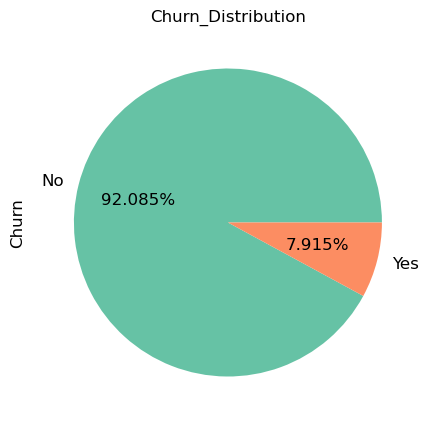

In [60]:
Churn_Distribution = Tel_high_val['churn'].value_counts(normalize=True)
colors = ['#66c2a5', '#fc8d62']

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(Churn_Distribution, labels=['No', 'Yes'], autopct='%.3f%%', colors=colors, textprops={'fontsize': 12})
ax.set_ylabel('Churn', fontsize=12)
ax.set_title('Churn_Distribution', fontsize=12)

plt.show()

### Categorical Data Analysis

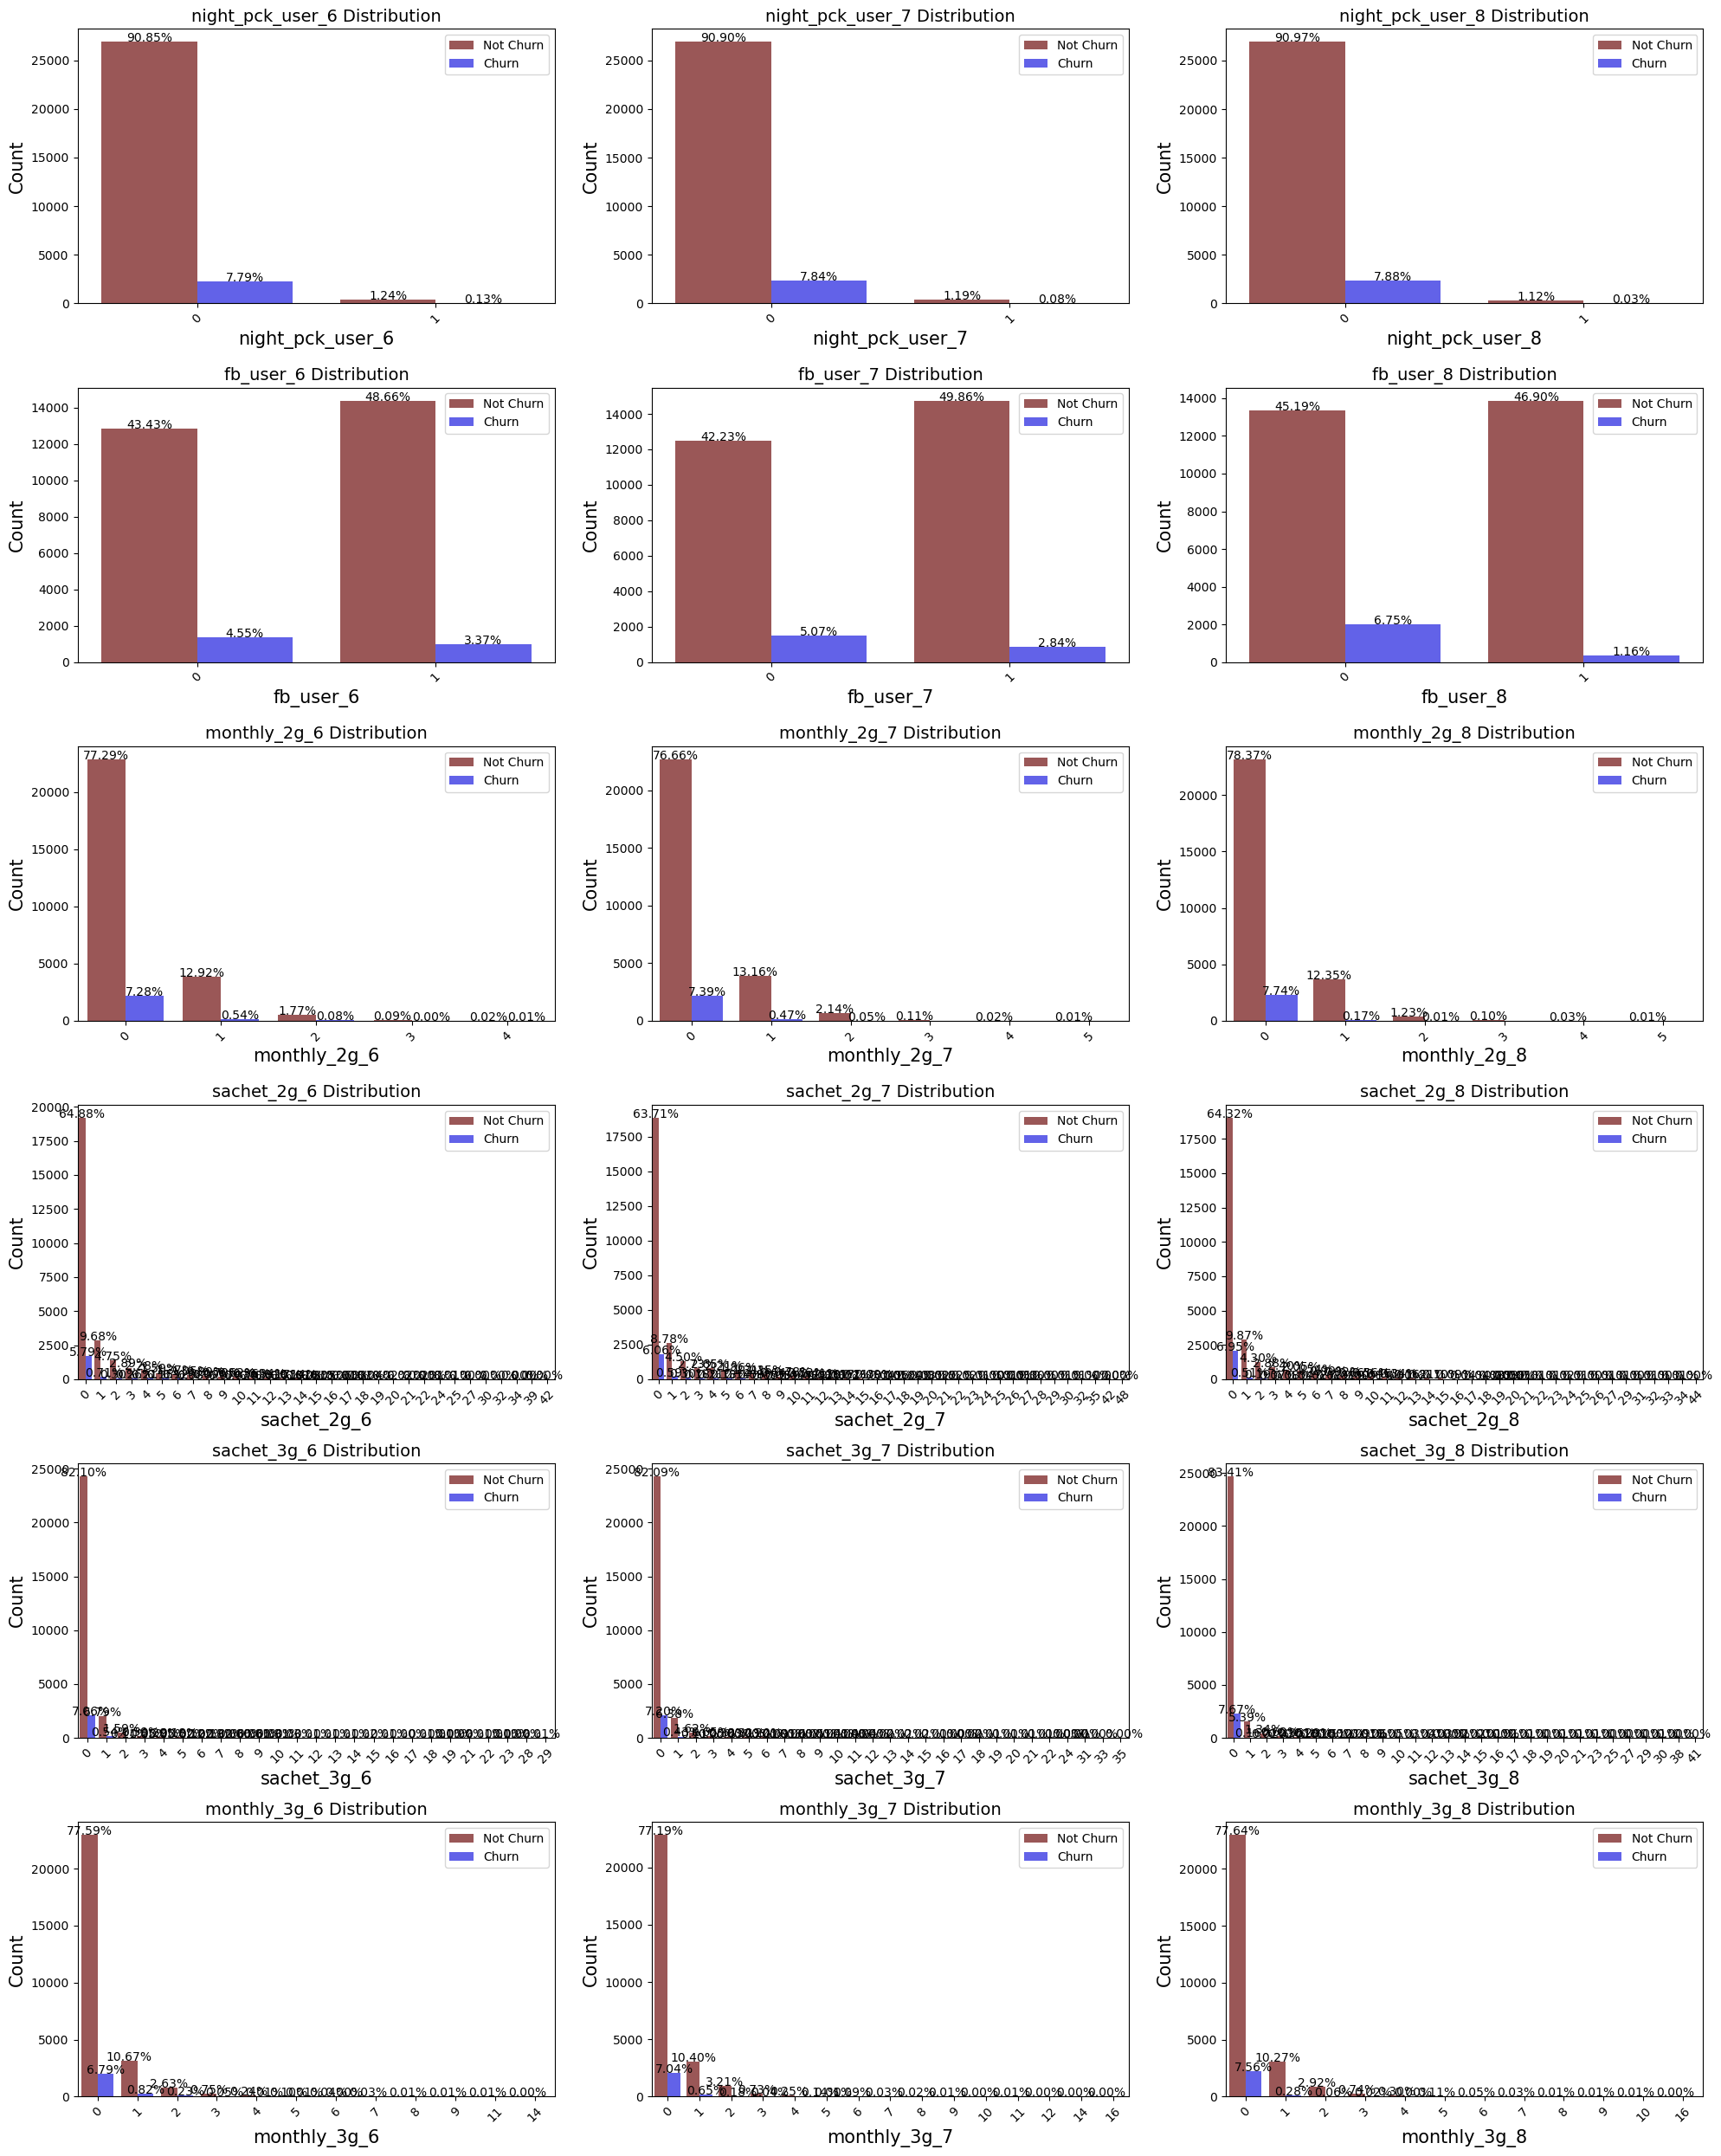

In [61]:
# Customize color palette
colors = sns.color_palette(['maroon', 'blue'])

# Plotting a countplot with all the variables
plt.figure(figsize=(20, 25))
for i, cat_col in enumerate(cat_cols):
    plt.subplot(round(len(cat_cols) / 3), 3, i + 1)
    sns.countplot(x=cat_col, alpha=0.7, data=Tel_high_val, hue='churn', palette=colors)
    plt.xticks(rotation=45)
    plt.legend(['Not Churn', 'Churn'], loc="upper right")
    plt.xlabel(cat_col, fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(f'{cat_col} Distribution', fontsize=14)
    
    # Adding annotations
    total = len(Tel_high_val)
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:  # Check if height is a valid value
            plt.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2%}'.format(height / total), ha="center", fontsize=10)

plt.tight_layout()
plt.show()


#### Insights:

- Almost 99% of users avoid nightly packs consistently over three months

- Approximately 70% refrain from sachet_2g and sachet_3g packs, with higher churn among non-users

- About 52% of users consistently avoid Facebook over the three months

- An 82% majority abstains from monthly_2g and monthly_3g packs, with minimal churn for 1-month plan users.

The count of monthly data pack subscribers is gradually decreasing over the observed months.

### Numerical Data Analysis

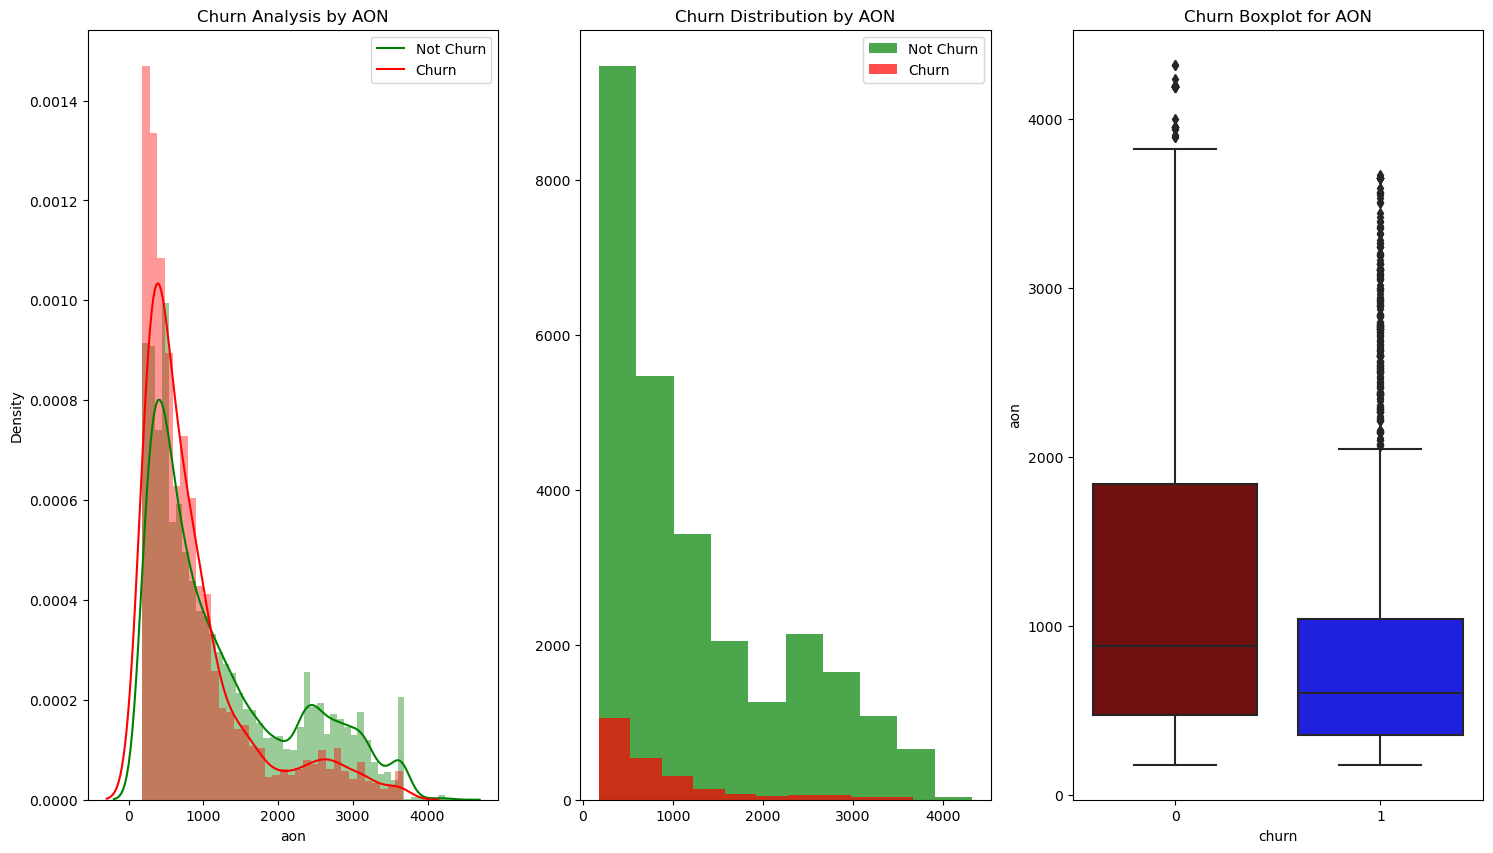

In [62]:
plt.figure(figsize=(18, 10))

# Plot 1
plt.subplot(1, 3, 1)
sns.distplot(Tel_high_val.loc[Tel_high_val['churn'] == 0, 'aon'], hist=True, color='g')
sns.distplot(Tel_high_val.loc[Tel_high_val['churn'] == 1, 'aon'], hist=True, color='r')
plt.legend(['Not Churn', 'Churn'])
plt.title('Churn Analysis by AON')

# Plot 2
plt.subplot(1, 3, 2)
plt.hist(Tel_high_val.loc[Tel_high_val['churn'] == 0, 'aon'], color='g', alpha=0.7)
plt.hist(Tel_high_val.loc[Tel_high_val['churn'] == 1, 'aon'], color='r', alpha=0.7)
plt.legend(['Not Churn', 'Churn'])
plt.title('Churn Distribution by AON')

# Plot 3
plt.subplot(1, 3, 3)
sns.boxplot(y='aon', data=Tel_high_val, x='churn', palette=['maroon', 'blue'])
plt.title('Churn Boxplot for AON')

plt.show()

#### Insights:

- Retention Insight: Longer user tenure correlates with lower churn, suggesting a potential focus area for customer retention strategies.

- Numerical Data Analysis: Exploring additional numerical data distributions beyond AON to gain a comprehensive understanding of customer behavior.

- Boxplot Observations: The boxplot illustrates that the 25th to 75th percentile range of churn customers tends to have lower values compared to non-churn customers.

- Strategic Consideration: Emphasizes the importance of understanding and leveraging user tenure as a parameter for customer retention efforts.

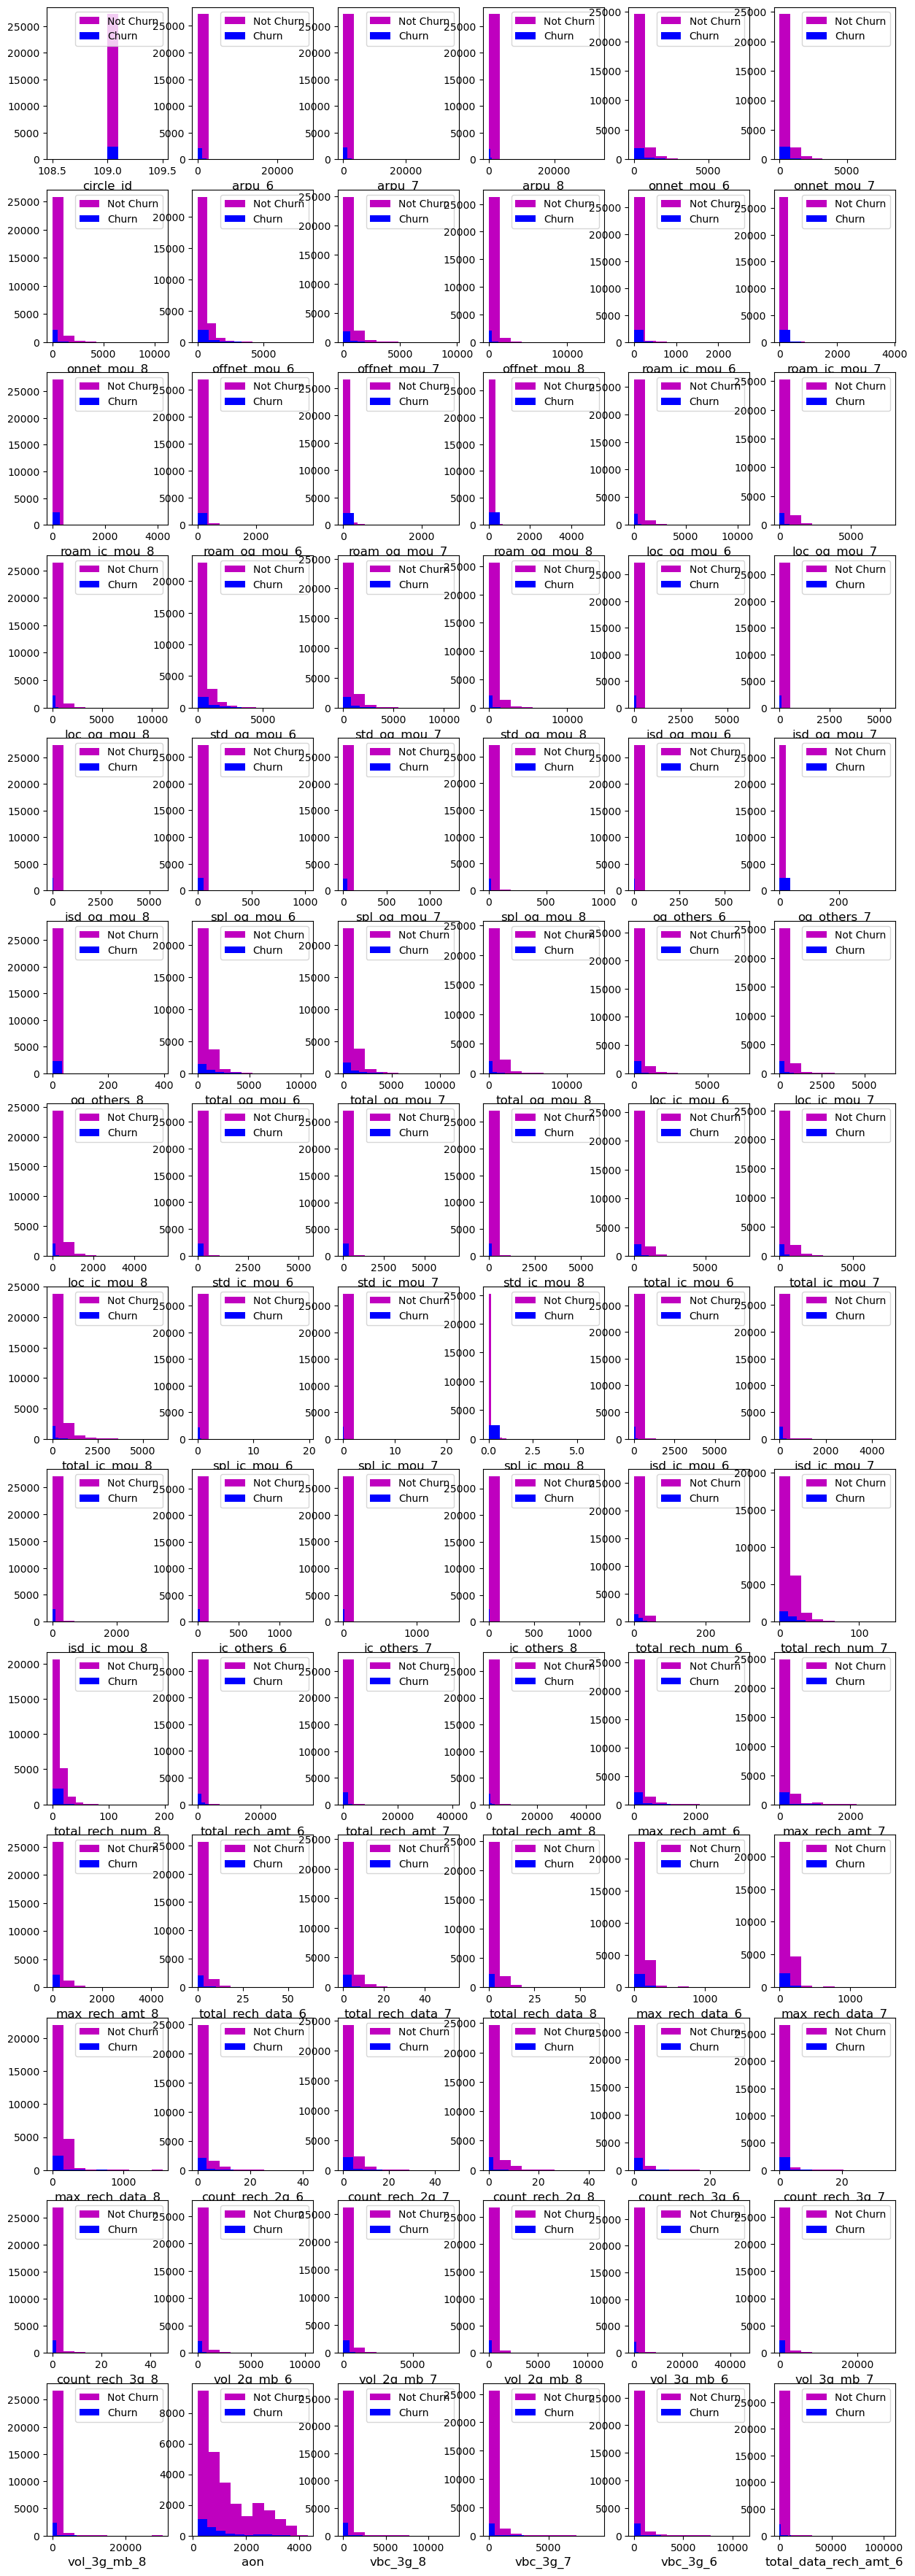

In [63]:
fig, axes = plt.subplots(round(len(num_cols) / 6), 6, figsize=(15, 45))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.hist(Tel_high_val.loc[Tel_high_val['churn']==0, num_cols[i]],color='m')
        ax.hist(Tel_high_val.loc[Tel_high_val['churn']==1, num_cols[i]],color='b')
        # adjusting font size of X-Labels and Y-Labels
        ax.set_xlabel(num_cols[i],fontsize=12)
        ax.legend(['Not Churn','Churn'],loc = 'best')        

plt.show()

### Key Insights:

- Zero ARPU Trend: Churned customers consistently exhibit zero average revenue per user (ARPU) across three months.

- Network Preference: Churned customers show fewer calls within the operator network (ONNET) but higher usage outside the network (OFFNET), indicating a dissatisfaction with internal services.

- Roaming Impact: Higher roaming calls, coupled with lower local calls, suggest that customer churn might be influenced by changes in location.

- Communication Pattern Shift: An unusual spike in special incoming calls during the 8th month for churned customers could signify a shift in communication behavior.

- Usage Dynamics: The decline in total recharge amount and the increasing trend in 3G usage among churned customers reveal important financial and connectivity aspects contributing to churn.

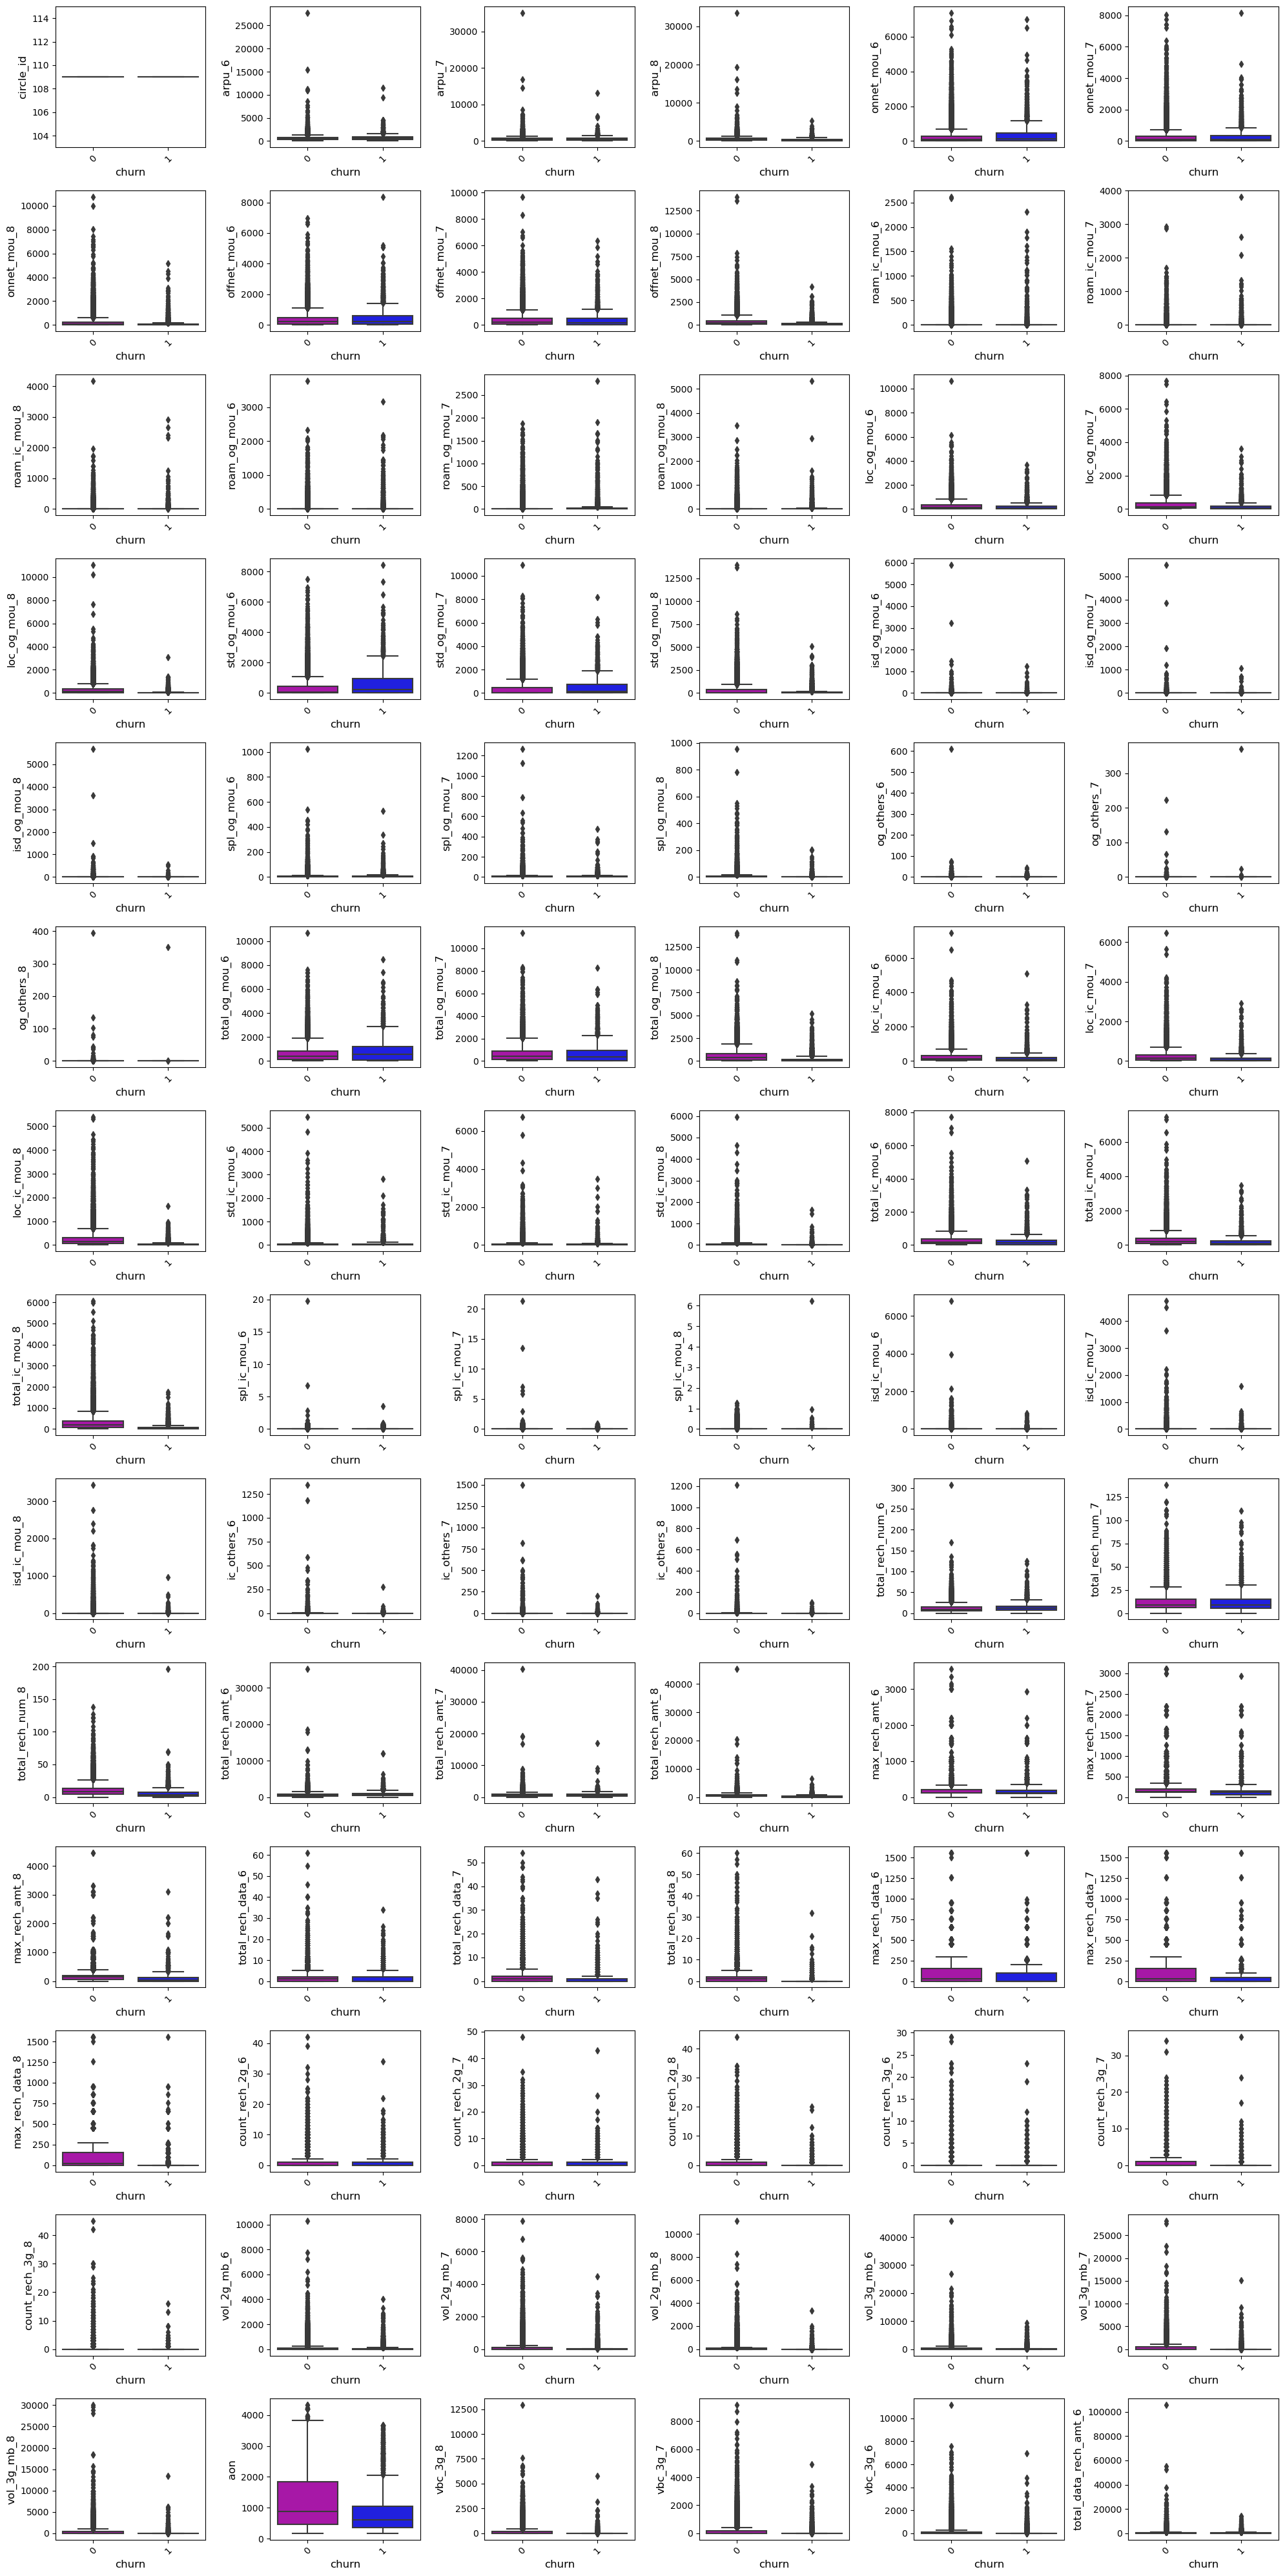

In [64]:
# Box plots for all numeric features
fig, axes = plt.subplots(round(len(num_cols) / 6), 6, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=num_cols[i], data=Tel_high_val, x='churn', ax=ax,palette = ['m','b'])
        ax.set_ylabel(num_cols[i],fontsize=12)
        ax.set_xlabel('churn',fontsize=12)

fig.tight_layout()

### Interpretation:


1.) Data Distribution and Transformation:

Outliers present, non-normal distribution.

High variance among columns, Suggested approach: Box-Cox transformation.

2.) Roaming and Call Patterns:

Higher "roam_ic_mou" for churned customers.

Similar pattern in "std_og_mou."Contrast in "roam_og_mou" for active network participants.

3.) Outgoing Call Trends:

"total_og" shows steady decrease for churned customers.

Special Incoming Calls and Churn:

Decrease in "spl_ic" in 8th month may impact churn.

4.) Recharge Behavior:

Decline in "count_rech_2g" and "count_rech_3g" during 8th month.

### Correlation matrix

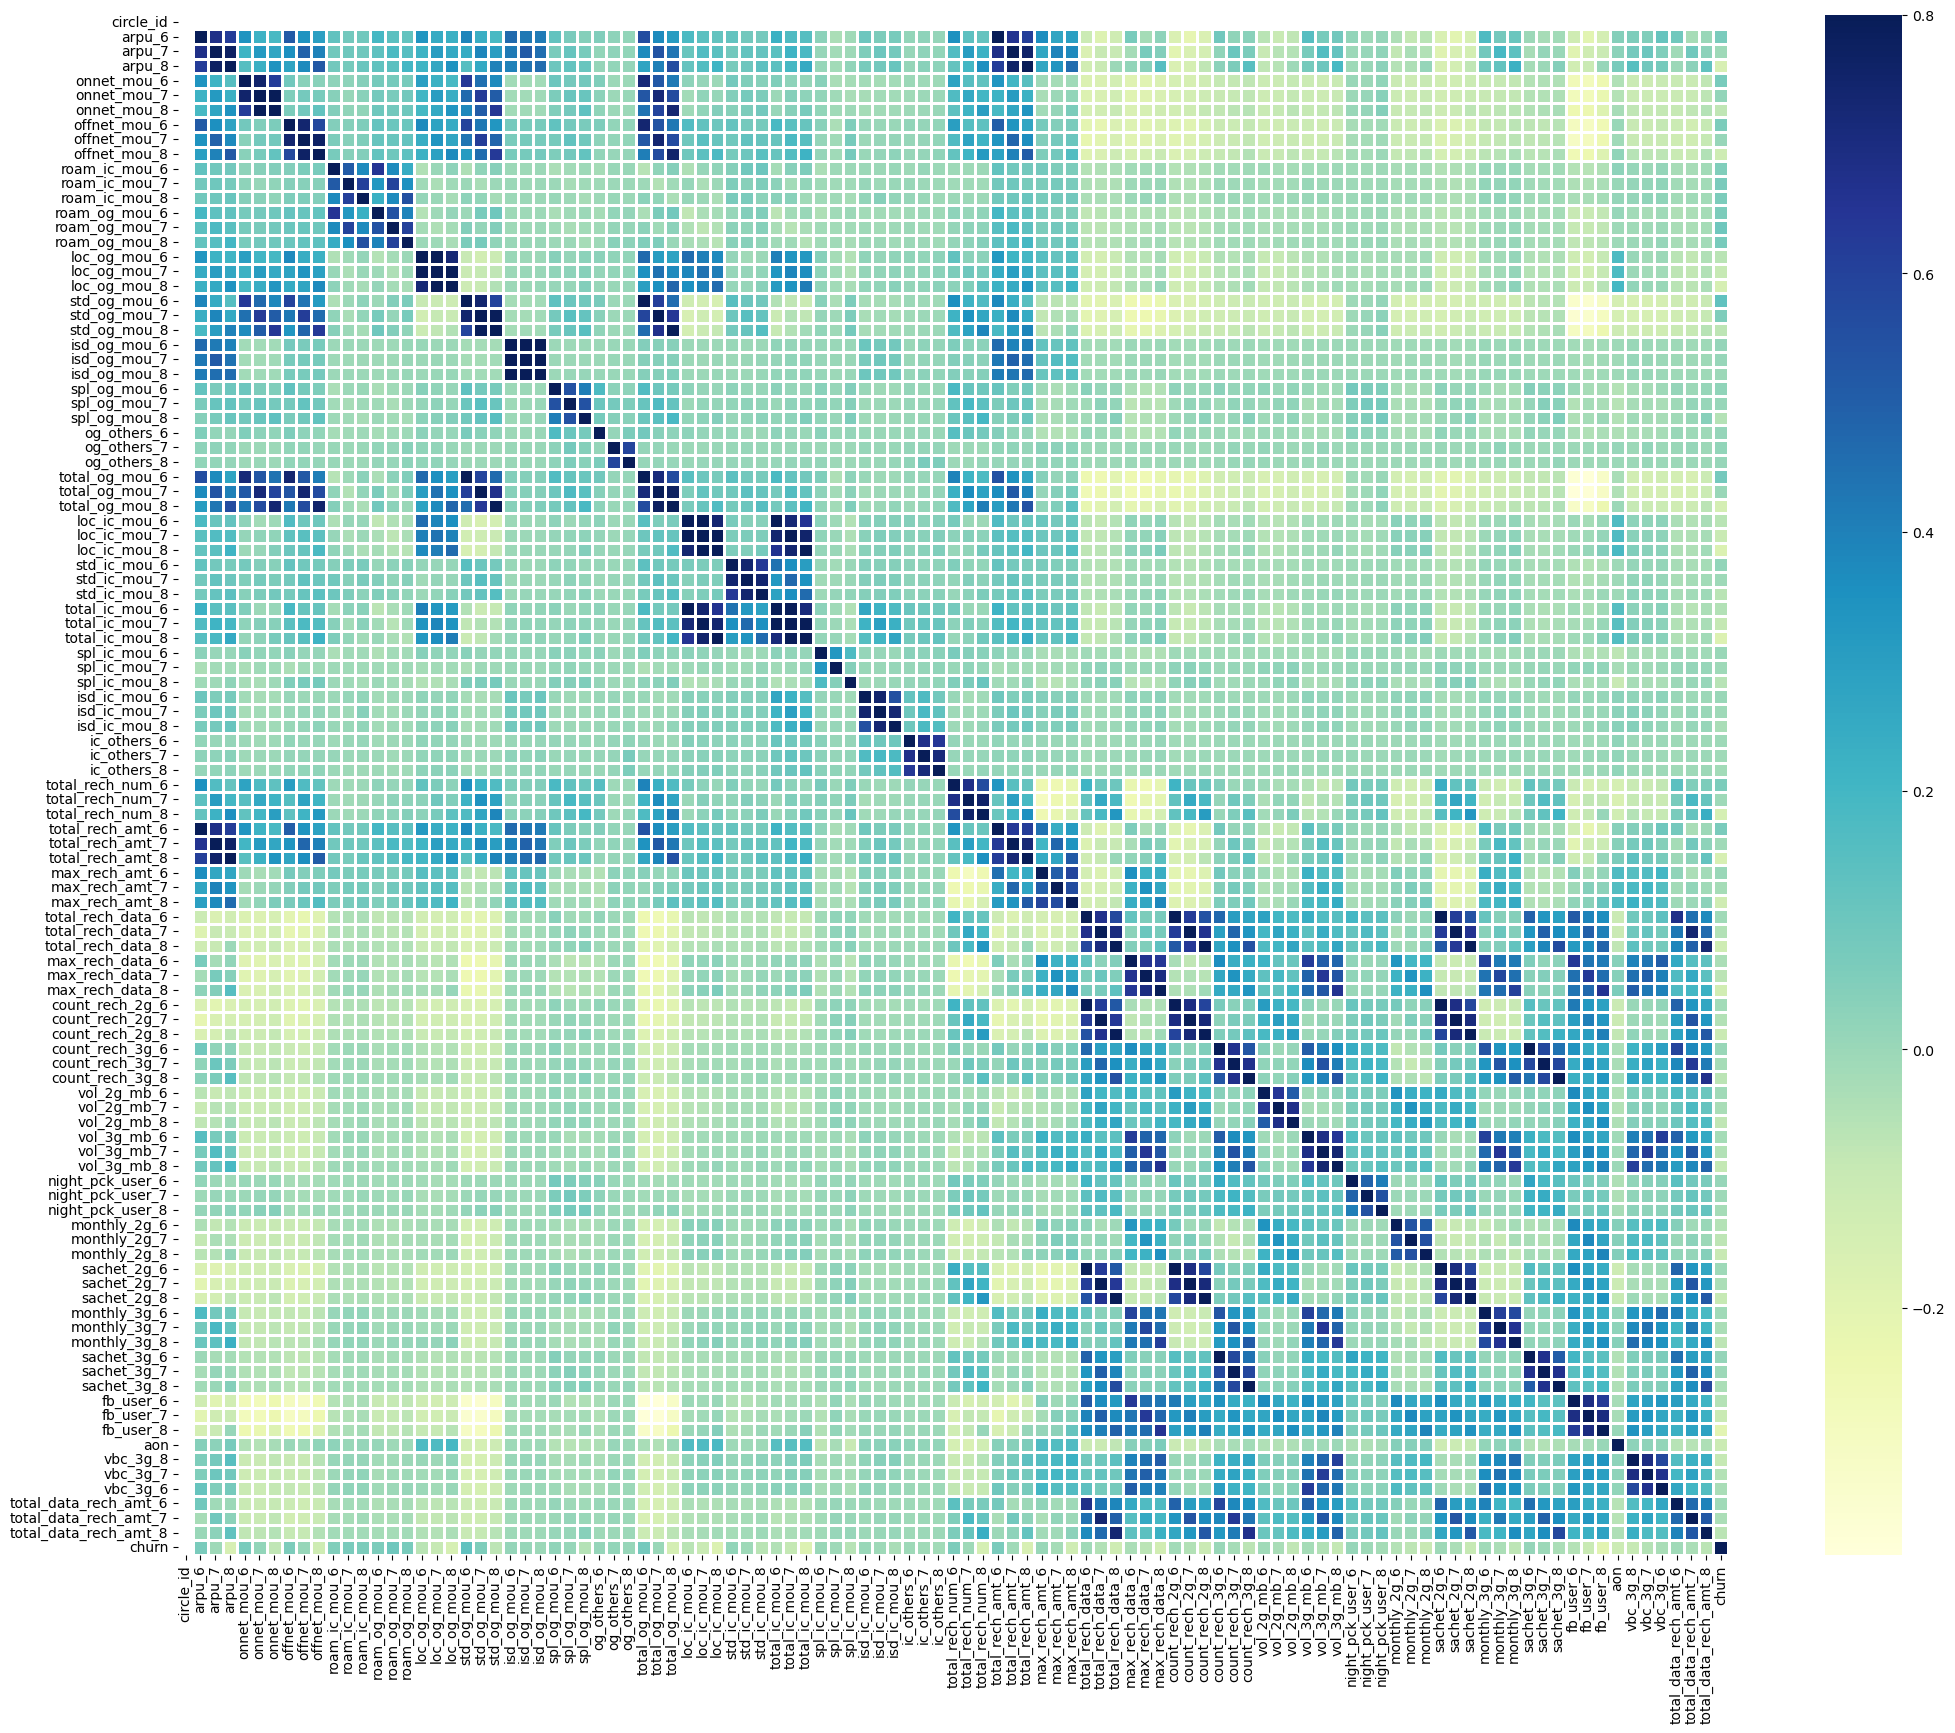

In [65]:
# Correlation matrix

corrmat = Tel_high_val.corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, vmax=.8,cmap="YlGnBu",linewidth =1)
plt.show()

In [66]:
# Top correlated features

corr_matrix = Tel_high_val.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

Highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]


print("List of Highly correlated features from the above plot - \n\n", Highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(Highly_correlated_features))

List of Highly correlated features from the above plot - 

 ['onnet_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


Total features with high correlation -  25


### Data Preparation

#### Handling - outliers:

In [67]:
skew_features = Tel_high_val[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.2]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.2 ".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})

skew_features

There are 85 numerical features with Skew > 0.2 


og_others_7              111.136693
og_others_6              109.666418
og_others_8               99.486834
isd_og_mou_8              88.957842
isd_og_mou_6              87.011130
isd_og_mou_7              83.406637
spl_ic_mou_7              72.455557
ic_others_6               58.476965
ic_others_8               46.938700
ic_others_7               44.139529
spl_ic_mou_6              41.540185
isd_ic_mou_6              34.696418
isd_ic_mou_7              24.405269
total_data_rech_amt_6     22.639450
spl_og_mou_7              19.449973
total_data_rech_amt_8     19.062494
roam_ic_mou_8             18.590514
total_rech_amt_8          18.073139
arpu_7                    17.681620
isd_ic_mou_8              17.417915
roam_ic_mou_7             17.264460
total_rech_amt_7          16.200891
arpu_8                    15.417555
spl_og_mou_6              15.414604
roam_og_mou_8             14.479325
spl_og_mou_8              14.429340
std_ic_mou_7              13.514776
total_rech_amt_6          13

In [68]:
# Boxcox transformation for numerical variables 

for i in skew_index:
    Tel_high_val[i] = boxcox1p(Tel_high_val[i], boxcox_normmax(Tel_high_val[i] + 1))

#### Boxplot visualization after Box-cox transformation

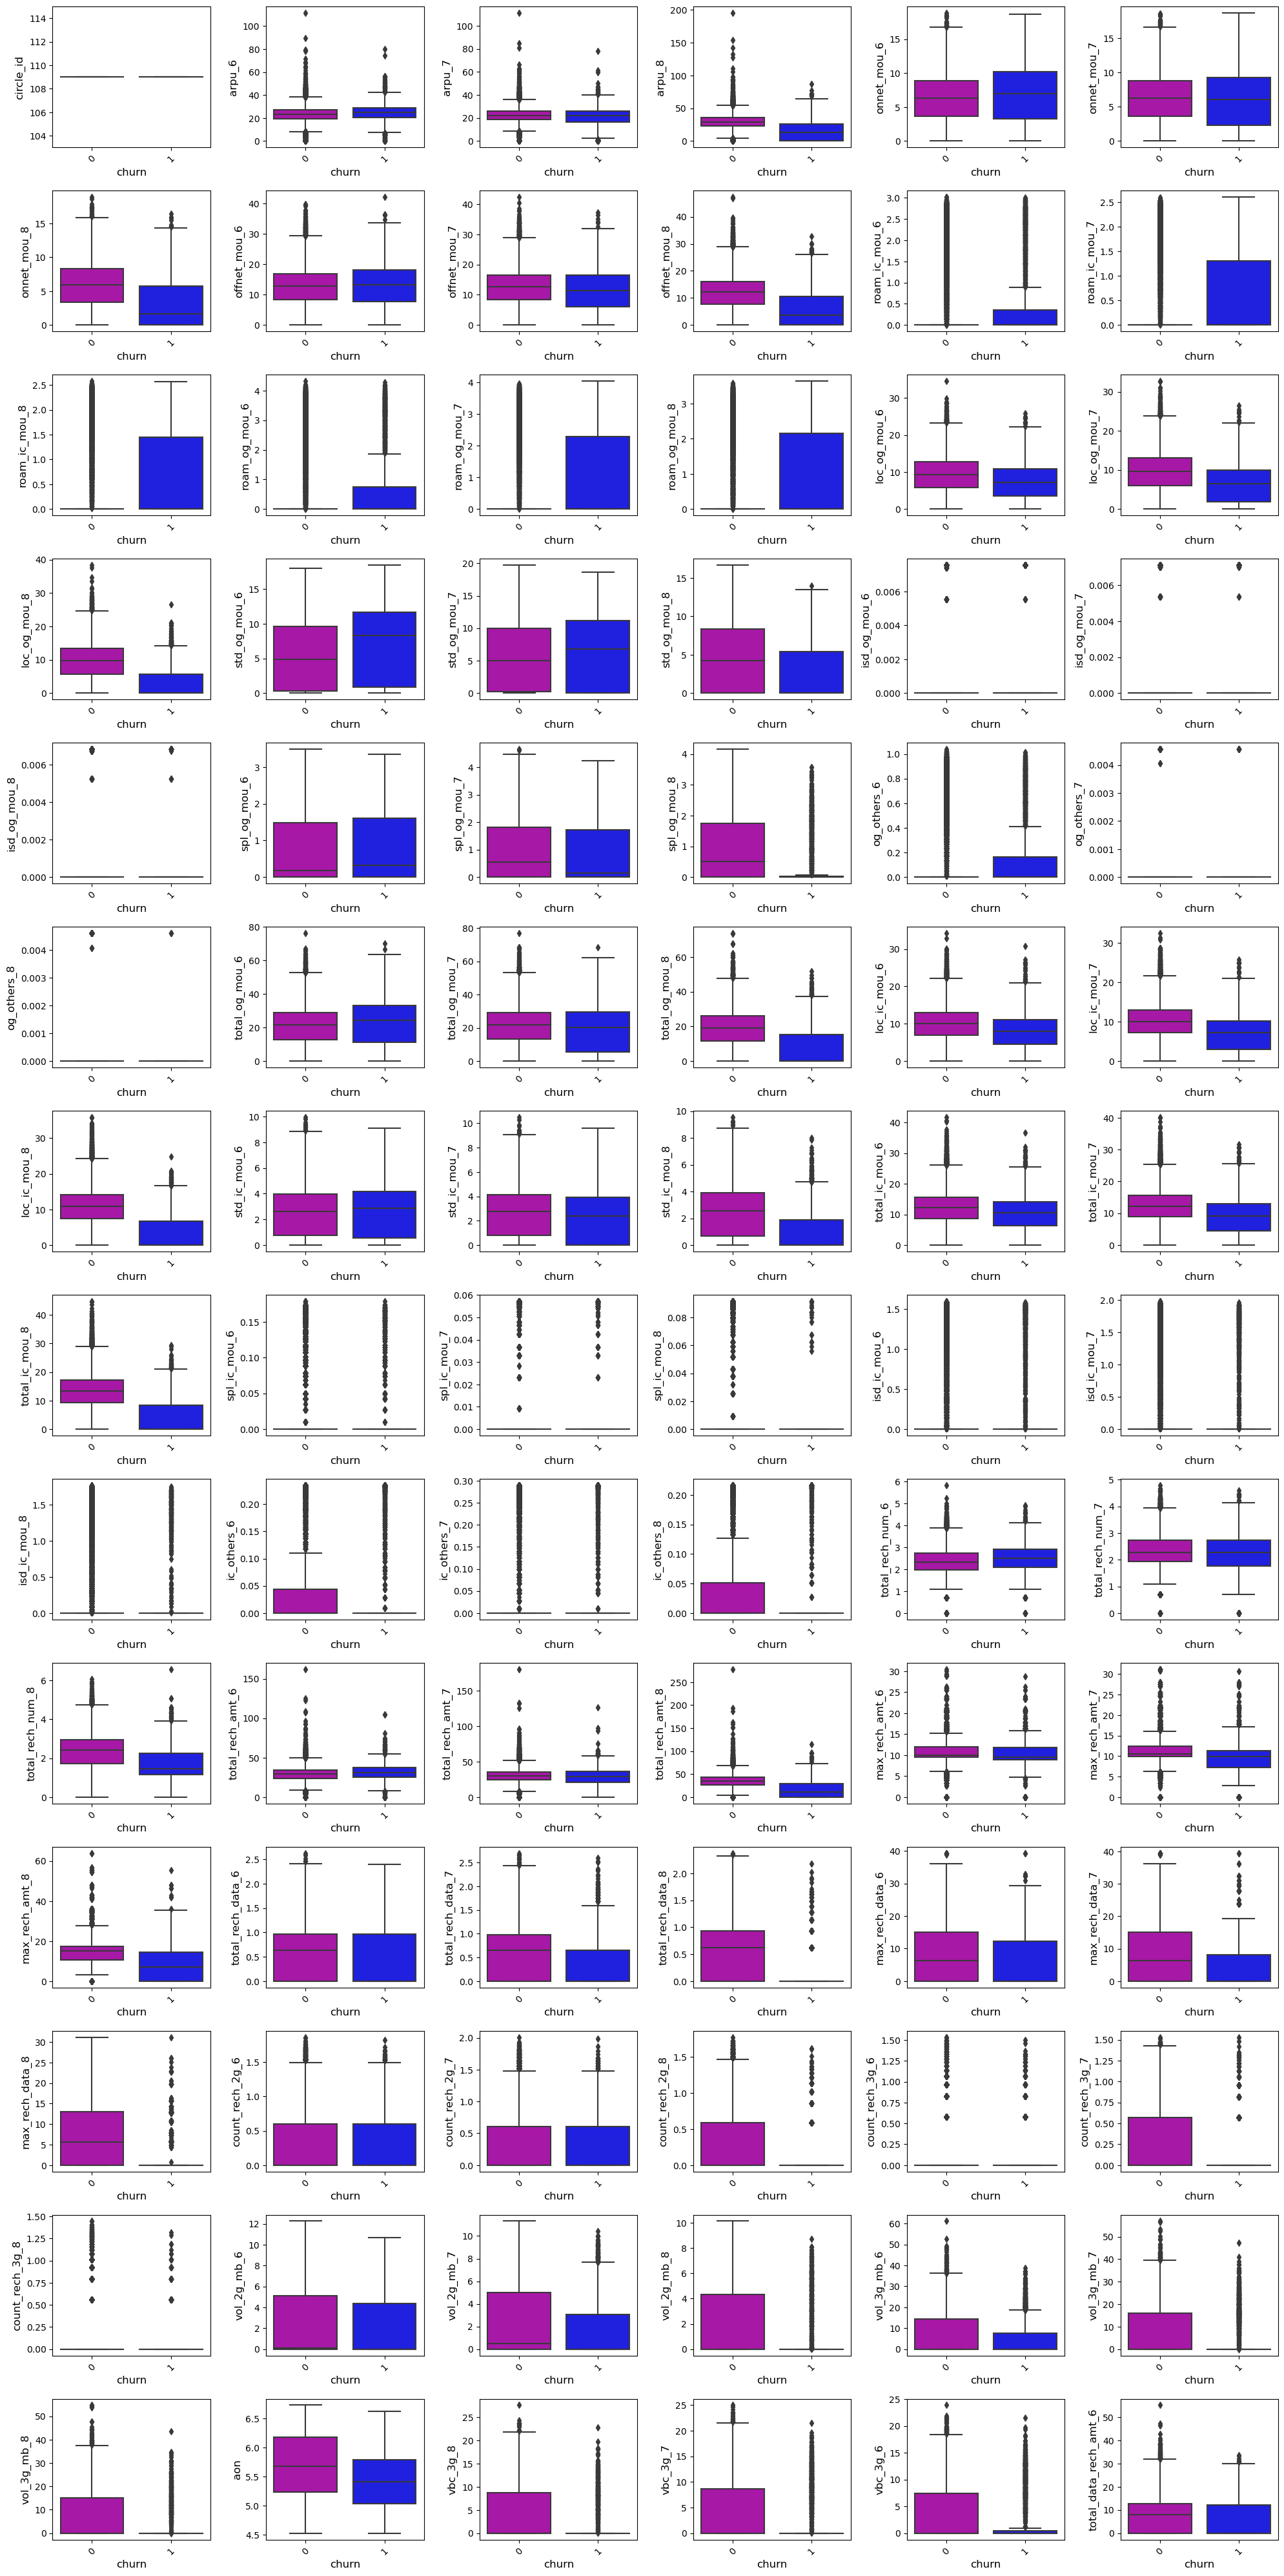

In [69]:
# Create box plots for all numeric features

fig, axes = plt.subplots(round(len(num_cols) / 6), 6, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    if i < len(num_cols):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=num_cols[i], data=Tel_high_val, x='churn', ax=ax,palette = ['m','b'])
        ax.set_ylabel(num_cols[i],fontsize=12)
        ax.set_xlabel('churn',fontsize=12)

fig.tight_layout()
plt.show()

### Feature Engineering

In [70]:
Tel_high_val.columns

Index(['circle_id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'fb_user_7', 'fb_user_8', 'aon', 'vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6',
       'total_data_rech_amt_6', 'total_data_rech_amt_7',
       'total_data_rech_amt_8', 'churn'],
      dtype='object', length=105)

#### Approach:

- Month 6 and 7th are good phase. We will use a average value of Month 6 and 7 to determine goodphase values. 

- This will also reduce the number of features for model building.

In [71]:
def good_action_phase(df, col):
    
    col_6 = col + "_6"
    col_7 = col + "_7"
    col_8 = col + "_8"
    good_phase_col = col + "_good_phase"
    action_phase_col = col + "_action_phase"
    
    df[good_phase_col] = (df[col_6] + df[col_7])/2
    df[action_phase_col] = df[col_8]
    
    df.drop([col_6, col_7, col_8], axis = 1, inplace = True)
    
    return df

In [72]:
# Creating features for good phase and action phase column : 

cols = ["arpu","onnet_mou","offnet_mou","roam_ic_mou","roam_og_mou","loc_og_mou","std_og_mou",
        "isd_og_mou","spl_og_mou","og_others","total_og_mou","loc_ic_mou","std_ic_mou",
        "spl_ic_mou","isd_ic_mou","ic_others","total_ic_mou","total_rech_num","total_rech_amt",
        "max_rech_amt","total_rech_data","max_rech_data","count_rech_2g","count_rech_3g",
        "vol_2g_mb","vol_3g_mb","monthly_2g","sachet_2g","sachet_3g",
        "monthly_3g","vbc_3g","total_data_rech_amt"]

for col in cols : 
    Tel_high_val = good_action_phase(Tel_high_val, col)
    print (col)

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_ic_mou
total_rech_num
total_rech_amt
max_rech_amt
total_rech_data
max_rech_data
count_rech_2g
count_rech_3g
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
sachet_3g
monthly_3g
vbc_3g
total_data_rech_amt


In [73]:
### Checking the df:

Tel_high_val.head()

circle_id  night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  \
0        109                 0                 0                 0          1   
1        109                 0                 0                 0          0   
2        109                 0                 0                 0          0   
3        109                 0                 0                 0          0   
4        109                 0                 0                 0          0   

   fb_user_7  fb_user_8       aon  churn  arpu_good_phase  arpu_action_phase  \
0          1          1  5.742221      1        16.081833          20.713069   
1          0          0  5.612021      1        32.670623          70.113933   
2          1          1  4.945874      0        21.795479          16.778963   
3          0          0  5.536787      0        24.097626          34.307604   
4          1          1  5.413330      0        12.945043          26.644541   

   onnet_mou_good_phase  onnet_mou_action_phase  offnet_mou_good_phase  \
0              0.000000                0.000000               0.000000   
1              5.555118                5.302856              16.895627   
2              9.568582                4.644254               8.971096   
3              6.937999                6.164248              19.875305   
4              5.338160                4.574672               8.963148   

   offnet_mou_action_phase  roam_ic_mou_good_phase  roam_ic_mou_action_phase  \
0                 0.000000                0.000000                  0.000000   
1                14.349754                1.951452                  1.958364   
2                10.516335                0.000000                  0.000000   
3                20.768193                0.000000                  0.000000   
4                12.210779                0.000000                  0.000000   

   roam_og_mou_good_phase  roam_og_mou_action_phase  loc_og_mou_good_phase  \
0                0.000000                  0.000000               0.000000   
1                2.245214                  2.439742              14.349622   
2                0.000000                  0.000000              12.773657   
3                0.000000                  0.000000               8.394549   
4                0.000000                  0.000000               9.429599   

   loc_og_mou_action_phase  std_og_mou_good_phase  std_og_mou_action_phase  \
0                 0.000000               0.000000                 0.000000   
1                12.252005               5.829424                 5.579032   
2                 7.419760               7.176628                 5.952949   
3                 9.688926              11.403356                10.130424   
4                10.913341               1.818925                 4.553437   

   isd_og_mou_good_phase  isd_og_mou_action_phase  spl_og_mou_good_phase  \
0               0.000000                 0.000000               0.000000   
1               0.003566                 0.006833               0.706747   
2               0.000000                 0.000000               0.000000   
3               0.000000                 0.000000               0.000000   
4               0.002682                 0.000000               0.047143   

   spl_og_mou_action_phase  og_others_good_phase  og_others_action_phase  \
0                 0.000000                   0.0                     0.0   
1                 1.722190                   0.0                     0.0   
2                 2.005312                   0.0                     0.0   
3                 0.000000                   0.0                     0.0   
4                 2.338095                   0.0                     0.0   

   total_og_mou_good_phase  total_og_mou_action_phase  loc_ic_mou_good_phase  \
0                 0.000000                   0.000000               0.000000   
1                24.123337                  18.781592              14.011507   
2                

In [74]:
#Checking the shape of the dataframe

Tel_high_val.shape

(29591, 73)

### Train- Test Split

In [75]:
#Target variable

X = Tel_high_val.drop('churn', axis = 1)
y = Tel_high_val[['churn']]

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

#Checkiong the shape of the created Train & Test DFs
print(" Shape of X_train is : ",X_train.shape)
print(" Shape of y_train is : ",y_train.shape)
print(" Shape of X_test is  : ",X_test.shape)
print(" Shape of y_test is  : ",y_test.shape)

 Shape of X_train is :  (20713, 72)
 Shape of y_train is :  (20713, 1)
 Shape of X_test is  :  (8878, 72)
 Shape of y_test is  :  (8878, 1)


### Feature Scaling

In [76]:
feature_col =[]
data_col = Tel_high_val.columns.to_list()

for col in data_col:
    if Tel_high_val[col].nunique() > 2:
        feature_col.append(col)
        
feature_col

['aon',
 'arpu_good_phase',
 'arpu_action_phase',
 'onnet_mou_good_phase',
 'onnet_mou_action_phase',
 'offnet_mou_good_phase',
 'offnet_mou_action_phase',
 'roam_ic_mou_good_phase',
 'roam_ic_mou_action_phase',
 'roam_og_mou_good_phase',
 'roam_og_mou_action_phase',
 'loc_og_mou_good_phase',
 'loc_og_mou_action_phase',
 'std_og_mou_good_phase',
 'std_og_mou_action_phase',
 'isd_og_mou_good_phase',
 'isd_og_mou_action_phase',
 'spl_og_mou_good_phase',
 'spl_og_mou_action_phase',
 'og_others_good_phase',
 'og_others_action_phase',
 'total_og_mou_good_phase',
 'total_og_mou_action_phase',
 'loc_ic_mou_good_phase',
 'loc_ic_mou_action_phase',
 'std_ic_mou_good_phase',
 'std_ic_mou_action_phase',
 'spl_ic_mou_good_phase',
 'spl_ic_mou_action_phase',
 'isd_ic_mou_good_phase',
 'isd_ic_mou_action_phase',
 'ic_others_good_phase',
 'ic_others_action_phase',
 'total_ic_mou_good_phase',
 'total_ic_mou_action_phase',
 'total_rech_num_good_phase',
 'total_rech_num_action_phase',
 'total_rech_amt_g

In [77]:
# Using StandardScaler for Scaling the X_train and X_test
scaler = StandardScaler()

scaled_data = scaler.fit_transform(X_train[feature_col])

X_train[feature_col] = scaler.fit_transform(X_train[feature_col])
X_test[feature_col] = scaler.transform(X_test[feature_col])

# Checking the scaled dataframe
X_train.head()

circle_id  night_pck_user_6  night_pck_user_7  night_pck_user_8  \
28117        109                 0                 0                 0   
1574         109                 0                 0                 0   
22863        109                 0                 0                 0   
8840         109                 0                 0                 0   
6279         109                 0                 0                 0   

       fb_user_6  fb_user_7  fb_user_8       aon  arpu_good_phase  \
28117          1          1          1 -0.528861        -0.467471   
1574           1          1          1  0.233154        -0.818194   
22863          1          1          1  0.548641        -0.452190   
8840           1          1          1 -1.843725         0.146634   
6279           1          1          1  1.354596        -0.565391   

       arpu_action_phase  onnet_mou_good_phase  onnet_mou_action_phase  \
28117          -0.319068             -1.051506               -1.047610   
1574           -0.430065             -1.347858               -1.281932   
22863          -0.813731             -0.237607               -0.641922   
8840           -0.187263              1.042633                0.866636   
6279           -0.819506             -1.199350               -1.551369   

       offnet_mou_good_phase  offnet_mou_action_phase  roam_ic_mou_good_phase  \
28117              -0.597360                -0.154047                -0.54328   
1574               -0.214108                -0.501223                -0.54328   
22863              -0.686547                -0.581803                -0.54328   
8840               -0.291516                 0.025460                -0.54328   
6279               -1.015964                -1.490175                -0.54328   

       roam_ic_mou_action_phase  roam_og_mou_good_phase  \
28117                  -0.44171               -0.545471   
1574                   -0.44171               -0.545471   
22863                  -0.44171               -0.545471   
8840                   -0.44171               -0.545471   
6279                   -0.44171               -0.545471   

       roam_og_mou_action_phase  loc_og_mou_good_phase  \
28117                 -0.440755              -0.158734   
1574                  -0.440755              -0.050150   
22863                 -0.440755              -0.019972   
8840                  -0.440755               1.241791   
6279                  -0.440755              -0.855093   

       loc_og_mou_action_phase  std_og_mou_good_phase  \
28117                 0.156611              -1.208238   
1574                 -0.711955              -1.099441   
22863                -0.484903              -1.208238   
8840                  1.060244              -0.721129   
6279                 -1.585997              -0.930993   

       std_og_mou_action_phase  isd_og_mou_good_phase  \
28117                -1.102076              -0.337428   
1574                 -0.056580              -0.337428   
22863                -1.102076              -0.337428   
8840                 -0.250553              -0.337428   
6279                 -0.820039              -0.337428   

       isd_og_mou_action_phase  spl_og_mou_good_phase  \
28117                -0.259076              -1.026313   
1574                 -0.259076               2.115867   
22863                -0.259076               1.237381   
8840                 -0.259076               0.412287   
6279                 -0.259076               1.349448   

       spl_og_mou_action_phase  og_others_good_phase  og_others_action_phase  \
28117                -0.864140             -0.503468               -0.076965   
1574                  1.540091              1.481465               -0.076965   
22863                 1.920525             -0.503468               -0.076965   
8840                 -0.864140             -0.503468               -0.076965   
6279                 -0.146499             -0.503468               -0.076965   

 

In [78]:
# Checking the dataframe after scaling:

X_test.head()

circle_id  night_pck_user_6  night_pck_user_7  night_pck_user_8  \
3945         109                 0                 0                 0   
18981        109                 0                 0                 0   
24100        109                 0                 0                 0   
25300        109                 0                 0                 0   
15026        109                 0                 0                 0   

       fb_user_6  fb_user_7  fb_user_8       aon  arpu_good_phase  \
3945           0          0          0 -0.126491         0.031503   
18981          0          0          0 -0.766292         0.401345   
24100          0          0          0  0.807275        -1.233034   
25300          1          1          1  0.671698         1.238497   
15026          1          1          1 -1.165471        -1.501047   

       arpu_action_phase  onnet_mou_good_phase  onnet_mou_action_phase  \
3945            0.198380              1.404110                1.512551   
18981           1.028519              0.505724                1.320249   
24100           0.217727              0.152057                0.460959   
25300           1.044121              0.037504                0.316263   
15026          -0.270186             -1.662726               -1.551369   

       offnet_mou_good_phase  offnet_mou_action_phase  roam_ic_mou_good_phase  \
3945               -0.850806                -0.266763               -0.543280   
18981               1.138970                 1.734024                0.780640   
24100               0.132609                 0.310991                1.408633   
25300               0.658094                 0.794836                2.537277   
15026              -1.442818                -1.555746               -0.543280   

       roam_ic_mou_action_phase  roam_og_mou_good_phase  \
3945                  -0.441710               -0.545471   
18981                 -0.441710                1.001603   
24100                  0.802457                1.958513   
25300                  2.386037                2.070175   
15026                 -0.441710               -0.545471   

       roam_og_mou_action_phase  loc_og_mou_good_phase  \
3945                  -0.440755              -0.976885   
18981                 -0.440755              -0.213913   
24100                  1.623131              -0.330329   
25300                  1.449200               1.125470   
15026                 -0.440755              -1.150212   

       loc_og_mou_action_phase  std_og_mou_good_phase  \
3945                 -1.008852               1.219854   
18981                 0.567866               1.170303   
24100                 0.023565               0.668732   
25300                 1.274169              -1.061022   
15026                -1.585997              -1.208238   

       std_og_mou_action_phase  isd_og_mou_good_phase  \
3945                  1.393512              -0.337428   
18981                 1.700215              -0.337428   
24100                 0.845012              -0.337428   
25300                -0.616228              -0.337428   
15026                -1.102076              -0.337428   

       isd_og_mou_action_phase  spl_og_mou_good_phase  \
3945                 -0.259076               0.409806   
18981                -0.259076               0.373077   
24100                -0.259076              -1.026313   
25300                -0.259076               1.516538   
15026                -0.259076              -0.207703   

       spl_og_mou_action_phase  og_others_good_phase  og_others_action_phase  \
3945                 -0.313011             -0.503468               -0.076965   
18981                 0.982632             -0.503468               -0.076965   
24100                -0.864140             -0.503468               -0.076965   
25300                -0.864140             -0.503468               -0.076965   
15026                 0.163114             -0.503468               -0.076965   

 

#### Data Imbalance Treatment

The following algorithms will be used for treating the imbalanced data set.

1.)Random Under Sampling : involved randomly selecting examples from the majority class and deleting them from the training dataset.

2.) Over Sampling :
- Random Over Sampling : generates new samples by random resampling with replacement of under represented class

- Synthetic Minority Oversampling (SMOTE): works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

3.) Combined Under & Over Sampling :

- SMOTEENN : SMOTE + Edited NearestNeighbors

- SMOTETomek: SMOTE + Tomek Links

SMOTE allows to generate samples. 
However, this method of over-sampling does not have any knowledge regarding the underlying distribution. Therefore, some noisy samples can be generated, e.g. when the different classes cannot be well separated. Hence, it can be beneficial to apply an under-sampling algorithm to clean the noisy samples. Imbalanced-learn provides two ready-to-use combined samplers: SMOTEENN and SMOTETomek.

SMOTEENN is more aggressive at downsampling the majority class than Tomek Links, providing more in-depth cleaning. They apply the method, removing examples from both the majority and minority classes.

It is not possible to check different sampling techniques on very cost sensitive Machine Learning models like SVM, Decision Trees, Random Forest.

For this Case Study, we we can use SMOTE or SMOTEENN sampling technique to handle imbalanced dataset as it is uses both over-sampling and under-sampling method and helps in cleaning noisy samples.

#### Different sampling techniques to handle class-Imbalance:

In [79]:
from imblearn.combine import SMOTEENN

# oversampling minority class using SMOTE - SMOTEENN
sampling = SMOTEENN(random_state=0)
X_train_resampled, y_train_resampled = sampling.fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(data=X_train_resampled)
y_train_resampled = pd.DataFrame(data=y_train_resampled)

print("Shape of the X_train after resampling:", X_train_resampled.shape)
print("Shape of the Y_train after resampling:", y_train_resampled.shape)

Shape of the X_train after resampling: (34146, 72)
Shape of the Y_train after resampling: (34146, 1)


In [80]:
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(n_jobs=-1, random_state=100)
X_smote_samples, y_smote_samples = smote.fit_resample(X_train, y_train)

print("Shape of the X_train after SMOTE:", X_smote_samples.shape)
print("Shape of the Y_train after SMOTE:", y_smote_samples.shape)


Shape of the X_train after SMOTE: (38134, 72)
Shape of the Y_train after SMOTE: (38134, 1)


In [81]:
# RandomOverSampler

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=100)
X_r_over_sampled, y_r_over_sampled = ros.fit_resample(X_train, y_train)

print("Shape of the X_train after Random Over Sampling:", X_r_over_sampled.shape)
print("Shape of the Y_train after Random Over Sampling:", y_r_over_sampled.shape)

Shape of the X_train after Random Over Sampling: (38134, 72)
Shape of the Y_train after Random Over Sampling: (38134, 1)


In [82]:
from imblearn.under_sampling import RandomUnderSampler

# RandomUnderSampler
rus = RandomUnderSampler(random_state=100)
X_r_under_sampled, y_r_under_sampled = rus.fit_resample(X_train, y_train)

print("Shape of the X_train after Random Under Sampling:", X_r_under_sampled.shape)
print("Shape of the Y_train after Random Under Sampling:", y_r_under_sampled.shape)

Shape of the X_train after Random Under Sampling: (3292, 72)
Shape of the Y_train after Random Under Sampling: (3292, 1)


### Model Building

### Approach:

Objective: The primary goal is to identify high-value customers with the potential to churn, emphasizing the need to minimize False Negatives. The focus is on maximizing the Recall value, trading off Precision to achieve this objective.

Models for Consideration:

- Logistic Regression
- Random Forest

Handling Imbalanced Data:

-RandomUnderSampler
-RandomOverSampler
-SMOTE
-SMOTEENN

Feature Selection:

- Addressing multicollinearity through correlation analysis.
- Employing Recursive Feature Elimination (RFE) to identify impactful features.
- Acknowledging that RFE alone doesn't guarantee the absence of multicollinearity.

Logistic Regression Model:
- Incorporating Principal Component Analysis (PCA) for dimension reduction.

Other Models:
- For models less affected by multicollinearity, utilizing the original dataset.
- Applying SMOTEENN for imbalance treatment.
- Employing Hyper-Parameter Tuning using GridSearchCV.

- Preventing Overtraining:

Ensuring model conservatism by limiting the number of components in each model.
Striving to strike a balance between model performance and avoiding overtraining.

## Confusion Matrix

|                    | Predicted Negative (0) | Predicted Positive (1) |
|--------------------|------------------------|------------------------|
| **Actual Negative (0)** | True Negative (TN)    | False Positive (FP)   |
| **Actual Positive (1)** | False Negative (FN)   | True Positive (TP)    |

### Formulas:

- **Accuracy:** (TP + TN) / (TP + TN + FP + FN)

- **Precision:** TP/(TP + FP)

- **Recall:** TP/(TP + FN)

### Rates:

- **True Positive Rate (TPR):** TP/(TP + FN)

- **True Negative Rate (TNR):** TN/(TN + FP)

- **False Positive Rate (FPR):** FP/(TN + FP)

- **False Negative Rate (FNR):** FN/(TP + FN)

### Combined Metric:

- **F1 Score:**  2* ( Precision * Recall ) / (Precision + Recall)

### Note

#### Build models using Logistic regression and Random forest

In [83]:
### RFE:

def run_rfe_on_logistic(X_train, y_train, no_of_features):
    logreg = LogisticRegression()
    rfe = RFE(logreg, n_features_to_select=no_of_features)  # running RFE with the given number of variables as output
    rfe = rfe.fit(X_train, y_train)
    col = X_train.columns[rfe.support_]
    return col

In [84]:
# Build the logistic model with StatsModels 
def build_logistic_model(X_train_logistic,Y_train_logistic):
    X_train_sm = sm.add_constant(X_train_logistic)
    logistic_model = sm.GLM(Y_train_logistic,X_train_sm, family = sm.families.Binomial())
    logistic_model = logistic_model.fit()
    return logistic_model, X_train_sm

In [85]:
# Function for plotting precision, recall , accuracy curve 
def predict_train_using_logistic_model(logistic_model, X_train_sm, y_train):
    y_train_pred = logistic_model.predict(X_train_sm)
    y_train_pred = y_train_pred.values.reshape(-1)
    y_train_actual = y_train.values.reshape(-1)
    y_train_pred_final = pd.DataFrame({'Churn_Actual':y_train_actual, 'Churn_pred_prob':y_train_pred})
    
    # create metrics DF for different cut off
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final['Churn_pred_prob'].map(lambda x: 1 if x > i else 0)
        
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    metrics_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci','prec','rec'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_pred_final['Churn_Actual'], y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        prec = cm1[1,1] / (cm1[1,1] + cm1[0,1])
        rec = cm1[1,1] / (cm1[1,0] + cm1[1,1])
        metrics_df.loc[i] =[ i ,accuracy,sensi,speci, prec, rec]
        
    plt.figure(figsize=(15,7))
    
    # plotting the graphs 
    plt.subplot(1,2,1)
    sns.lineplot(data=metrics_df)
    #cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci','prec','rec'])
    plt.xticks(np.arange(0,1,step=0.05),size=8)
    plt.yticks(size=12)
    plt.legend(loc='lower right')
    plt.title('Metrics plot')
    plt.xlabel('Probability of churn')
    plt.ylabel('Metrics values')
 
    # AUC-ROC Curve 
    fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final['Churn_Actual'], 
                                             y_train_pred_final['Churn_pred_prob'],
                                             drop_intermediate = False )
    auc_score = metrics.roc_auc_score(y_train_pred_final['Churn_Actual'],
                                      y_train_pred_final['Churn_pred_prob'] )
    plt.subplot(1,2,2)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_train_pred_final

In [86]:
# Function to generate model evaluation metrics and graphs
def classification_algo_metrics(y_actual, y_pred):
    print("Classification report:\n", classification_report(y_actual,y_pred))
    
    accuracy = round(accuracy_score(y_actual, y_pred),4)
    precision = round(precision_score(y_actual, y_pred),4)
    recall = round(recall_score(y_actual, y_pred),4)
    f1 = round(f1_score(y_actual, y_pred),4)
    conf_matrix = confusion_matrix(y_actual, y_pred) # confusion matrix
    model_roc_auc = round(roc_auc_score(y_actual, y_pred),4) # roc_auc_score
    
    print("Accuracy Score   : ", accuracy)
    print("Precision Score  : ", precision)
    print("Recall Score     : ", recall) 
    print("F1 Score         : ", f1)  
    print("Area under curve : ", model_roc_auc,"\n")
     
    # Confusion Matrix
    cm = metrics.confusion_matrix(y_actual, y_pred)
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="PuBu",
    xticklabels = ["Not Churned", "Churned"] ,
    yticklabels = ["Not Churned", "Churned"] )
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()  
    return (accuracy, precision, recall, f1, model_roc_auc)

In [87]:
def predict_test_using_logistic_model(logistic_model, X_test, y_test, cutoff):
    X_test_sm = sm.add_constant(X_test) # adding contant value 
    y_test_pred = logistic_model.predict(X_test_sm) # Predicting on the test data set
    y_test_pred = y_test_pred.values.reshape(-1)
    y_test_pred = pd.DataFrame(y_test_pred) # Converting y_pred to a dataframe which is an array
    y_test_df = pd.DataFrame(y_test) # Converting y_test to dataframe
    
    # Removing index for both dataframes to append them side by side 
    y_test_pred.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    # Appending y_test_df and y_pred_1
    y_pred_final = pd.concat([y_test_df, y_test_pred],axis=1)
    # Renaming the column 
    y_pred_final= y_pred_final.rename(columns={ 0 : 'Churned_Prob'})
    # Making prediction of churn or not based on cutoff selected
    y_pred_final['final_predicted'] = y_pred_final.Churned_Prob.map(lambda x: 1 if x > cutoff else 0)
    return y_pred_final

In [88]:
# create an Empty DataFrame to store results
results = pd.DataFrame()

### Logistic Regression without PCA and no imbalance technique

In [89]:
# Step 1: RFE

imbalanced_rfe_features = run_rfe_on_logistic(X_train, y_train, no_of_features=25)
X_train_rfe_imbalanced = X_train[imbalanced_rfe_features]
X_train_rfe_imbalanced.shape

(20713, 25)

In [90]:
# Step 2: Build the logistic model using RFE selected columns with StatsModels 

logistic_model_imbalanced, X_train_sm_imbalanced = build_logistic_model(X_train_rfe_imbalanced, y_train)
logistic_model_imbalanced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20713
Model:                            GLM   Df Residuals:                    20687
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3468.4
Date:                Sun, 03 Dec 2023   Deviance:                       6936.8
Time:                        07:07:25   Pearson chi2:                 3.23e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1975
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -3.8240      0.058    -65.512      0.000      -3.938      -3.710
night_pck_user_8                     0.8465      0.392      2.162      0.031       0.079       1.614
arpu_good_phase                      0.1839      0.126      1.462      0.144      -0.063       0.431
onnet_mou_good_phase                 0.2260      0.073      3.113      0.002       0.084       0.368
onnet_mou_action_phase              -0.5330      0.083     -6.410      0.000      -0.696      -0.370
offnet_mou_good_phase                0.3562      0.076      4.694      0.000       0.207       0.505
offnet_mou_action_phase             -0.6907      0.090     -7.658      0.000      -0.867      -0.514
roam_ic_mou_action_phase            -0.2070      0.066     -3.125      0.002      -0.337      -0.077
roam_og_mou_action_phase             0.6398      0.067      9.512      0.000       0.508       0.772
std_og_mou_action_phase              0.2737      0.093      2.945      0.003       0.092       0.456
total_og_mou_good_phase             -0.6474      0.093     -6.985      0.000      -0.829      -0.466
total_og_mou_action_phase            0.6422      0.139      4.628      0.000       0.370       0.914
loc_ic_mou_action_phase             -1.0075      0.135     -7.448      0.000      -1.273      -0.742
std_ic_mou_action_phase             -0.3534      0.072     -4.878      0.000      -0.495      -0.211
spl_ic_mou_action_phase             -0.3880      0.065     -5.984      0.000      -0.515      -0.261
total_ic_mou_good_phase              0.4546      0.057      8.016      0.000       0.343       0.566
total_ic_mou_action_phase           -0.2073      0.164     -1.267      0.205      -0.528       0.114
total_rech_num_good_phase           -0.1760      0.051     -3.453      0.001      -0.276      -0.076
total_rech_amt_good_phase            0.3986      0.132      3.015      0.003       0.139       0.658
total_rech_amt_action_phase         -0.3654      0.063     -5.810      0.000      -0.489      -0.242
max_rech_amt_good_phase             -0.3781      0.059     -6.418      0.000      -0.494      -0.263
max_rech_data_action_phase           0.2569      0.104      2.462      0.014       0.052       0.461
count_rech_3g_good_phase             0.2374      0.043      5.565      0.000       0.154       0.321
vol_2g_mb_action_phase              -0.5164      0.071     -7.285      0.000      -0.655      -0.377
vol_3g_mb_action_phase              -0.5428      0.090     -6.044      0.000      -0.719      -0.367
total_data_rech_amt_action_phase    -0.2919      0.102     -2.870      0.004      -0.491      -0.093
====================================================================================================
"""

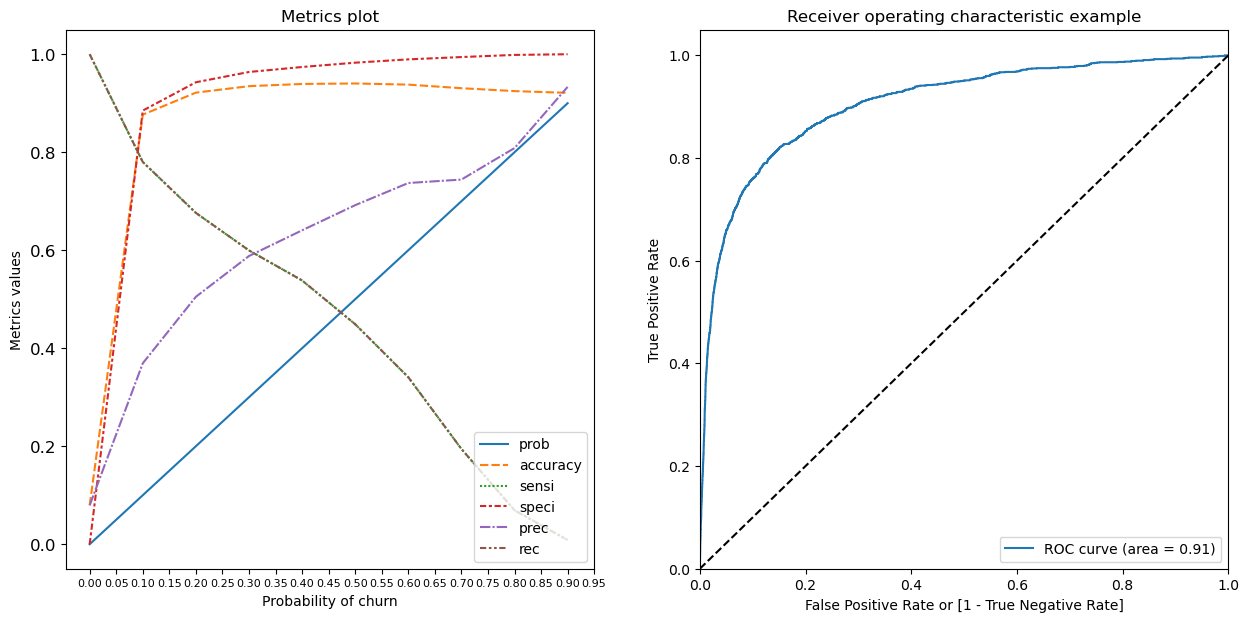

In [91]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_imbalanced, X_train_sm_imbalanced, y_train)

In [92]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     19067
           1       0.66      0.49      0.57      1646

    accuracy                           0.94     20713
   macro avg       0.81      0.74      0.77     20713
weighted avg       0.93      0.94      0.94     20713

Accuracy Score   :  0.9398
Precision Score  :  0.6629
Recall Score     :  0.4945
F1 Score         :  0.5665
Area under curve :  0.7364 



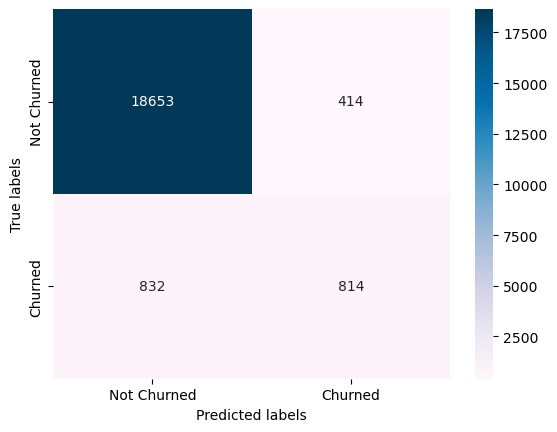

(0.9398, 0.6629, 0.4945, 0.5665, 0.7364)

In [93]:
# Step 5: Evaluate the metrics on the training data set

print("Evaluation on training data set: \n")
classification_algo_metrics(y_train, y_train_pred_final['final_predicted_1'])

In [94]:
# Step 6: Predict on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_imbalanced, 
                                                      X_test[imbalanced_rfe_features], 
                                                      y_test, cutoff=0.45)
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.015070                0
1      0      0.016411                0
2      0      0.128227                0
3      0      0.000909                0
4      0      0.058927                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8182
           1       0.66      0.49      0.56       696

    accuracy                           0.94      8878
   macro avg       0.81      0.74      0.77      8878
weighted avg       0.93      0.94      0.94      8878

Accuracy Score   :  0.9401
Precision Score  :  0.6565
Recall Score     :  0.4943
F1 Score         :  0.5639
Area under curve :  0.7361 



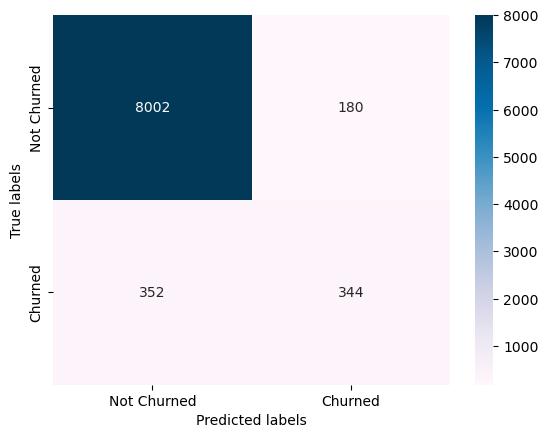

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361

In [95]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression on imbalanced data without PCA'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })
results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

####  Logistic Regression without PCA and handling imbalance using SMOTE technique

In [96]:
# Step 1: Run RFE
smote_rfe_features = run_rfe_on_logistic(X_smote_samples, y_smote_samples, no_of_features=25)
X_train_rfe_smote = X_smote_samples[smote_rfe_features]
X_train_rfe_smote.shape

(38134, 25)

In [97]:
# Step 2: Build the logistic model using RFE selected columns with StatsModels 
logistic_model_smote, X_train_sm_smote = build_logistic_model(X_train_rfe_smote, y_smote_samples)
logistic_model_smote.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38134
Model:                            GLM   Df Residuals:                    38108
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13679.
Date:                Sun, 03 Dec 2023   Deviance:                       27357.
Time:                        07:07:53   Pearson chi2:                 4.18e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4877
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.1208      0.064      1.890      0.059      -0.004       0.246
night_pck_user_6                    -1.7320      0.279     -6.201      0.000      -2.279      -1.185
night_pck_user_7                    -1.3359      0.326     -4.101      0.000      -1.974      -0.697
night_pck_user_8                    -0.6273      0.344     -1.825      0.068      -1.301       0.046
fb_user_6                           -1.3688      0.072    -19.069      0.000      -1.509      -1.228
fb_user_7                           -0.9940      0.071    -13.959      0.000      -1.134      -0.854
fb_user_8                           -1.0022      0.096    -10.486      0.000      -1.190      -0.815
onnet_mou_action_phase              -0.5048      0.026    -19.764      0.000      -0.555      -0.455
offnet_mou_action_phase             -0.4690      0.026    -17.978      0.000      -0.520      -0.418
roam_og_mou_action_phase             0.5175      0.015     34.230      0.000       0.488       0.547
std_og_mou_action_phase              0.4918      0.032     15.137      0.000       0.428       0.556
loc_ic_mou_good_phase                0.5629      0.028     20.385      0.000       0.509       0.617
loc_ic_mou_action_phase             -1.2694      0.037    -34.750      0.000      -1.341      -1.198
std_ic_mou_action_phase             -0.3812      0.024    -15.626      0.000      -0.429      -0.333
spl_ic_mou_action_phase             -0.4436      0.027    -16.663      0.000      -0.496      -0.391
total_rech_data_good_phase           0.4783      0.094      5.064      0.000       0.293       0.663
total_rech_data_action_phase         1.1458      0.091     12.563      0.000       0.967       1.325
max_rech_data_good_phase             0.5685      0.059      9.650      0.000       0.453       0.684
max_rech_data_action_phase           0.5507      0.057      9.613      0.000       0.438       0.663
count_rech_3g_good_phase             0.6384      0.032     19.817      0.000       0.575       0.702
vol_2g_mb_good_phase                 0.7485      0.041     18.449      0.000       0.669       0.828
vol_2g_mb_action_phase              -0.3888      0.039     -9.909      0.000      -0.466      -0.312
vol_3g_mb_good_phase                 0.3338      0.038      8.688      0.000       0.258       0.409
sachet_2g_good_phase                 0.5360      0.045     11.910      0.000       0.448       0.624
total_data_rech_amt_good_phase      -1.1871      0.130     -9.159      0.000      -1.441      -0.933
total_data_rech_amt_action_phase    -2.0058      0.119    -16.919      0.000      -2.238      -1.773
====================================================================================================
"""

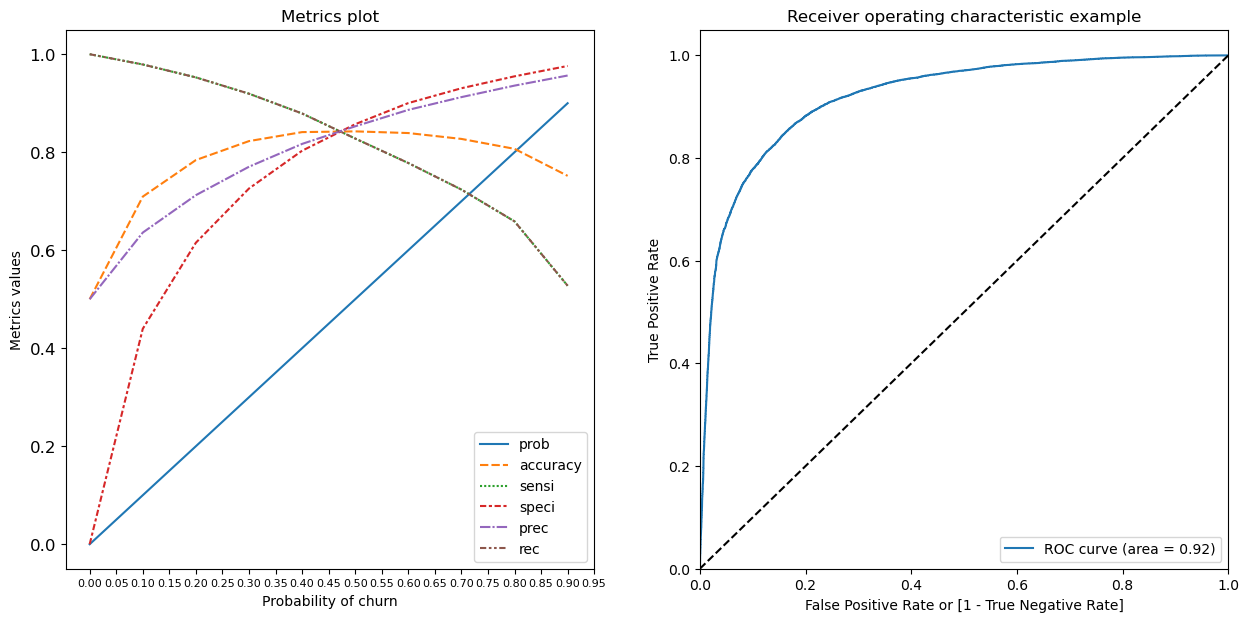

In [98]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_smote, X_train_sm_smote, y_smote_samples)

In [99]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.45
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns of all other cutoff

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84     19067
           1       0.84      0.85      0.85     19067

    accuracy                           0.84     38134
   macro avg       0.84      0.84      0.84     38134
weighted avg       0.84      0.84      0.84     38134

Accuracy Score   :  0.8437
Precision Score  :  0.8364
Recall Score     :  0.8546
F1 Score         :  0.8454
Area under curve :  0.8437 



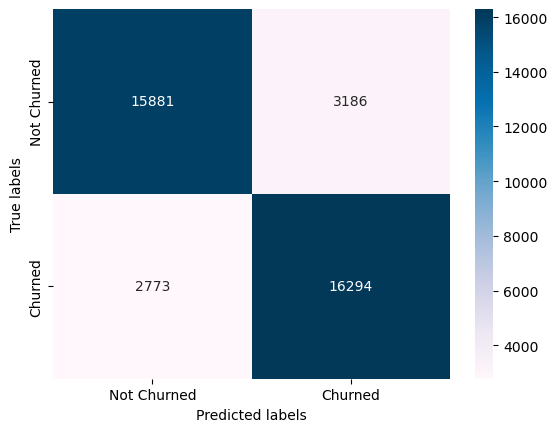

(0.8437, 0.8364, 0.8546, 0.8454, 0.8437)

In [100]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_smote_samples, y_train_pred_final['final_predicted_1'])

In [101]:
# Step 6: Predict on the test dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_smote, X_test[smote_rfe_features], y_test, cutoff=0.45) # Selecting only the columns used in final model of Train Dataset
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.134444                0
1      0      0.251734                0
2      0      0.473300                1
3      0      0.015987                0
4      0      0.177323                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.91      8182
           1       0.31      0.84      0.45       696

    accuracy                           0.84      8878
   macro avg       0.65      0.84      0.68      8878
weighted avg       0.93      0.84      0.87      8878

Accuracy Score   :  0.8401
Precision Score  :  0.3083
Recall Score     :  0.8362
F1 Score         :  0.4505
Area under curve :  0.8383 



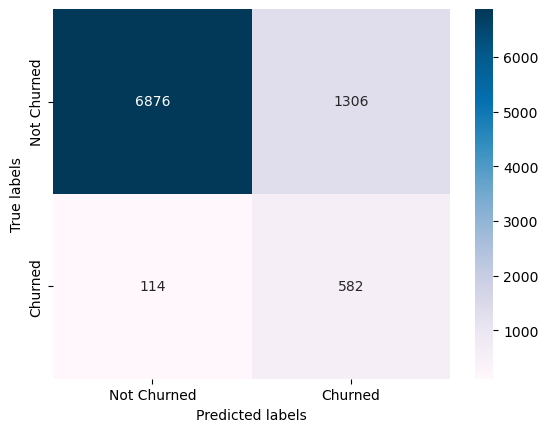

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383

In [102]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with SMOTE & without PCA'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

In [103]:
def perform_PCA(X):
    
    pca = PCA(svd_solver = 'randomized', random_state = 100)

    #Doing the PCA on the train data
    pca.fit(X)
    
    # Making the screeplot - plotting the cumulative variance against the number of components
    fig = plt.figure(figsize = (10,6))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))

    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [104]:
def perform_incremental_PCA(X_train, y_train, components):
    
    # Using incremental PCA for efficiency - saves a lot of time on larger datasets

    pca_final = IncrementalPCA(n_components = components)

    X_train_pca = pca_final.fit_transform(X_train)
    X_test_pca = pca_final.transform(X_test)

    X_train_pca = pd.DataFrame(data = X_train_pca)
    X_test_pca = pd.DataFrame(data = X_test_pca)

    print("Shape of X train PCA : ", X_train_pca.shape)
    print("Shape of Y train PCA : ", y_train.shape)
    print("Shape of X test PCA : ", X_test_pca.shape)
    print("Shape of Y test PCA : ", y_test.shape)
    
    #creating correlation matrix for the principal components
    corrmat = np.corrcoef(X_train_pca.transpose())

    #plotting the correlation matrix
    plt.figure(figsize = (10,8))
    sns.heatmap(corrmat, annot = False,cmap="RdYlGn",linewidth =1)
    plt.show()
    
    
    corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
    print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
    
    return X_train_pca, X_test_pca

### Logistic Regression with PCA and handling imbalance using random over sampling technique

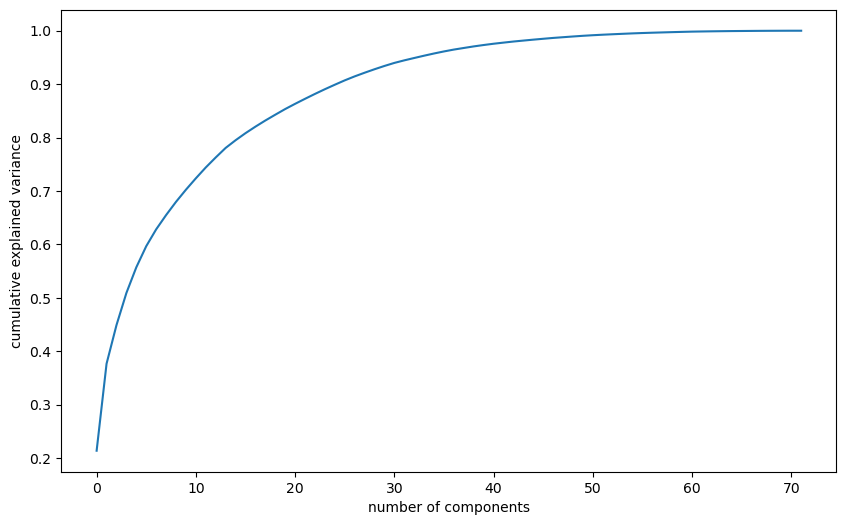

In [105]:
# Step 1.1: Perform PCA on the whole training dataset to identify number of features
perform_PCA(X_r_over_sampled)

Let's choose 25 components for modeling.

Shape of X train PCA :  (38134, 25)
Shape of Y train PCA :  (38134, 1)
Shape of X test PCA :  (8878, 25)
Shape of Y test PCA :  (8878, 1)


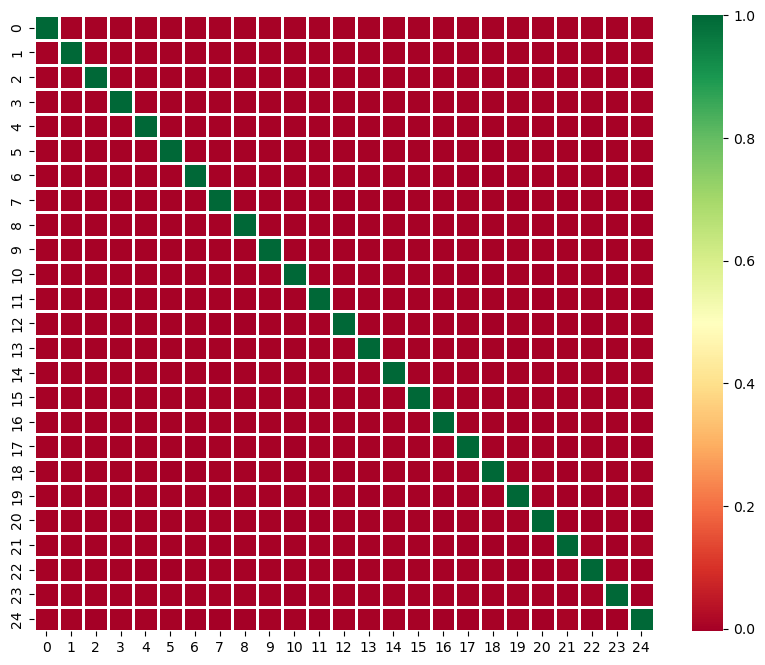

max corr: 0.004126819713404399 , min corr:  -0.004477104343219081


In [106]:
# Step 1.2 : Create 25 Principal components
X_train_pca_ro, X_test_pca_ro = perform_incremental_PCA(X_r_over_sampled, y_r_over_sampled, 25)

There is no correlation between any two components which is good for proceeding

In [107]:
# Step 2: Build the logistic model using PCA Components with StatsModels 
logistic_model_pca_r_over_balanced, X_train_sm_pca_r_over_balanced = build_logistic_model(X_train_pca_ro, y_r_over_sampled.values.ravel())
logistic_model_pca_r_over_balanced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                38134
Model:                            GLM   Df Residuals:                    38108
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14971.
Date:                Sun, 03 Dec 2023   Deviance:                       29943.
Time:                        07:07:58   Pearson chi2:                 4.63e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4518
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0441      0.016      2.838      0.005       0.014       0.075
0             -0.3362      0.004    -78.345      0.000      -0.345      -0.328
1             -0.4622      0.005    -84.084      0.000      -0.473      -0.451
2              0.1707      0.007     26.154      0.000       0.158       0.184
3              0.1032      0.007     14.061      0.000       0.089       0.118
4              0.4778      0.009     50.433      0.000       0.459       0.496
5             -0.0238      0.009     -2.747      0.006      -0.041      -0.007
6              0.2202      0.010     21.953      0.000       0.201       0.240
7             -0.0557      0.011     -5.022      0.000      -0.077      -0.034
8             -0.1328      0.012    -11.331      0.000      -0.156      -0.110
9             -0.1566      0.012    -13.307      0.000      -0.180      -0.134
10            -0.0323      0.012     -2.624      0.009      -0.056      -0.008
11            -0.3635      0.013    -27.745      0.000      -0.389      -0.338
12            -0.0240      0.013     -1.795      0.073      -0.050       0.002
13            -0.1008      0.014     -7.270      0.000      -0.128      -0.074
14             0.0007      0.015      0.048      0.962      -0.029       0.030
15             0.0008      0.015      0.056      0.955      -0.029       0.030
16            -0.0662      0.016     -4.057      0.000      -0.098      -0.034
17             0.0298      0.017      1.749      0.080      -0.004       0.063
18             0.1190      0.018      6.790      0.000       0.085       0.153
19             0.0396      0.018      2.148      0.032       0.003       0.076
20            -0.0714      0.018     -3.882      0.000      -0.107      -0.035
21            -0.1154      0.019     -6.039      0.000      -0.153      -0.078
22            -0.0904      0.019     -4.745      0.000      -0.128      -0.053
23            -0.3197      0.023    -13.753      0.000      -0.365      -0.274
24             0.0317      0.021      1.496      0.135      -0.010       0.073
==============================================================================
"""

 PCA models have PCA components as features - difficult to interpret!

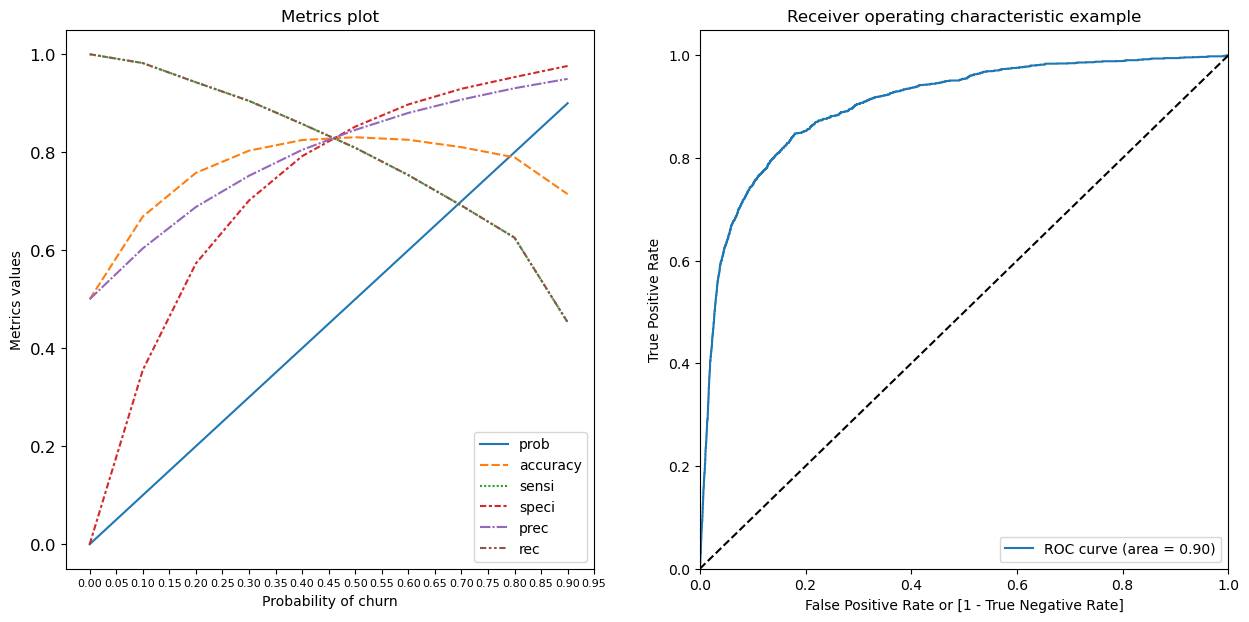

In [108]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_r_over_balanced, X_train_sm_pca_r_over_balanced, y_r_over_sampled)

In [109]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns of all other cutoff

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     19067
           1       0.83      0.84      0.83     19067

    accuracy                           0.83     38134
   macro avg       0.83      0.83      0.83     38134
weighted avg       0.83      0.83      0.83     38134

Accuracy Score   :  0.8327
Precision Score  :  0.8272
Recall Score     :  0.8411
F1 Score         :  0.8341
Area under curve :  0.8327 



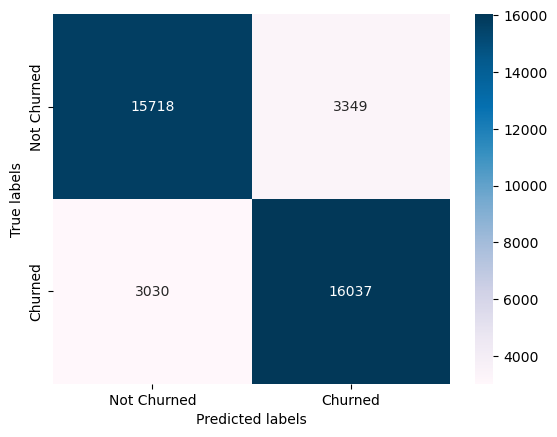

(0.8327, 0.8272, 0.8411, 0.8341, 0.8327)

In [110]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_r_over_sampled, y_train_pred_final['final_predicted_1'])

In [111]:
# Step 6: Predict on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_r_over_balanced, X_test_pca_ro, y_test, cutoff=0.45) 
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.092685                0
1      0      0.095762                0
2      0      0.273469                0
3      0      0.024419                0
4      0      0.278425                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      8182
           1       0.30      0.84      0.44       696

    accuracy                           0.83      8878
   macro avg       0.64      0.84      0.67      8878
weighted avg       0.93      0.83      0.86      8878

Accuracy Score   :  0.8319
Precision Score  :  0.2974
Recall Score     :  0.8391
F1 Score         :  0.4391
Area under curve :  0.8352 



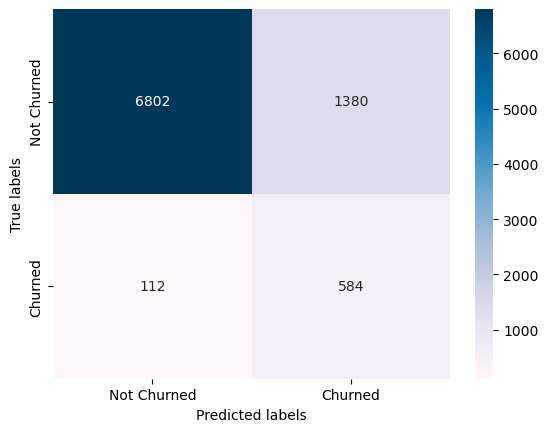

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352

In [112]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & Random over sampling'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression with PCA and handling imbalance using random under sampling technique

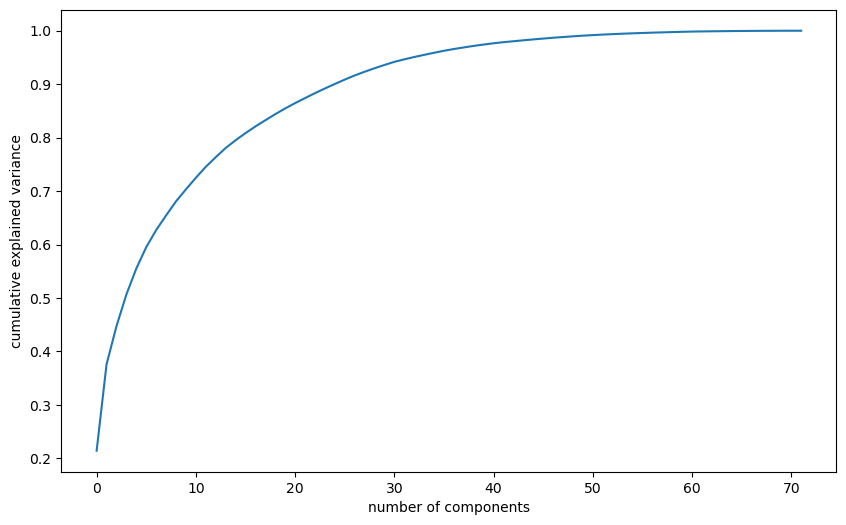

In [113]:
# Step 1.1: Perform PCA on the whole training dataset to identify number of features
perform_PCA(X_r_under_sampled)

Shape of X train PCA :  (3292, 25)
Shape of Y train PCA :  (3292, 1)
Shape of X test PCA :  (8878, 25)
Shape of Y test PCA :  (8878, 1)


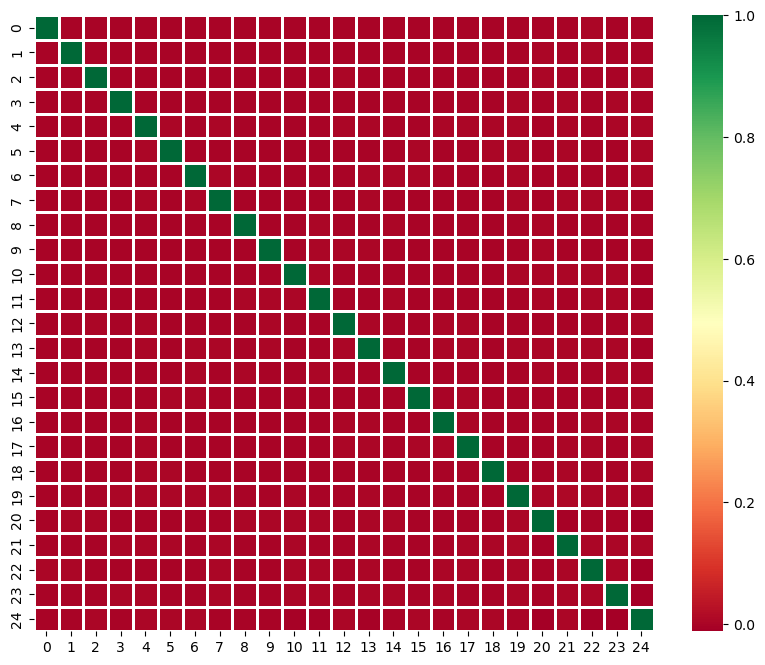

max corr: 0.005017427968907772 , min corr:  -0.011513044094550305


In [114]:
X_train_pca_ru, X_test_pca_run = perform_incremental_PCA(X_r_under_sampled, y_r_under_sampled, 25)

In [115]:
# Step 2: Build the logistic model using PCA Components with StatsModels 
logistic_model_pca_under_sampled, X_train_sm_pca_under_sampled = build_logistic_model(X_train_pca_ru, y_r_under_sampled.values.ravel())

# PCA uninterpretable components
logistic_model_pca_under_sampled.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3292
Model:                            GLM   Df Residuals:                     3266
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1310.4
Date:                Sun, 03 Dec 2023   Deviance:                       2620.8
Time:                        07:08:01   Pearson chi2:                 3.91e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4458
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0417      0.052      0.799      0.424      -0.061       0.144
0             -0.3092      0.014    -21.788      0.000      -0.337      -0.281
1             -0.4881      0.019    -25.511      0.000      -0.526      -0.451
2              0.1361      0.022      6.163      0.000       0.093       0.179
3              0.0543      0.025      2.164      0.030       0.005       0.104
4              0.4674      0.032     14.775      0.000       0.405       0.529
5             -0.0765      0.030     -2.589      0.010      -0.134      -0.019
6              0.2458      0.034      7.258      0.000       0.179       0.312
7              0.0303      0.038      0.789      0.430      -0.045       0.105
8              0.0489      0.038      1.281      0.200      -0.026       0.124
9             -0.0831      0.039     -2.130      0.033      -0.160      -0.007
10            -0.2351      0.042     -5.553      0.000      -0.318      -0.152
11             0.3113      0.045      6.975      0.000       0.224       0.399
12             0.0506      0.046      1.097      0.273      -0.040       0.141
13            -0.0563      0.048     -1.169      0.243      -0.151       0.038
14            -0.0079      0.052     -0.154      0.878      -0.109       0.093
15            -0.0119      0.051     -0.233      0.816      -0.113       0.089
16            -0.0586      0.057     -1.034      0.301      -0.170       0.052
17            -0.1001      0.057     -1.764      0.078      -0.211       0.011
18            -0.0157      0.063     -0.248      0.804      -0.140       0.108
19            -0.0490      0.059     -0.836      0.403      -0.164       0.066
20            -0.0806      0.063     -1.283      0.200      -0.204       0.043
21            -0.0533      0.065     -0.823      0.410      -0.180       0.074
22            -0.2599      0.068     -3.798      0.000      -0.394      -0.126
23            -0.1246      0.068     -1.832      0.067      -0.258       0.009
24            -0.1703      0.071     -2.384      0.017      -0.310      -0.030
==============================================================================
"""

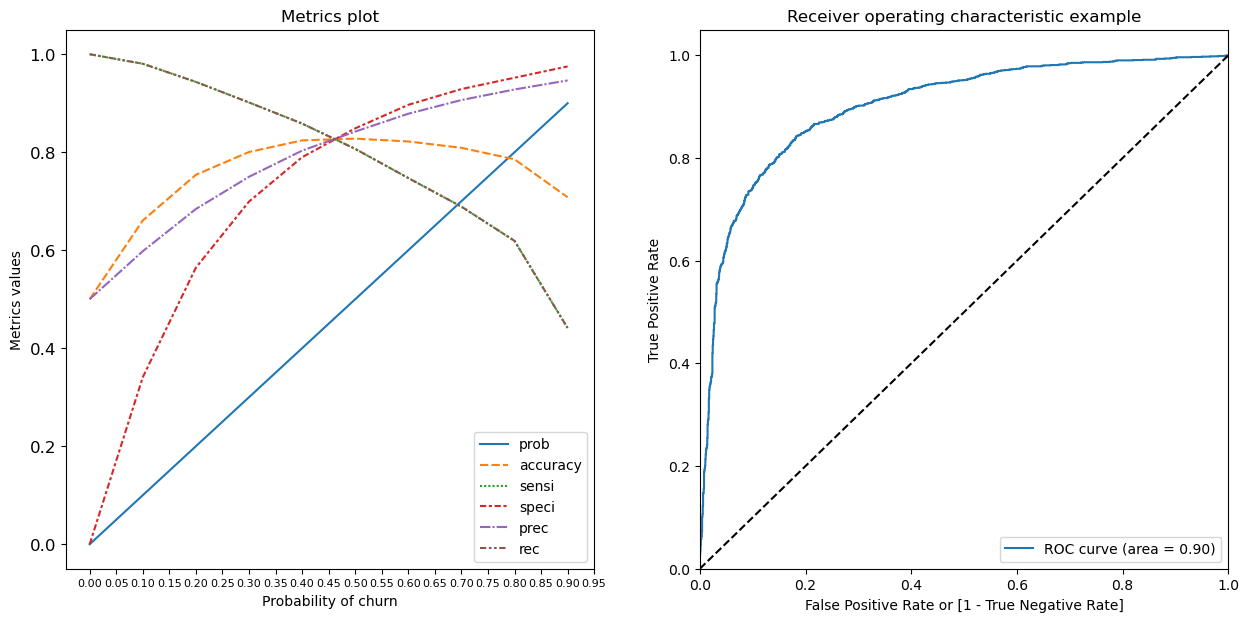

In [116]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_under_sampled, X_train_sm_pca_under_sampled, y_r_under_sampled)

In [117]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1646
           1       0.82      0.84      0.83      1646

    accuracy                           0.83      3292
   macro avg       0.83      0.83      0.83      3292
weighted avg       0.83      0.83      0.83      3292

Accuracy Score   :  0.8281
Precision Score  :  0.8226
Recall Score     :  0.8366
F1 Score         :  0.8295
Area under curve :  0.8281 



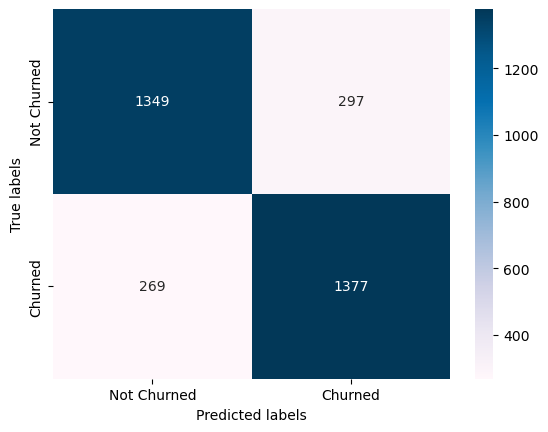

(0.8281, 0.8226, 0.8366, 0.8295, 0.8281)

In [118]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_r_under_sampled, y_train_pred_final['final_predicted_1'])

In [119]:
# Step 6: Predict on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_under_sampled, X_test_pca_run, y_test, cutoff=0.45) 
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.129628                0
1      0      0.093461                0
2      0      0.246154                0
3      0      0.029340                0
4      0      0.305963                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      8182
           1       0.30      0.83      0.44       696

    accuracy                           0.83      8878
   macro avg       0.64      0.83      0.67      8878
weighted avg       0.93      0.83      0.86      8878

Accuracy Score   :  0.8312
Precision Score  :  0.2957
Recall Score     :  0.8348
F1 Score         :  0.4367
Area under curve :  0.8328 



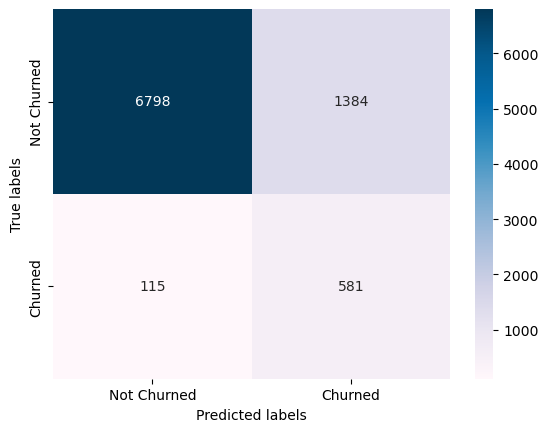

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328

In [120]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & Random under sampling'],
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Logistic Regression with PCA and handling imbalance using SMOTE technique

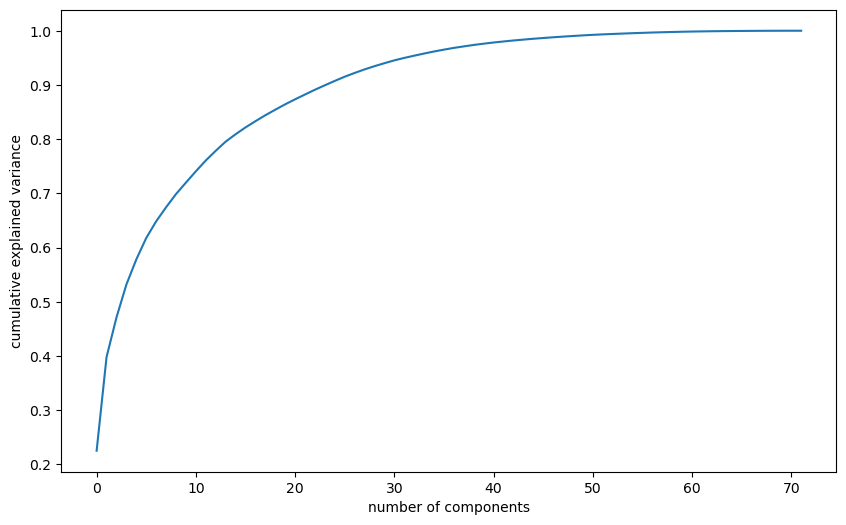

In [121]:
# Step 1.1: Perform PCA on the whole training dataset to identify number of features
perform_PCA(X_smote_samples)

In [122]:
X_train.shape

(20713, 72)

Shape of X train PCA :  (38134, 25)
Shape of Y train PCA :  (38134, 1)
Shape of X test PCA :  (8878, 25)
Shape of Y test PCA :  (8878, 1)


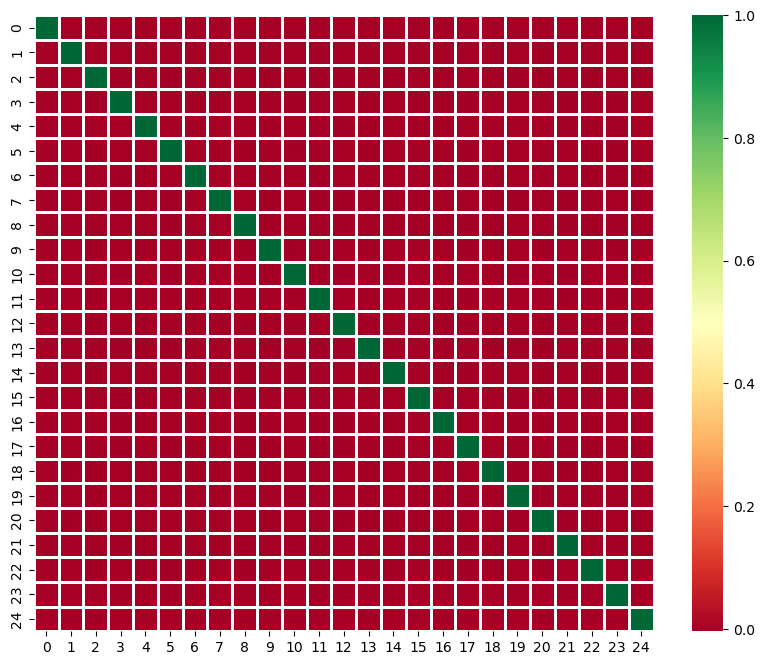

max corr: 0.0025784808844032396 , min corr:  -0.003985032842779876


In [123]:
# Step 1.2 : Create 25 Principal components
X_train_pca_smote, X_test_pca_smote = perform_incremental_PCA(X_smote_samples, y_smote_samples, 25)

#### There is no correlation between any two components which is good for proceeding

In [124]:
# Step 2: Build the logistic model using PCA Components with StatsModels 
logistic_model_pca_smote, X_train_sm_pca_smote = build_logistic_model(X_train_pca_smote, y_smote_samples.values.ravel())
# Skip as the features are PCA uninterpretable components

logistic_model_pca_smote.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                38134
Model:                            GLM   Df Residuals:                    38108
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14247.
Date:                Sun, 03 Dec 2023   Deviance:                       28494.
Time:                        07:08:04   Pearson chi2:                 4.50e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4722
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.016      0.386      0.699      -0.026       0.038
0             -0.3744      0.005    -81.654      0.000      -0.383      -0.365
1             -0.5009      0.006    -85.753      0.000      -0.512      -0.489
2              0.1683      0.007     24.402      0.000       0.155       0.182
3              0.0675      0.008      8.678      0.000       0.052       0.083
4              0.4554      0.010     44.812      0.000       0.436       0.475
5             -0.0850      0.009     -9.192      0.000      -0.103      -0.067
6              0.2145      0.011     19.798      0.000       0.193       0.236
7             -0.0017      0.012     -0.137      0.891      -0.026       0.023
8             -0.1540      0.013    -12.190      0.000      -0.179      -0.129
9             -0.2014      0.014    -14.744      0.000      -0.228      -0.175
10            -0.1700      0.013    -13.123      0.000      -0.195      -0.145
11             0.4057      0.014     28.797      0.000       0.378       0.433
12            -0.0466      0.015     -3.199      0.001      -0.075      -0.018
13            -0.1065      0.015     -6.957      0.000      -0.137      -0.077
14            -0.0103      0.016     -0.626      0.531      -0.042       0.022
15            -0.0314      0.016     -1.930      0.054      -0.063       0.000
16            -0.1033      0.018     -5.714      0.000      -0.139      -0.068
17             0.0126      0.019      0.671      0.502      -0.024       0.049
18             0.1220      0.021      5.835      0.000       0.081       0.163
19            -0.1586      0.019     -8.330      0.000      -0.196      -0.121
20            -0.1444      0.021     -6.988      0.000      -0.185      -0.104
21            -0.2312      0.022    -10.612      0.000      -0.274      -0.189
22             0.0336      0.022      1.550      0.121      -0.009       0.076
23            -0.3284      0.025    -13.298      0.000      -0.377      -0.280
24             0.0640      0.023      2.727      0.006       0.018       0.110
==============================================================================
"""

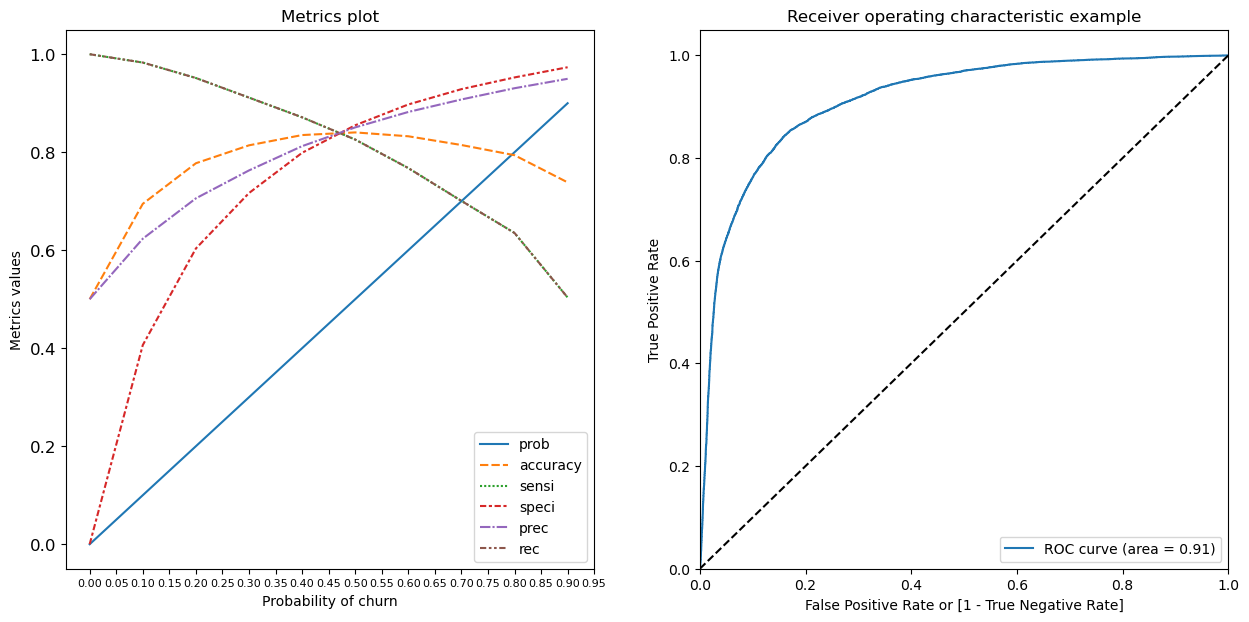

In [125]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_smote, X_train_sm_pca_smote, y_smote_samples)

In [126]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.45 
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84     19067
           1       0.83      0.85      0.84     19067

    accuracy                           0.84     38134
   macro avg       0.84      0.84      0.84     38134
weighted avg       0.84      0.84      0.84     38134

Accuracy Score   :  0.8413
Precision Score  :  0.8337
Recall Score     :  0.8527
F1 Score         :  0.8431
Area under curve :  0.8413 



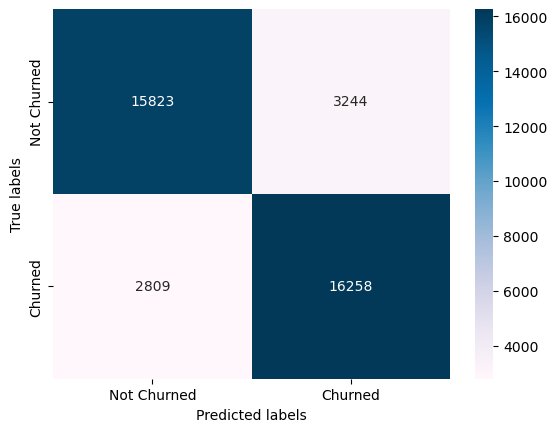

(0.8413, 0.8337, 0.8527, 0.8431, 0.8413)

In [127]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_smote_samples, y_train_pred_final['final_predicted_1'])

In [128]:
# Step 6: Predict on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_smote, X_test_pca_smote, y_test, cutoff=0.45) 
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.066030                0
1      0      0.079165                0
2      0      0.288579                0
3      0      0.014339                0
4      0      0.242444                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      8182
           1       0.30      0.83      0.44       696

    accuracy                           0.84      8878
   macro avg       0.64      0.83      0.67      8878
weighted avg       0.93      0.84      0.87      8878

Accuracy Score   :  0.8361
Precision Score  :  0.302
Recall Score     :  0.8319
F1 Score         :  0.4432
Area under curve :  0.8342 



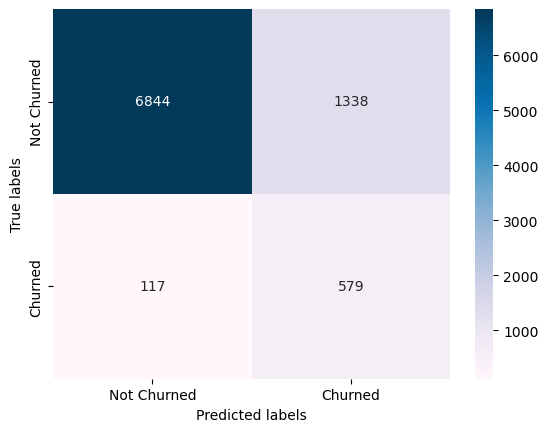

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342

In [129]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & SMOTE'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall],
                            'F1 score': [f1],
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

####  Logistic Regression with PCA and handling imbalance using SMOTEEN technique

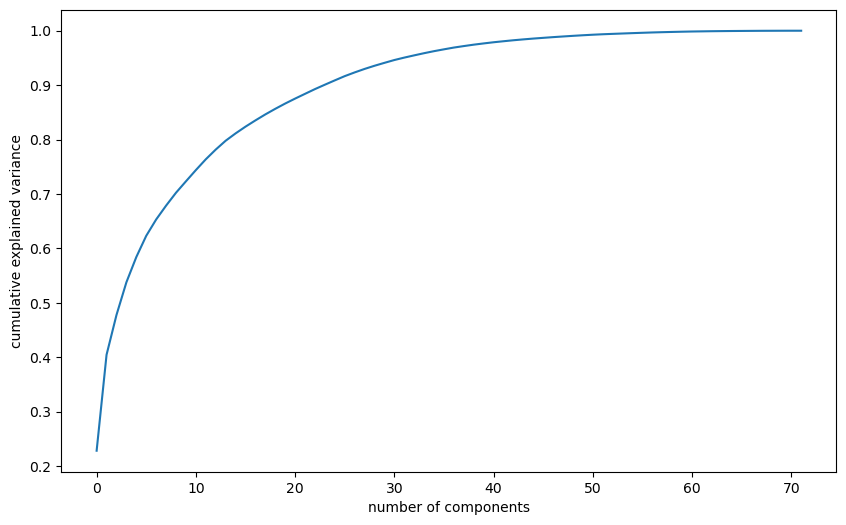

In [130]:
# Step 1.1: Perform PCA on the whole training dataset to identify number of features
perform_PCA(X_train_resampled)

less than 25 components are enough to describe 90% of the variance in the dataset.choosing 25 components for modeling.

Shape of X train PCA :  (34146, 25)
Shape of Y train PCA :  (34146, 1)
Shape of X test PCA :  (8878, 25)
Shape of Y test PCA :  (8878, 1)


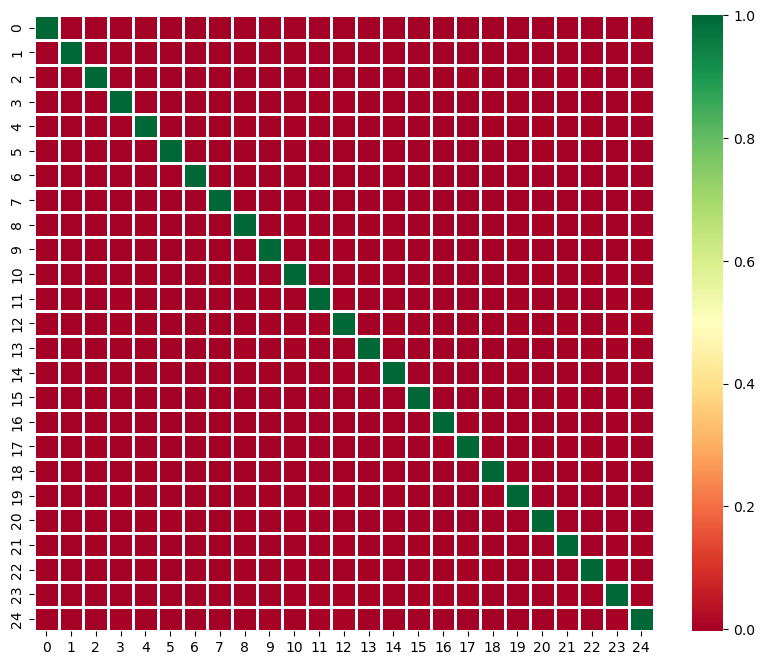

max corr: 0.00497270418571219 , min corr:  -0.0033188177971013436


In [131]:
# Step 1.2 : Create 25 Principal components
X_train_pca_smoteen, X_test_pca_smoteen = perform_incremental_PCA(X_train_resampled, y_train_resampled, 25)

In [132]:
# Step 2: Build the logistic model using PCA Components with StatsModels 
logistic_model_pca_smoteen, X_train_sm_pca_smoteen = build_logistic_model(X_train_pca_smoteen, y_train_resampled.values.ravel())
# Skip as the features are PCA uninterpretable components
logistic_model_pca_smoteen.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                34146
Model:                            GLM   Df Residuals:                    34120
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9348.3
Date:                Sun, 03 Dec 2023   Deviance:                       18697.
Time:                        07:08:09   Pearson chi2:                 4.39e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5619
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7697      0.024     31.600      0.000       0.722       0.817
0             -0.5852      0.007    -78.086      0.000      -0.600      -0.570
1             -0.6506      0.009    -75.791      0.000      -0.667      -0.634
2              0.2605      0.009     29.703      0.000       0.243       0.278
3              0.1159      0.010     11.381      0.000       0.096       0.136
4              0.6899      0.015     46.967      0.000       0.661       0.719
5             -0.0368      0.011     -3.264      0.001      -0.059      -0.015
6              0.2886      0.013     22.360      0.000       0.263       0.314
7              0.0546      0.015      3.578      0.000       0.025       0.084
8             -0.1925      0.016    -11.733      0.000      -0.225      -0.160
9             -0.3191      0.017    -19.178      0.000      -0.352      -0.286
10            -0.2683      0.016    -16.640      0.000      -0.300      -0.237
11             0.5596      0.018     30.472      0.000       0.524       0.596
12            -0.0615      0.017     -3.522      0.000      -0.096      -0.027
13            -0.0854      0.018     -4.747      0.000      -0.121      -0.050
14            -0.0131      0.020     -0.671      0.502      -0.052       0.025
15             0.0091      0.020      0.460      0.646      -0.030       0.048
16            -0.1100      0.021     -5.139      0.000      -0.152      -0.068
17             0.0559      0.022      2.513      0.012       0.012       0.099
18             0.2055      0.023      8.890      0.000       0.160       0.251
19            -0.2060      0.023     -8.870      0.000      -0.252      -0.160
20            -0.2103      0.025     -8.505      0.000      -0.259      -0.162
21            -0.3375      0.027    -12.447      0.000      -0.391      -0.284
22            -0.3058      0.027    -11.331      0.000      -0.359      -0.253
23             0.0055      0.026      0.207      0.836      -0.046       0.057
24             0.0171      0.028      0.612      0.541      -0.038       0.072
==============================================================================
"""

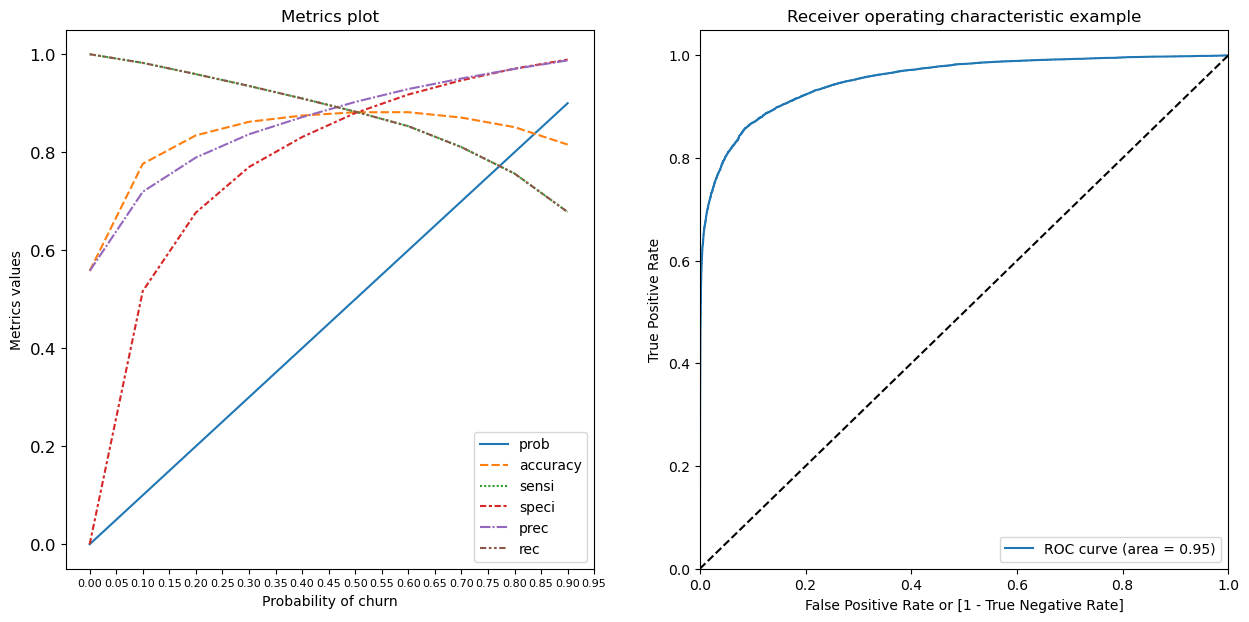

In [133]:
# Step 3: Predict using the training data
y_train_pred_final = predict_train_using_logistic_model(logistic_model_pca_smoteen, X_train_sm_pca_smoteen, y_train_resampled)

In [134]:
# Step 4: Decide the cutoff based on the metrics plot
cutoff = 0.46
y_train_pred_final['final_predicted_1'] = y_train_pred_final['Churn_pred_prob'].map( lambda x: 1 if x > cutoff else 0)
# deleting the unnecessary columns of all other cutoff
y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) 

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86     15103
           1       0.89      0.89      0.89     19043

    accuracy                           0.88     34146
   macro avg       0.88      0.88      0.88     34146
weighted avg       0.88      0.88      0.88     34146

Accuracy Score   :  0.8795
Precision Score  :  0.891
Recall Score     :  0.8933
F1 Score         :  0.8922
Area under curve :  0.8777 



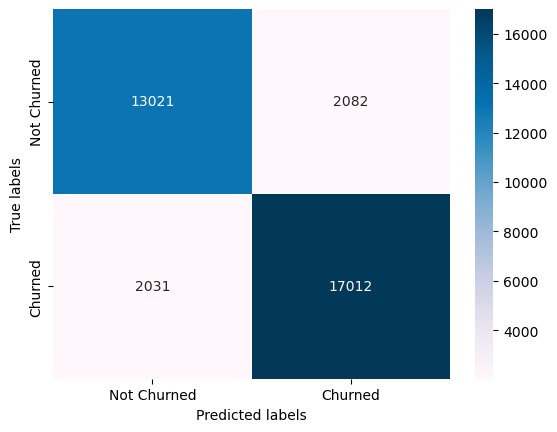

(0.8795, 0.891, 0.8933, 0.8922, 0.8777)

In [135]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train_resampled, y_train_pred_final['final_predicted_1'])

In [136]:
# Step 6: Predict on the test dataset
# Selecting only the columns used in final model of Train Dataset
y_test_pred_final = predict_test_using_logistic_model(logistic_model_pca_smoteen, X_test_pca_smoteen, y_test, cutoff=0.45) 
y_test_pred_final.head()

churn  Churned_Prob  final_predicted
0      0      0.050598                0
1      0      0.057240                0
2      0      0.371529                0
3      0      0.008749                0
4      0      0.283711                0

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      8182
           1       0.25      0.88      0.39       696

    accuracy                           0.78      8878
   macro avg       0.62      0.83      0.63      8878
weighted avg       0.93      0.78      0.83      8878

Accuracy Score   :  0.7799
Precision Score  :  0.247
Recall Score     :  0.8822
F1 Score         :  0.3859
Area under curve :  0.8267 



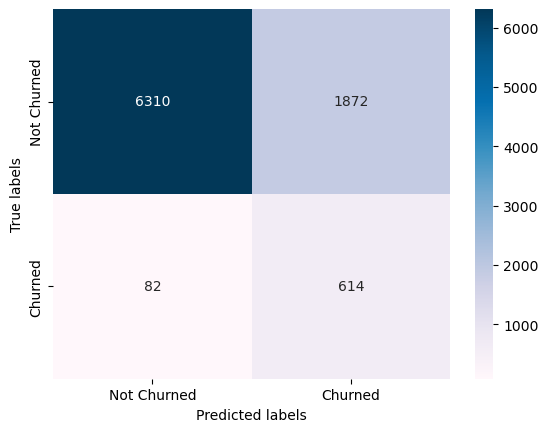

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342  
0  0.8822    0.3859                0.8267

In [137]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final['final_predicted'])

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA & SMOTEENN'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

####  Logistic Regression with PCA and handling imbalance using SMOTEEN technique with regularization penalty

Shape of X train PCA :  (34146, 25)
Shape of Y train PCA :  (34146, 1)
Shape of X test PCA :  (8878, 25)
Shape of Y test PCA :  (8878, 1)


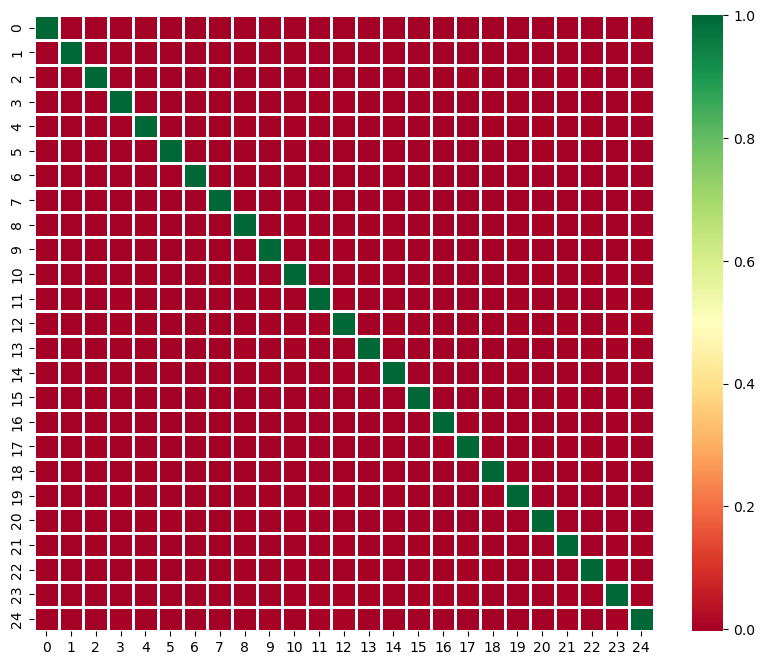

max corr: 0.00497270418571219 , min corr:  -0.0033188177971013436


In [138]:
# Step 1: Create 25 principal components
X_train_pca_reg, X_test_pca_reg = perform_incremental_PCA(X_train_resampled, y_train_resampled, 25)

In [139]:
# Step 2.1: Hyper parameter tuning: Decide whether to apply l1 or l2 penalty using GridSearchCV
lr = LogisticRegression(n_jobs = -1, random_state = 100)
parameter = 'penalty'
param_grid = {parameter: ['l1', 'l2']} # parameters to build the model on

gc = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 15, cv = 5, verbose = 2)
gc = gc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# scores of GridSearch CV
scores = gc.cv_results_    

# Get the best value
gc.best_params_


Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'penalty': 'l2'}

Fitting 5 folds for each of 4 candidates, totalling 20 fits


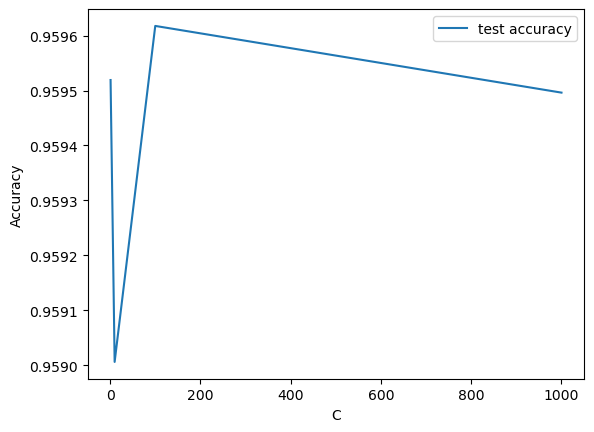

{'C': 100}

In [140]:
# Step 2.2: Hyper parameter tuning: Decide penalty value of 'c' for L2 regularization
lr = LogisticRegression(penalty = 'l2', n_jobs = -1, random_state = 100)
parameter = 'C'
param_grid = {parameter: [1, 10, 100, 1000]} # parameters to build the model on

gc = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 15, cv = 5, verbose = 2)
gc = gc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# scores of GridSearch CV
scores = gc.cv_results_

# Plot the scores
col = "param_" + parameter
    
#plt.plot(scores[col], scores["mean_train_score"], label = "training accuracy")
plt.plot(scores[col], scores["mean_test_score"], label = "test accuracy")

plt.xlabel(parameter)
plt.ylabel("Accuracy")

plt.legend()
plt.show()

# Get the best value
gc.best_params_

In [141]:
# Step 3: Build logistic model with regularization penalty and Principal components

lr = LogisticRegression(penalty = 'l2', C = 1, n_jobs = -1, random_state = 100)
logistic_model_pca_smoteen_reg = lr.fit(X_train_pca_reg.values, y_train_resampled.values.ravel())

In [142]:
# Step 4: Predict using the training data
y_train_pred_final = logistic_model_pca_smoteen_reg.predict(X_train_pca_reg.values)
y_train_pred_final

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     15103
           1       0.90      0.88      0.89     19043

    accuracy                           0.88     34146
   macro avg       0.88      0.88      0.88     34146
weighted avg       0.88      0.88      0.88     34146

Accuracy Score   :  0.8816
Precision Score  :  0.9027
Recall Score     :  0.8829
F1 Score         :  0.8927
Area under curve :  0.8814 



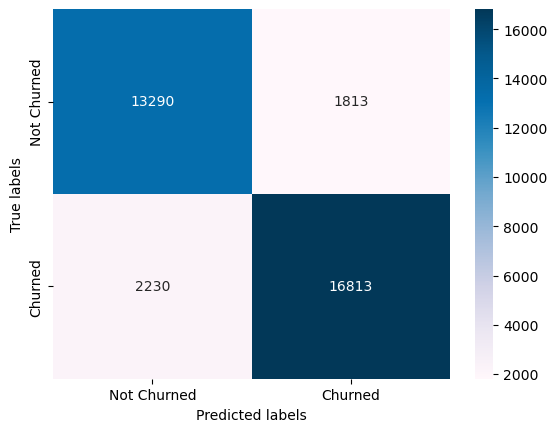

(0.8816, 0.9027, 0.8829, 0.8927, 0.8814)

In [143]:
# Step 5: Evaluate the metrics on the training data set
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train_resampled, y_train_pred_final)

In [144]:
# Step 6: Predict on the test dataset
y_test_pred_final = logistic_model_pca_smoteen_reg.predict(X_test_pca_reg.values)
y_test_pred_final

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88      8182
           1       0.27      0.87      0.41       696

    accuracy                           0.80      8878
   macro avg       0.63      0.83      0.65      8878
weighted avg       0.93      0.80      0.84      8878

Accuracy Score   :  0.8029
Precision Score  :  0.2674
Recall Score     :  0.8707
F1 Score         :  0.4092
Area under curve :  0.8339 



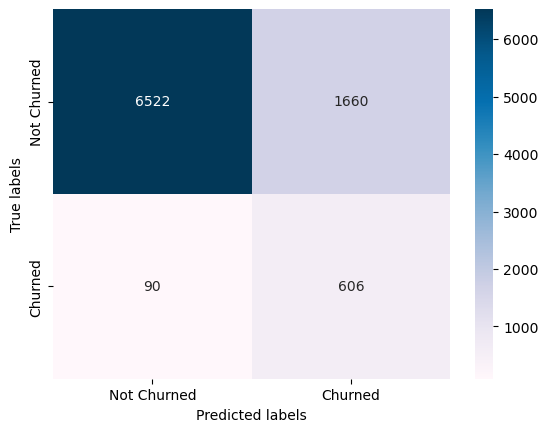

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   
0  Logistic Regression with PCA, SMOTEEN, L2 regu...    0.8029     0.2674   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342  
0  0.8822    0.3859                0.8267  
0  0.8707    0.4092                0.8339

In [145]:
# Step 7: Evaluate the metrics on the test data set
print("Evaluation on test data set: \n")
accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test, y_test_pred_final)

tempResults = pd.DataFrame({'Model':['Logistic Regression with PCA, SMOTEEN, L2 regularization'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision], 
                            'Recall': [recall], 
                            'F1 score': [f1],
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

#### Random Forest

In [146]:
# Running RandomForestClassifier without hyper parameter tuning with the actual train and test data data
model_rf = RandomForestClassifier(random_state = 100, n_estimators= 100,n_jobs =-1, class_weight = {0:1,1:9})
model_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 9}, n_jobs=-1, random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19067
           1       1.00      1.00      1.00      1646

    accuracy                           1.00     20713
   macro avg       1.00      1.00      1.00     20713
weighted avg       1.00      1.00      1.00     20713

Accuracy Score   :  1.0
Precision Score  :  1.0
Recall Score     :  1.0
F1 Score         :  1.0
Area under curve :  1.0 



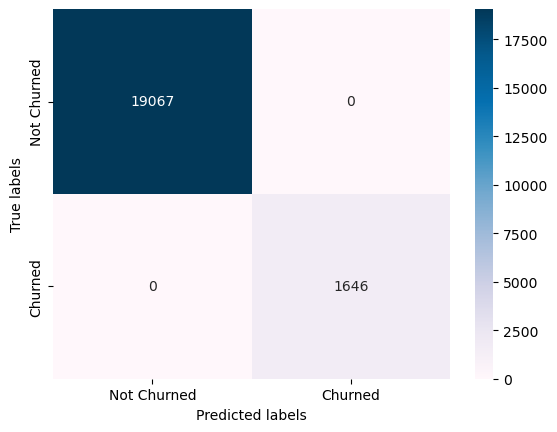

(1.0, 1.0, 1.0, 1.0, 1.0)

In [147]:
# Checking the performance of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

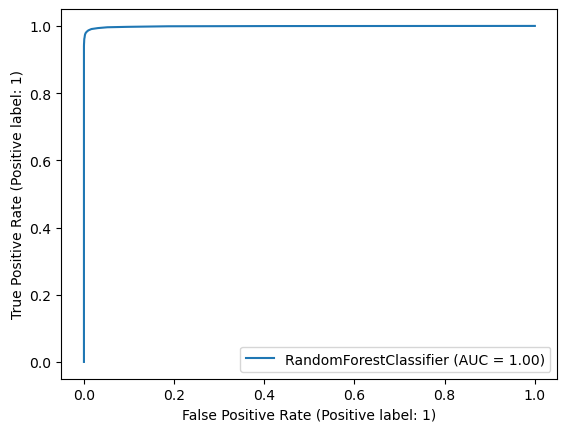

In [148]:
#Checking the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      8182
           1       0.78      0.43      0.56       696

    accuracy                           0.95      8878
   macro avg       0.87      0.71      0.76      8878
weighted avg       0.94      0.95      0.94      8878

Accuracy Score   :  0.9459
Precision Score  :  0.7798
Recall Score     :  0.4325
F1 Score         :  0.5564
Area under curve :  0.711 



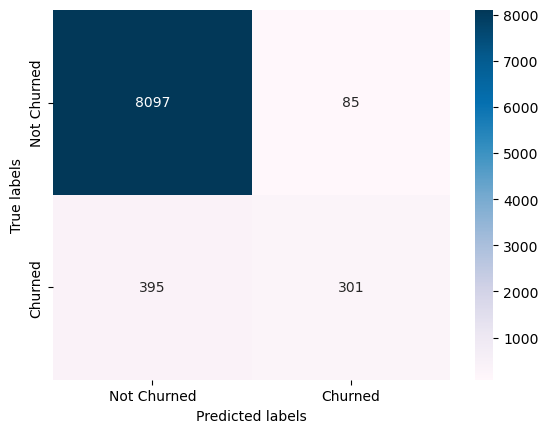

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   
0  Logistic Regression with PCA, SMOTEEN, L2 regu...    0.8029     0.2674   
0                    Random Forest with class_weight    0.9459     0.7798   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342  
0  0.8822    0.3859                0.8267  
0  0.8707    0.4092                0.8339  
0  0.4325    0.5564                0.7110

In [149]:
# Checking the performance on the test dataset
y_test_rf = model_rf.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with class_weight'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]

results

Insight -class-weight method of RandomForest:
    
Train dataset recall score = 1 where as in test data set = 0.43. 
This signifies, that the model is over-trained (over-fitting) 
We need to conduct hyperparameter tuning to get better result. But before we do hyperparameter tuning, we will try another model with resampled data and without specifying class_weight.

In [150]:
# Running RandomForestClassifier without hyper parameter tuning with the resampled data
model_rf = RandomForestClassifier(random_state = 100, n_estimators= 100,n_jobs =-1)
model_rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     19067
           1       0.56      1.00      0.71      1646

    accuracy                           0.94     20713
   macro avg       0.78      0.96      0.84     20713
weighted avg       0.96      0.94      0.94     20713

Accuracy Score   :  0.9368
Precision Score  :  0.5569
Recall Score     :  0.9982
F1 Score         :  0.715
Area under curve :  0.9648 



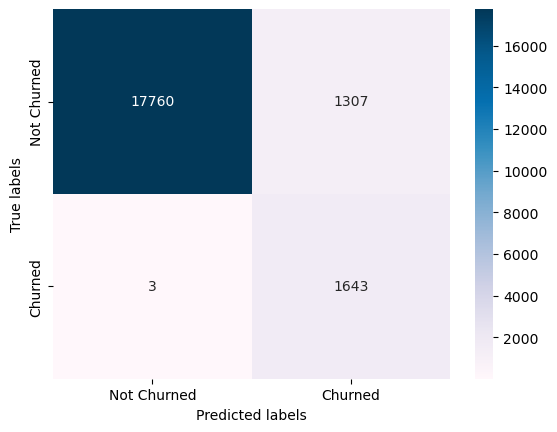

(0.9368, 0.5569, 0.9982, 0.715, 0.9648)

In [151]:
# Checking the performance of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

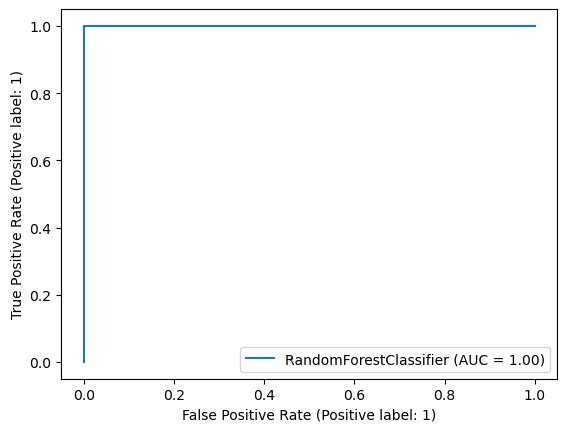

In [152]:
#Checking the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      8182
           1       0.45      0.74      0.56       696

    accuracy                           0.91      8878
   macro avg       0.72      0.83      0.76      8878
weighted avg       0.94      0.91      0.92      8878

Accuracy Score   :  0.9097
Precision Score  :  0.4535
Recall Score     :  0.7428
F1 Score         :  0.5632
Area under curve :  0.8333 



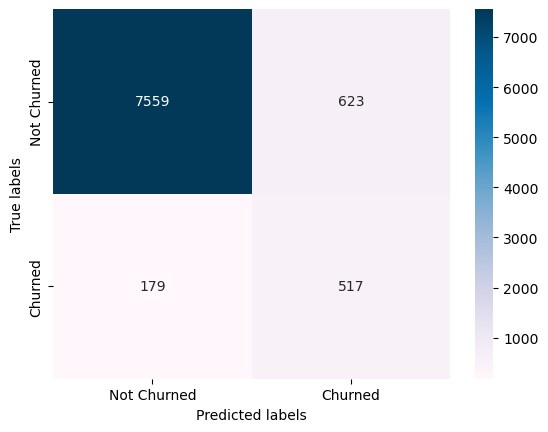

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   
0  Logistic Regression with PCA, SMOTEEN, L2 regu...    0.8029     0.2674   
0                    Random Forest with class_weight    0.9459     0.7798   
0                        Random Forest with SMOTEENN    0.9097     0.4535   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342  
0  0.8822    0.3859                0.8267  
0  0.8707    0.4092                0.8339  
0  0.4325    0.5564                0.7110  
0  0.7428    0.5632                0.8333

In [153]:
# Checking the performance on the test dataset
y_test_rf = model_rf.predict(X_test)
print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with SMOTEENN'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results


#### Insights:

Using resampling, the model performance has improved. But, this can be further improved for better prediction

Hyper parameter tuning and build a model with best parameters from GridSearchCV.

In [154]:
# Let's build the model using the hyperparameters we got from GridSearchCV
model_rf = RandomForestClassifier(random_state = 100, n_jobs =-1,
                                  n_estimators= 500,
                                  max_depth = 30,
                                  max_features = 'auto',
                                  min_samples_leaf = 100,
                                  min_samples_split=200,
                                  criterion ='gini')
model_rf.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(max_depth=30, min_samples_leaf=100,
                       min_samples_split=200, n_estimators=500, n_jobs=-1,
                       random_state=100)

Evaluation on training data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19067
           1       0.34      0.85      0.49      1646

    accuracy                           0.86     20713
   macro avg       0.66      0.86      0.70     20713
weighted avg       0.93      0.86      0.88     20713

Accuracy Score   :  0.859
Precision Score  :  0.3439
Recall Score     :  0.8536
F1 Score         :  0.4903
Area under curve :  0.8565 



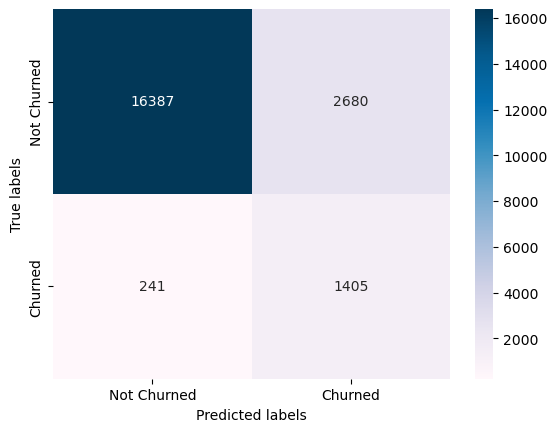

(0.859, 0.3439, 0.8536, 0.4903, 0.8565)

In [155]:
# Checking the performance of the train dataset
y_train_rf = model_rf.predict(X_train)
print("Evaluation on training data set: \n")
classification_algo_metrics(y_train,y_train_rf)

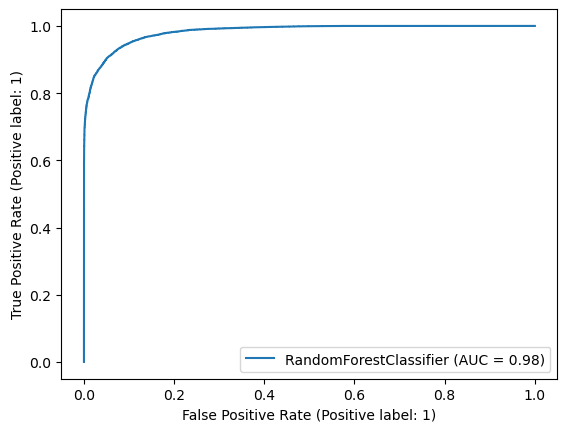

In [156]:
#Checking the AUC ROC Curve
plot_roc_curve(model_rf, X_train_resampled,y_train_resampled)
plt.show()

Evaluation on test data set: 

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.92      8182
           1       0.34      0.82      0.48       696

    accuracy                           0.86      8878
   macro avg       0.66      0.84      0.70      8878
weighted avg       0.93      0.86      0.88      8878

Accuracy Score   :  0.8598
Precision Score  :  0.3379
Recall Score     :  0.8218
F1 Score         :  0.4789
Area under curve :  0.8424 



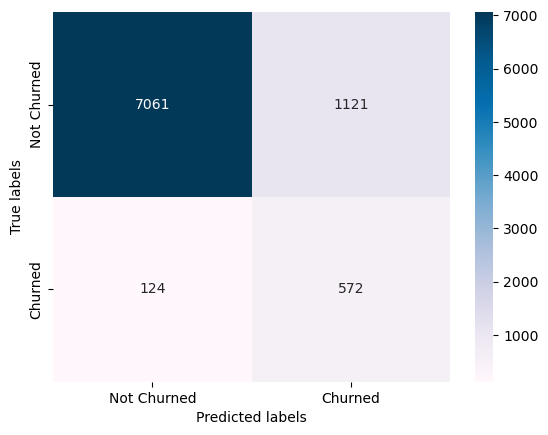

Model  Accuracy  Precision  \
0  Logistic Regression on imbalanced data without...    0.9401     0.6565   
0       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
0  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
0  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
0               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   
0  Logistic Regression with PCA, SMOTEEN, L2 regu...    0.8029     0.2674   
0                    Random Forest with class_weight    0.9459     0.7798   
0                        Random Forest with SMOTEENN    0.9097     0.4535   
0  Random Forest with SMOTEENN & Hyperparameter t...    0.8598     0.3379   

   Recall  F1 score  Area under ROC curve  
0  0.4943    0.5639                0.7361  
0  0.8362    0.4505                0.8383  
0  0.8391    0.4391                0.8352  
0  0.8348    0.4367                0.8328  
0  0.8319    0.4432                0.8342  
0  0.8822    0.3859                0.8267  
0  0.8707    0.4092                0.8339  
0  0.4325    0.5564                0.7110  
0  0.7428    0.5632                0.8333  
0  0.8218    0.4789                0.8424

In [157]:
# Checking the performance on the test dataset
y_test_rf = model_rf.predict(X_test)

print("Evaluation on test data set: \n")

accuracy, precision, recall, f1, model_roc_auc = classification_algo_metrics(y_test,y_test_rf)

tempResults = pd.DataFrame({'Model':['Random Forest with SMOTEENN & Hyperparameter tuned'], 
                            'Accuracy': [accuracy],
                            'Precision': [precision],
                            'Recall': [recall], 
                            'F1 score': [f1], 
                            'Area under ROC curve': [model_roc_auc] })

results = pd.concat([results, tempResults])
results = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Area under ROC curve']]
results

This is further improved when compared to other RF models 

#### FINAL-MODEL SELECTION

As our target is to reduce high value customer churn, it is necessary that we reduce the False Negative and not worry about False Positive. To reduce False Negative we will choose the model which provides highest Recall value. As we are not targeting to reduce False Positives, i.e. customers who are identified as potential churn but will not actually churn, then we will not focus on Precision and F1 Score.

In [158]:
# Rearranging the dataframe 
results = results.sort_values("Recall", ascending = False).reset_index(drop=True)
results

Model  Accuracy  Precision  \
0            Logistic Regression with PCA & SMOTEENN    0.7799     0.2470   
1  Logistic Regression with PCA, SMOTEEN, L2 regu...    0.8029     0.2674   
2  Logistic Regression with PCA & Random over sam...    0.8319     0.2974   
3       Logistic Regression with SMOTE & without PCA    0.8401     0.3083   
4  Logistic Regression with PCA & Random under sa...    0.8312     0.2957   
5               Logistic Regression with PCA & SMOTE    0.8361     0.3020   
6  Random Forest with SMOTEENN & Hyperparameter t...    0.8598     0.3379   
7                        Random Forest with SMOTEENN    0.9097     0.4535   
8  Logistic Regression on imbalanced data without...    0.9401     0.6565   
9                    Random Forest with class_weight    0.9459     0.7798   

   Recall  F1 score  Area under ROC curve  
0  0.8822    0.3859                0.8267  
1  0.8707    0.4092                0.8339  
2  0.8391    0.4391                0.8352  
3  0.8362    0.4505                0.8383  
4  0.8348    0.4367                0.8328  
5  0.8319    0.4432                0.8342  
6  0.8218    0.4789                0.8424  
7  0.7428    0.5632                0.8333  
8  0.4943    0.5639                0.7361  
9  0.4325    0.5564                0.7110

#### Insights:

We have many high performing models which is providing satisfactory Recall value of the test dataset

One of the best Performing Model: Random Forest with SMOTEENN & Hyperparameter tuning (Model 7)

- Balances interpretability and prediction performance.
- Achieves a high recall of 0.8218, critical for identifying positive cases in churn prediction.
- Offers a competitive AUC score of 0.8424, indicating good discrimination power.
- Precision (0.3379) and F1 score (0.4789) strike a reasonable balance.
- Considering the trade-off between interpretability and performance, this model stands out for its overall effectiveness in capturing churn instances while maintaining reasonable interpretability.

#### We can also choose other models like:

- Logistic Regression with PCA and SMOTE
- Logistic Regression with PCA & SMOTEENN (highest recall value - best prediction)

In case of logisitic regression, make sure to handle multicollinearity among the features

Note: Acheiving the balance in terms results (i.e trade-off b/w recall, discrimation power and interpretability needs to considered)
Rather than focusing only on recall as a sole-determing factor of evaluation metric.


####  Feature Importance

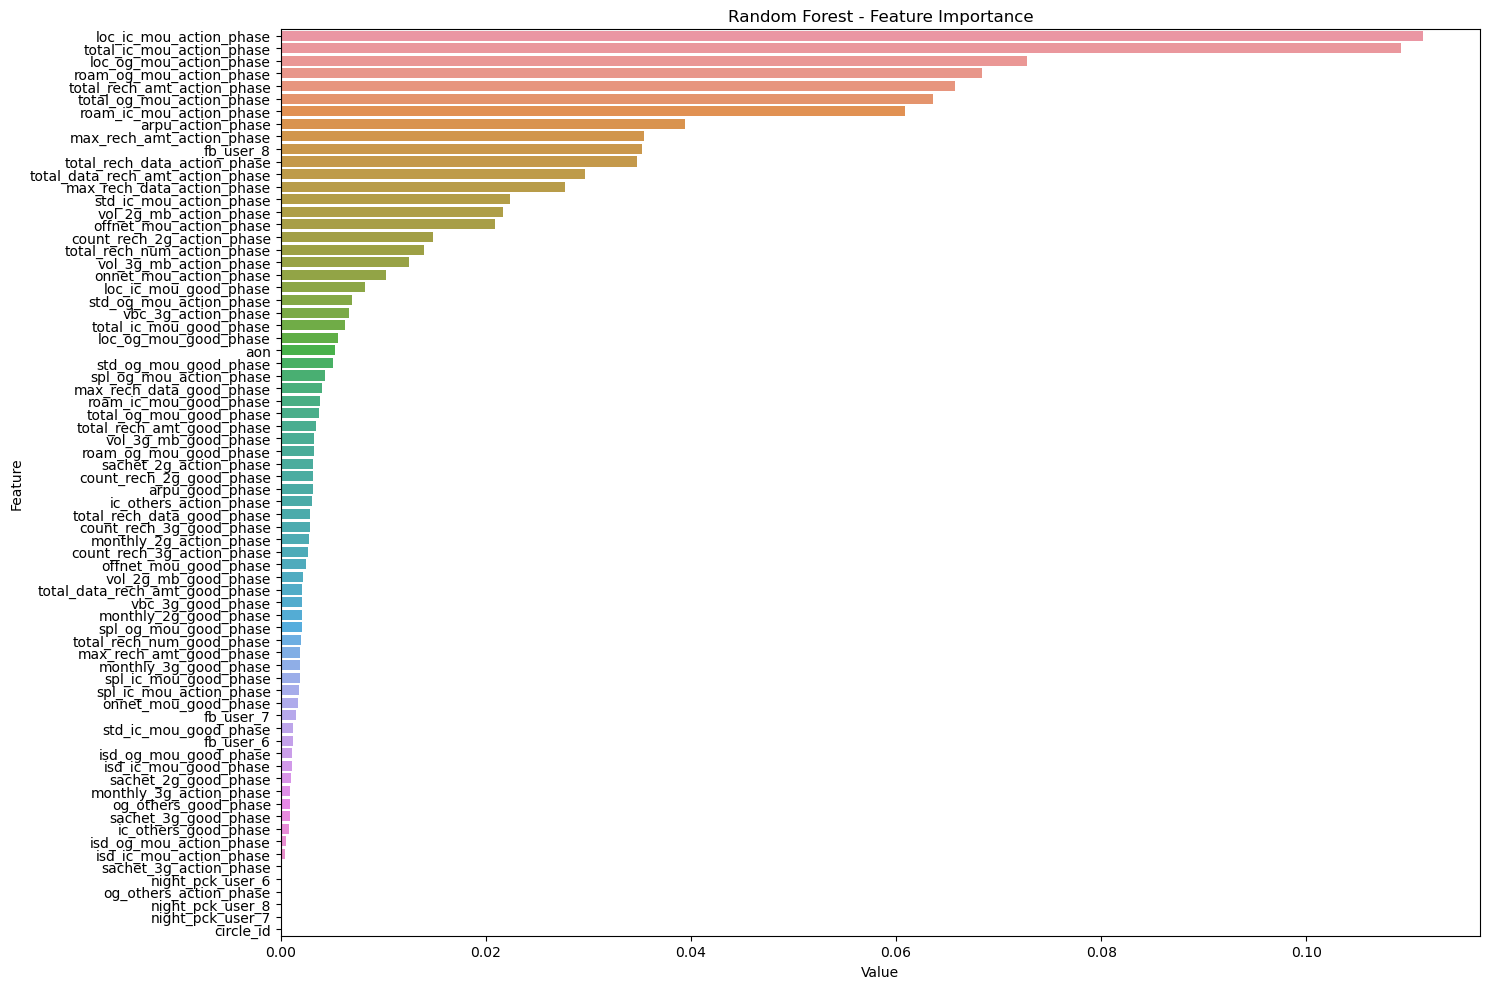

In [159]:
feature_imp = pd.DataFrame({'Value': model_rf.feature_importances_, 'Feature': X.columns})

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()


In [160]:
# Top 25 features : 

feature_imp= feature_imp.sort_values("Value",ascending = False)
feature_imp.head(25)

Value                           Feature
31  0.111361           loc_ic_mou_action_phase
41  0.109216         total_ic_mou_action_phase
19  0.072808           loc_og_mou_action_phase
17  0.068389          roam_og_mou_action_phase
45  0.065768       total_rech_amt_action_phase
29  0.063555         total_og_mou_action_phase
15  0.060821          roam_ic_mou_action_phase
9   0.039440                 arpu_action_phase
47  0.035405         max_rech_amt_action_phase
6   0.035241                         fb_user_8
49  0.034746      total_rech_data_action_phase
71  0.029675  total_data_rech_amt_action_phase
51  0.027763        max_rech_data_action_phase
33  0.022337           std_ic_mou_action_phase
57  0.021716            vol_2g_mb_action_phase
13  0.020867           offnet_mou_action_phase
53  0.014870        count_rech_2g_action_phase
43  0.014023       total_rech_num_action_phase
59  0.012480            vol_3g_mb_action_phase
11  0.010227            onnet_mou_action_phase
30  0.008177             loc_ic_mou_good_phase
21  0.006921           std_og_mou_action_phase
69  0.006709               vbc_3g_action_phase
40  0.006252           total_ic_mou_good_phase
18  0.005615             loc_og_mou_good_phase

### Insights:

- Incoming Minutes (loc_ic_mou_action_phase): High importance suggests that customers with significant local incoming call activity during the action phase are likely to influence retention.

- Total Incoming Minutes (total_ic_mou_action_phase): The overall importance of incoming call minutes, including both local and STD, indicates its substantial impact on customer retention.

- Local Outgoing Minutes (loc_og_mou_action_phase): Outgoing call activity within the local network during the action phase is a key factor affecting customer decisions.

- Roaming Outgoing Minutes (roam_og_mou_action_phase): Roaming outgoing minutes during the action phase contribute to the model's understanding of churn risk.

- Total Recharge Amount (total_rech_amt_action_phase): Customers who invest more in recharges during the action phase are likely to stay.

- Total Outgoing Minutes (total_og_mou_action_phase): The overall importance of outgoing call minutes, combining local and STD, reflects its influence on retention.

- Roaming Incoming Minutes (roam_ic_mou_action_phase): Incoming call activity during roaming in the action phase is a significant factor.

- Average Revenue per User (arpu_action_phase): The ARPU during the action phase contributes to understanding customer value and potential retention.

- Maximum Recharge Amount (max_rech_amt_action_phase): Customers who make higher maximum recharges during the action phase are more likely to be retained.

- Facebook Usage (fb_user_8): Presence or absence of Facebook usage in the eighth month contributes to churn prediction.


### Business Recommedation:

The top 10 features predominantly focus on:
- call usage, Recharge behavior, and roaming activity during the action phase. 
- These insights suggest that customer communication patterns and recharge behaviors during the action phase heavily influence churn decisions. 
- Emphasizing targeted promotions, improving network quality, and addressing customer needs during this critical phase 
can contribute to better customer retention.